In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.stats import mode, pearsonr
from scipy.optimize import curve_fit
from statsmodels.robust import mad
from numpy.random import normal

# Include the utils functions
import os
import sys
sys.path.insert(0, os.path.abspath('./'))
from utils import *

import warnings
warnings.filterwarnings('ignore')

boxcar_window_size = 3001
matched_filter_window_length = (3000./3600)
matched_filter_depth = 1./np.pi
matched_filter_fwhm = 1./3600
detection_threshold = 5.
matched_filter_num_fwhm = 15

Gamma_min = 0.5
Gamma_max = 100
P_min = 0.1

# For the pre-detection of vortices calculations
num_sig = 5.

max_b_over_Dact = 1.
min_full_Vobs_sigma = 5.

dr="/Users/bjackson/Downloads/ps_bundle/data_calibrated"
dr_wind = '/Users/bjackson/Downloads/twins_bundle/data_derived'
# dr="/Users/brian/Downloads/ps_bundle/data_calibrated"
# dr_wind = '/Users/brian/Downloads/twins_bundle/data_derived'

aspect_ratio = 16./9 # On HD projectors nowadays, this is the aspect ratio.
                     # so I make my figures using that ratio so they show up nicely in presentations.
BoiseState_blue = "#0033A0"
BoiseState_orange = "#D64309"

def line(x, m, b):
    return m*x + b

476.0
0.13307 0.2084205 0.562825
66.0
395.0
30.0
[0.510427]


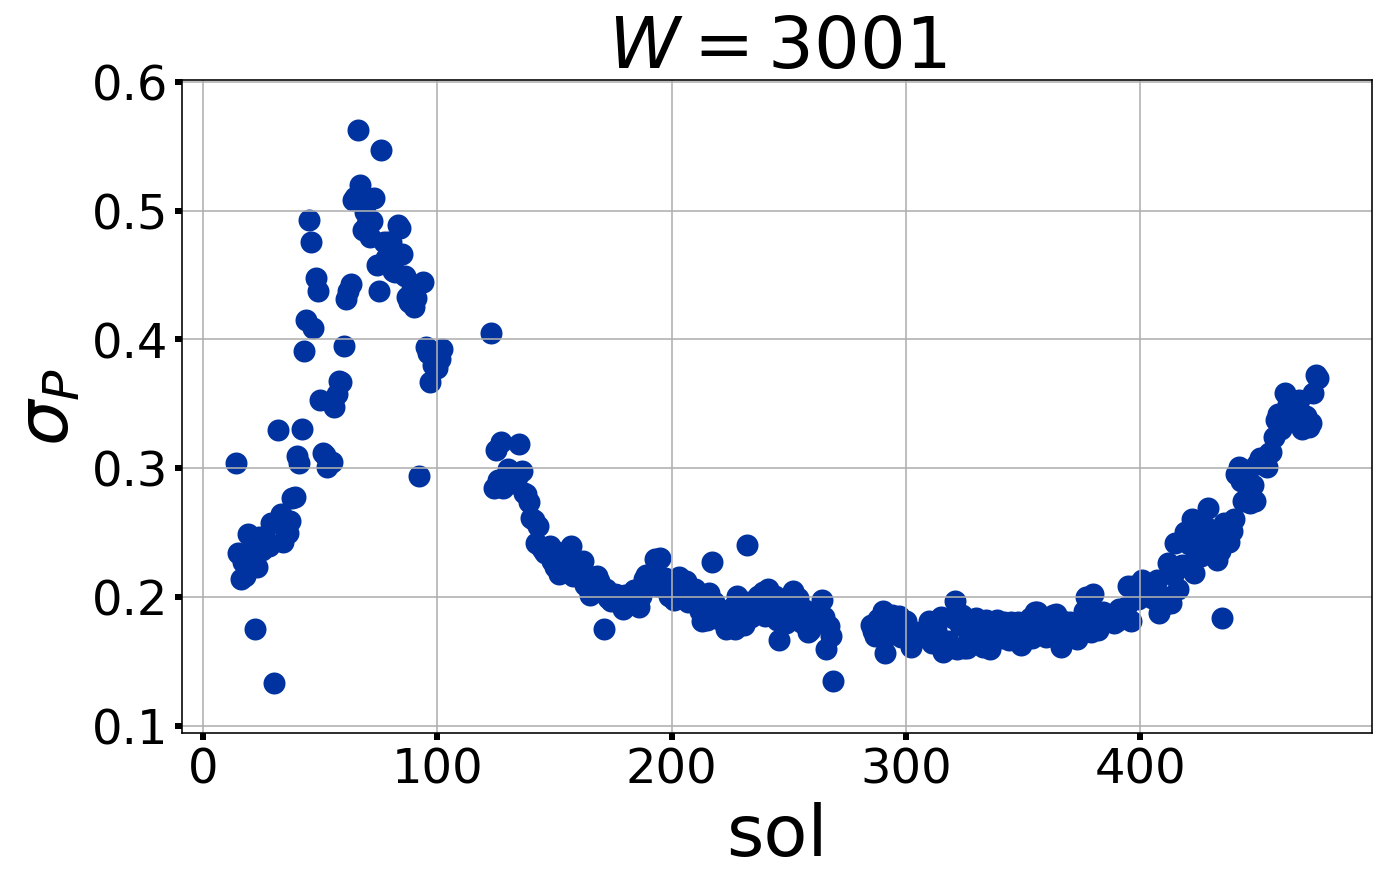

In [4]:
# 2020 Aug 5 - Cycle through all available sols and figure out which ones have the largest and smallest scatters
sols = range(14, 477)

new_filename = "filtered_pressure_scatter.csv"
# f = open(new_filename, "w")
# f.write("# sol, scatter\n")

# stds = np.array([])
# for cur_sol in sols:
# for cur_sol in [66]:
#     try:
#         LTST, LTST_and_sol, sol_data = retrieve_data(cur_sol, dr=dr)

#         pressure_filter, st = boxcar_filter(LTST, LTST_and_sol, sol_data, boxcar_window_size)
#     pressure_filter = savgol_filter(sol_data["PRESSURE"], boxcar_window_size, 0, mode='interp')

#         plt.plot(LTST_and_sol, (sol_data["PRESSURE"] - pressure_filter), marker='.', ls='')
#         plt.plot(LTST_and_sol, sol_data["PRESSURE"], marker='.', ls='')
#         plt.plot(LTST_and_sol, pressure_filter, marker='.', ls='')
    
#     plt.plot(LTST_and_sol[ind], np.ones_like(LTST_and_sol[ind])*np.nanmedian(sol_data["PRESSURE"]), marker='o')
#         plt.plot(LTST_and_sol, pressure_filter, marker='.', ls='')

#     cur_std = np.nanstd(sol_data['PRESSURE'] - pressure_filter)
#     write_str = "%i, %g" % (cur_sol, cur_std)
#     print(write_str)
#         f.write(write_str + "\n")

#         stds = np.append(stds, cur_std)

#     except:
#         print(cur_sol)
#         pass

# f.close()

data = np.genfromtxt(new_filename, delimiter=',', comments='#', names=True)

fig = plt.figure(figsize=(6*aspect_ratio, 6))
ax = fig.add_subplot(111)
ax.scatter(data['sol'], data['scatter'], color=BoiseState_blue, s=100)

print(data['sol'][-1])

ax.grid(True)
ax.set_title(r'$W = $%i' % boxcar_window_size, fontsize=36)
ax.set_xlabel("sol", fontsize=36)
ax.set_ylabel(r'$\sigma_P$', fontsize=36)
ax.tick_params(labelsize=24)

print(np.min(data['scatter']), np.median(data['scatter']), np.max(data['scatter']))
print(data['sol'][np.argmax(data['scatter'])])
print(data['sol'][np.argmin(np.abs(data['scatter'] - np.median(data['scatter'])))])
print(data['sol'][np.argmin(data['scatter'])])
print(data['scatter'][data['sol'] == 65])

max_sol = int(data['sol'][np.argmax(data['scatter'])])
med_sol = int(data['sol'][np.argmin(np.abs(data['scatter'] - np.median(data['scatter'])))])
min_sol = int(data['sol'][np.argmin(data['scatter'])])

# fig.savefig(new_filename.replace("csv", "png"), dpi=500, bbox_inches='tight')

0.9843920333989177


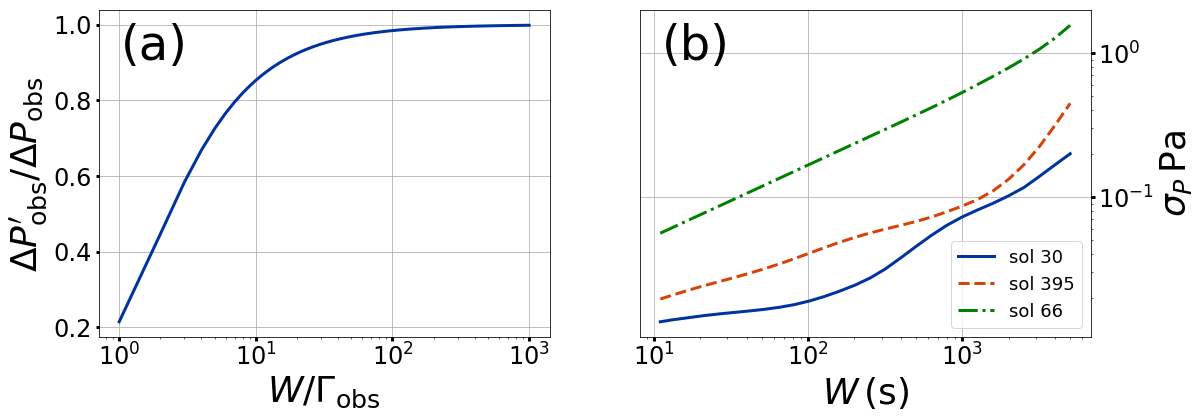

In [14]:
fig = plt.figure(figsize=(10*aspect_ratio, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
# plt.setp(ax2.get_yticklabels(), visible=False)

# This calculation reflects the change in Delta P from the Savitsky-Golay filter

x = np.linspace(1, 1000, 1000)
f = 1. - np.arctan(x)/x
ax1.semilogx(x, f, color=BoiseState_blue, lw=3)
print(f[np.argmin(np.abs(x - 100.))])

ax1.set_xlabel(r'$W/\Gamma_{\rm obs}$', fontsize=36)
ax1.set_ylabel(r'$\Delta P_{\rm obs}^\prime/\Delta P_{\rm obs}$', fontsize=36)
ax1.grid(True)
ax1.tick_params(labelsize=24)
ax1.text(0.05, 0.85, "(a)", fontsize=48, transform=ax1.transAxes)

### (b) ###

sol = min_sol
LTST, LTST_and_sol, sol_data = retrieve_data(sol, dr=dr)
LTST_and_sol -= 24.*sol

delta_t = np.max(LTST_and_sol[1:] - LTST_and_sol[0:-1])
min_window_size = np.log10(10./3600)
max_window_size = np.log10(5000./3600)
window_lengths_int = np.ceil((10**(np.arange(min_window_size, max_window_size + 0.1, 0.1))/delta_t)) // 2 * 2 + 1 
window_lengths = window_lengths_int*delta_t*3600.

stds = np.array([])
for i in range(len(window_lengths)):
    pressure_filter = savgol_filter(sol_data['PRESSURE'], window_lengths_int[i], 0, mode='nearest')
    stds = np.append(stds, np.std(sol_data['PRESSURE'] - pressure_filter))
ax2.loglog(window_lengths, stds, color=BoiseState_blue, lw=3, label="sol %i" % min_sol)

sol = med_sol
LTST, LTST_and_sol, sol_data = retrieve_data(sol, dr=dr)
LTST_and_sol -= 24.*sol
stds = np.array([])
for i in range(len(window_lengths)):
    pressure_filter = savgol_filter(sol_data['PRESSURE'], window_lengths_int[i], 0, mode='nearest')
    stds = np.append(stds, np.std(sol_data['PRESSURE'] - pressure_filter))
ax2.loglog(window_lengths, stds, color=BoiseState_orange, lw=3, ls='--', label="sol %i" % med_sol)

sol = max_sol
LTST, LTST_and_sol, sol_data = retrieve_data(sol, dr=dr, nans_in_gaps=False)
LTST_and_sol -= 24.*sol
stds = np.array([])
for i in range(len(window_lengths)):
    pressure_filter = savgol_filter(sol_data['PRESSURE'], window_lengths_int[i], 0, mode='nearest')
    stds = np.append(stds, np.std(sol_data['PRESSURE'] - pressure_filter))
ax2.loglog(window_lengths, stds, color='green', lw=3, ls='-.', label="sol %i" % max_sol)

ax2.legend(loc="lower right", fontsize=18)

ax2.set_xlabel(r'$W\,\left( {\rm s} \right)$', fontsize=36)
ax2.set_ylabel(r'$\sigma_P\,{\rm Pa}$', fontsize=36)
ax2.grid(True)
ax2.tick_params(labelsize=24)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.text(0.05, 0.85, "(b)", fontsize=48, transform=ax2.transAxes)
 
# fig.savefig("../figures/Pobsprime-sigmaP_vs_W.png", dpi=500, bbox_inches="tight")

[]


ValueError: attempt to get argmin of an empty sequence

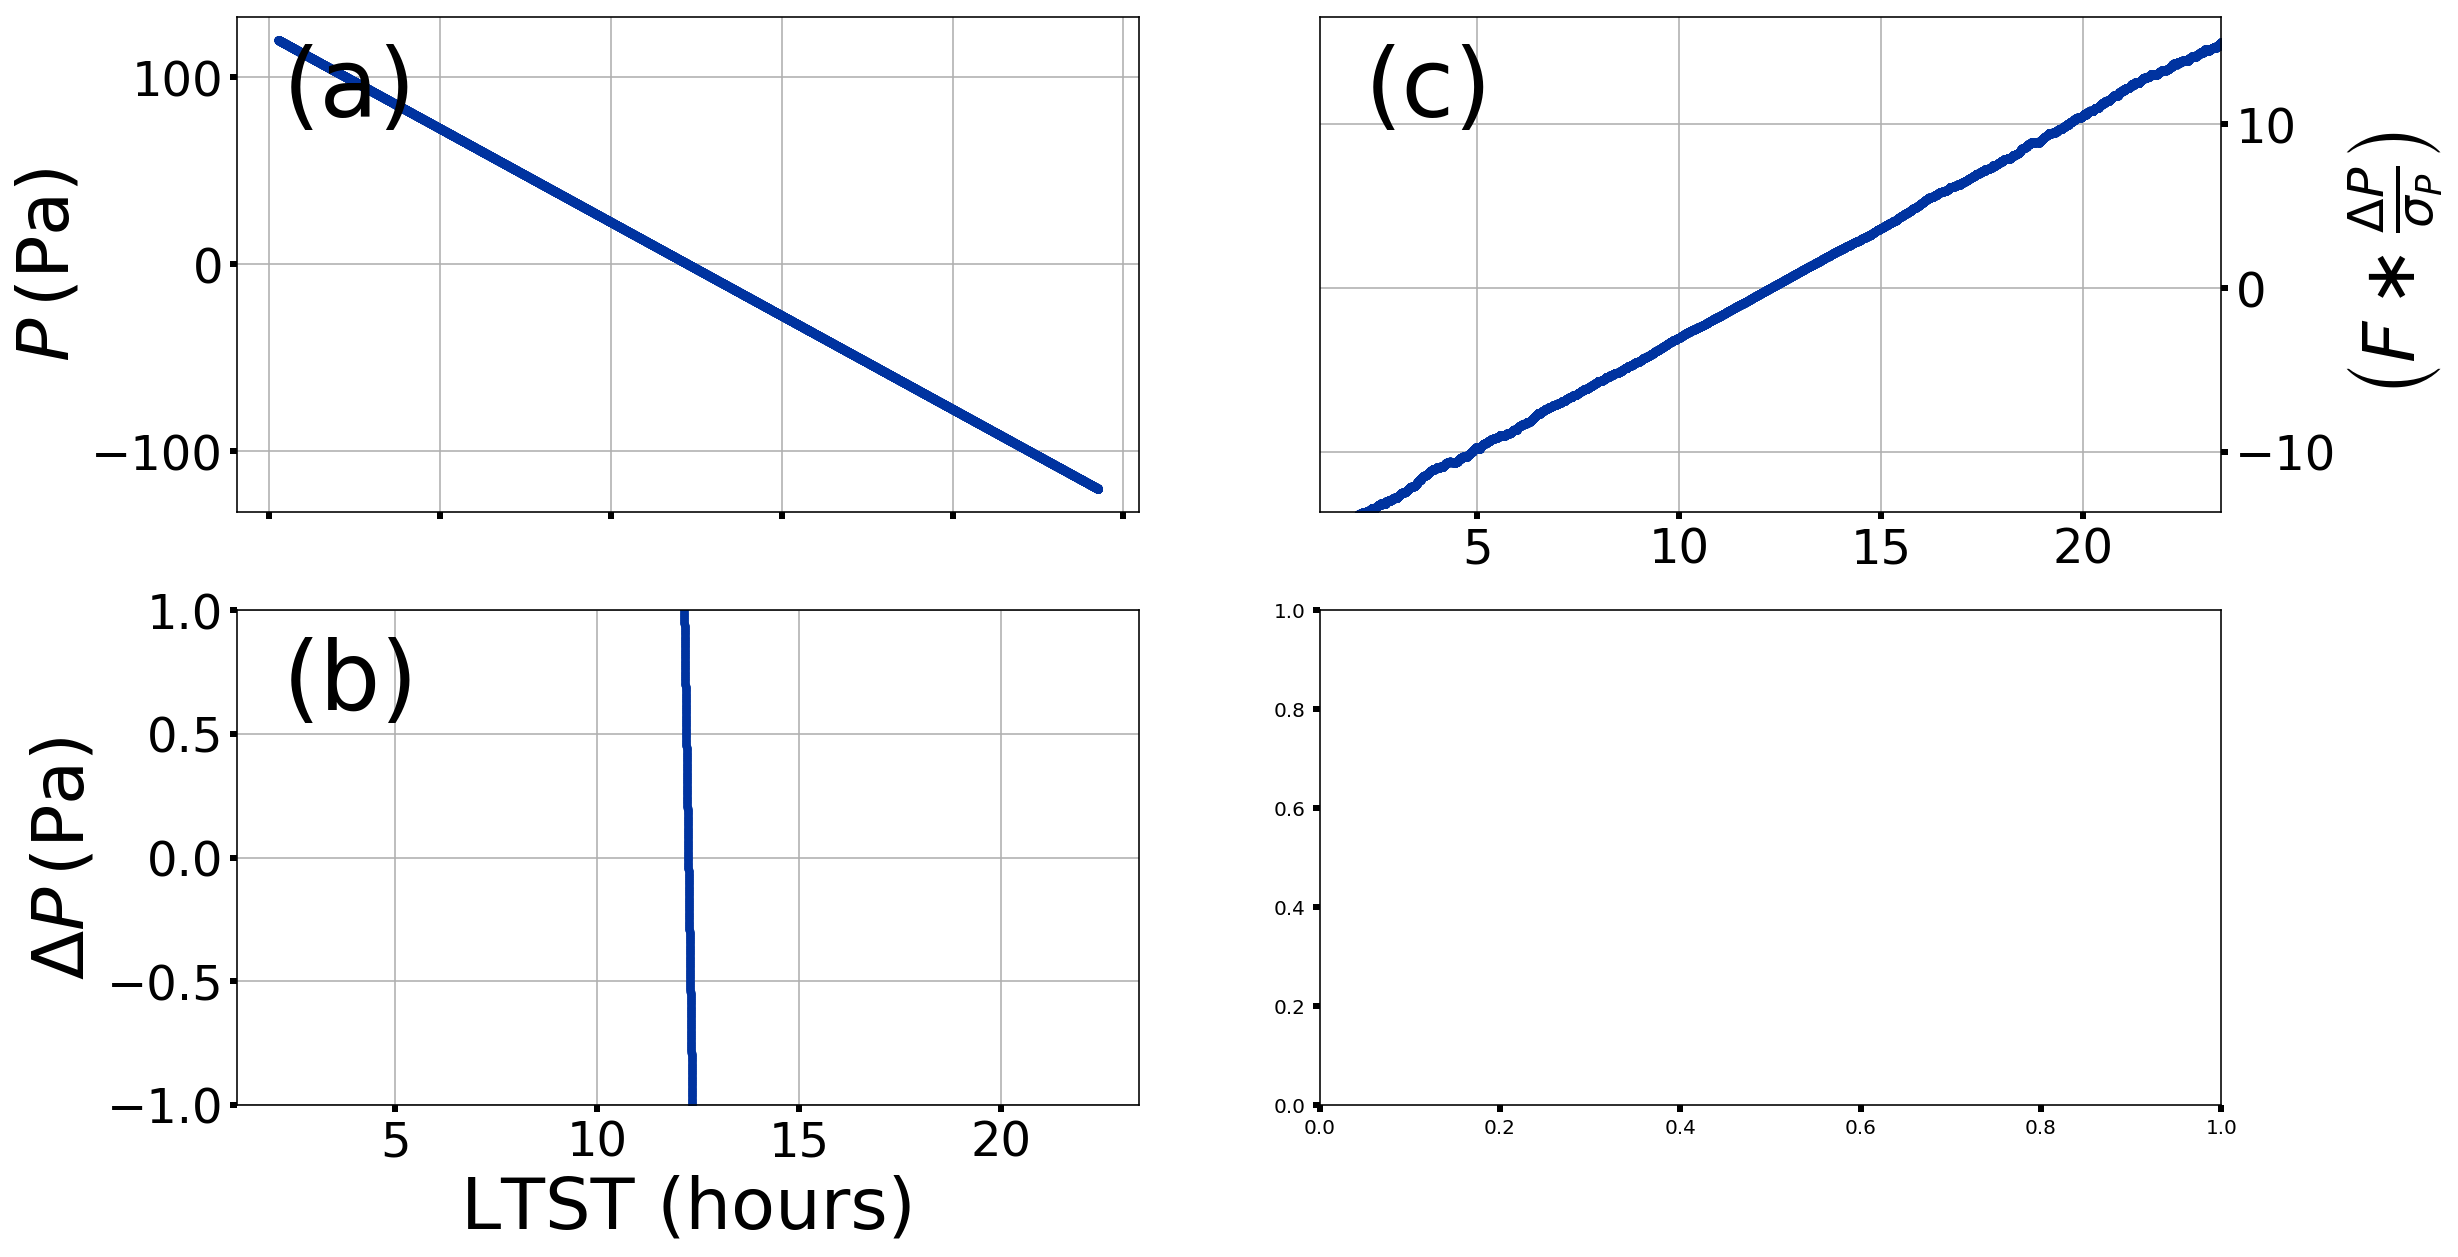

In [5]:
# The sol with the deepest vortex, as reported by Spiga et al. (2020)
# sol = 65
sol = 323
LTST, LTST_and_sol, sol_data = retrieve_data(sol, dr=dr)
LTST_and_sol -= 24.*sol
    
delta_t = np.max(LTST_and_sol[1:] - LTST_and_sol[0:-1])

# Generate synthetic data
baseline = 0.
slope = -10.
t0 = np.median(LTST_and_sol)
sol_data['PRESSURE'] = modified_lorentzian(LTST_and_sol, 
baseline, slope, t0, matched_filter_depth, matched_filter_fwhm) +\
    normal(scale=matched_filter_depth/5., size=LTST_and_sol.shape)

fig = plt.figure(figsize=(10*aspect_ratio, 10))

### Raw Data ###

ind = (LTST_and_sol > np.min(LTST_and_sol) + boxcar_window_size*delta_t) &\
        (LTST_and_sol < np.max(LTST_and_sol) - boxcar_window_size*delta_t)

ax1 = fig.add_subplot(221)
ax1.plot(LTST_and_sol, sol_data['PRESSURE'], marker='.', ls='', color=BoiseState_blue)
ax1.text(0.05, 0.8, "(a)", fontsize=48, transform=ax1.transAxes)
ax1.grid(True)
ax1.tick_params(labelsize=24, labelbottom=False)
ax1.set_ylabel(r'$P\,\left({\rm Pa}\right)$', fontsize=36)

### Filtered Data ###

ax2 = fig.add_subplot(223)
filtered_pressure, st = boxcar_filter(LTST, LTST_and_sol, sol_data, boxcar_window_size)

ax2.plot(LTST_and_sol, filtered_pressure, marker='.', ls='', color=BoiseState_blue)
ax2.text(0.05, 0.8, "(b)", fontsize=48, transform=ax2.transAxes)
ax2.grid(True)
ax2.tick_params(labelsize=24)
ax2.set_xlabel("LTST (hours)", fontsize=36)
ax2.set_ylabel(r'$\Delta P\,\left( {\rm Pa} \right)$', fontsize=36)

ax2.set_xlim([np.min(LTST_and_sol[ind]), np.max(LTST_and_sol[ind])])
# ax2.set_ylim([0.9*np.min(filtered_pressure[ind]), 1.1*np.max(filtered_pressure[ind])])
ax2.set_ylim([-1, 1])

### Matched Filter ###

# Convolve with Lorentzian

convolution = apply_lorentzian_matched_filter(LTST_and_sol, filtered_pressure, st, 
                                              matched_filter_fwhm, matched_filter_depth, boxcar_window_size)
med = np.nanmedian(convolution)
md = mad(convolution)

ax3 = fig.add_subplot(222)
ax3.plot(LTST_and_sol, convolution, color=BoiseState_blue, ls='', marker='.')
ax3.axhline(med + detection_threshold*md, color=BoiseState_orange, ls='--', lw=6, zorder=-1)
ax3.text(0.05, 0.8, "(c)", fontsize=48, transform=ax3.transAxes)
ax3.grid(True)
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()
ax3.tick_params(labelsize=24, labelleft=False, labelright=True)

ax3.set_ylabel(r'$\left( F \ast \frac{\Delta P}{\sigma_P} \right)$', fontsize=36)
# ax3.set_xlabel("LTST (hours)", fontsize=36)
ax3.set_xlim([np.min(LTST_and_sol[ind]), np.max(LTST_and_sol[ind])])
ax3.set_ylim([0.9*np.min(convolution[ind]), 1.1*np.max(convolution[ind])])

### Fit Vortex ###
ax4 = fig.add_subplot(224)

ex, pk_wds = find_vortices(LTST_and_sol, convolution, detection_threshold=detection_threshold)
print(ex)
for cur_ex in ex:
    ax2.axvline(LTST_and_sol[cur_ex], color=BoiseState_orange, zorder=-1, ls='--')
    ax3.axvline(LTST_and_sol[cur_ex], color=BoiseState_orange, zorder=-1, ls='--')
    
# Take largest one
# mx_ind = np.argmax(convolution[ex])
mx_ind = np.argmin(convolution[ex])
# mx_ind = np.argmin(np.abs(convolution[ex] - np.median(convolution[ex])))
# mx_ind = 7
mx_width = int(pk_wds[mx_ind])

# Use original, unfiltered data
vortex = np.array([LTST_and_sol[ex[mx_ind] - matched_filter_num_fwhm*mx_width:
                                ex[mx_ind] + matched_filter_num_fwhm*mx_width], 
                   sol_data['PRESSURE'][ex[mx_ind] - matched_filter_num_fwhm*mx_width:
                                        ex[mx_ind] + matched_filter_num_fwhm*mx_width]])

errs = st[ex[mx_ind] - matched_filter_num_fwhm*mx_width: ex[mx_ind] + matched_filter_num_fwhm*mx_width]

init_params = determine_init_params(vortex)
bounds = determine_bounds(vortex, init_params)

popt, uncertainties = fit_vortex(vortex, init_params, bounds, rescale_uncertainties=True, zoomed_in=None)

ax4.errorbar((vortex[0] - popt[2])*3600, vortex[1] - popt[0], yerr=errs, ls='', marker='o', color=BoiseState_blue)
ax4.plot((vortex[0] - popt[2])*3600, modified_lorentzian(vortex[0], *popt) - popt[0], 
         lw=3, color=BoiseState_orange, zorder=-1)

ax4.text(0.05, 0.05, "(d)", fontsize=48, transform=ax4.transAxes)
ax4.text(0.525, 0.1, ("$\\Delta P_{\\rm obs} = $(%.2g$\\pm$%.1g) Pa \n $\\Gamma_{\\rm obs} = $(%.2g$\\pm$%.1g) s" %\
                       (popt[3], uncertainties[3], popt[4]*3600, uncertainties[4]*3600)), 
         fontsize=20, transform=ax4.transAxes)
ax4.grid(True)
ax4.yaxis.set_label_position("right")
ax4.yaxis.tick_right()
ax4.tick_params(labelsize=24, labelleft=False, labelright=True)
ax4.set_xlabel(r'$t - t_0\,\left( {\rm s} \right)$', fontsize=36)
ax4.set_ylabel(r'$\Delta P\,\left( {\rm Pa} \right)$', fontsize=36)

print((np.max(convolution[ex]) - med)/md)

# fig.savefig("../figures/data_conditioning_and_fit.png", dpi=500, bbox_inches='tight')

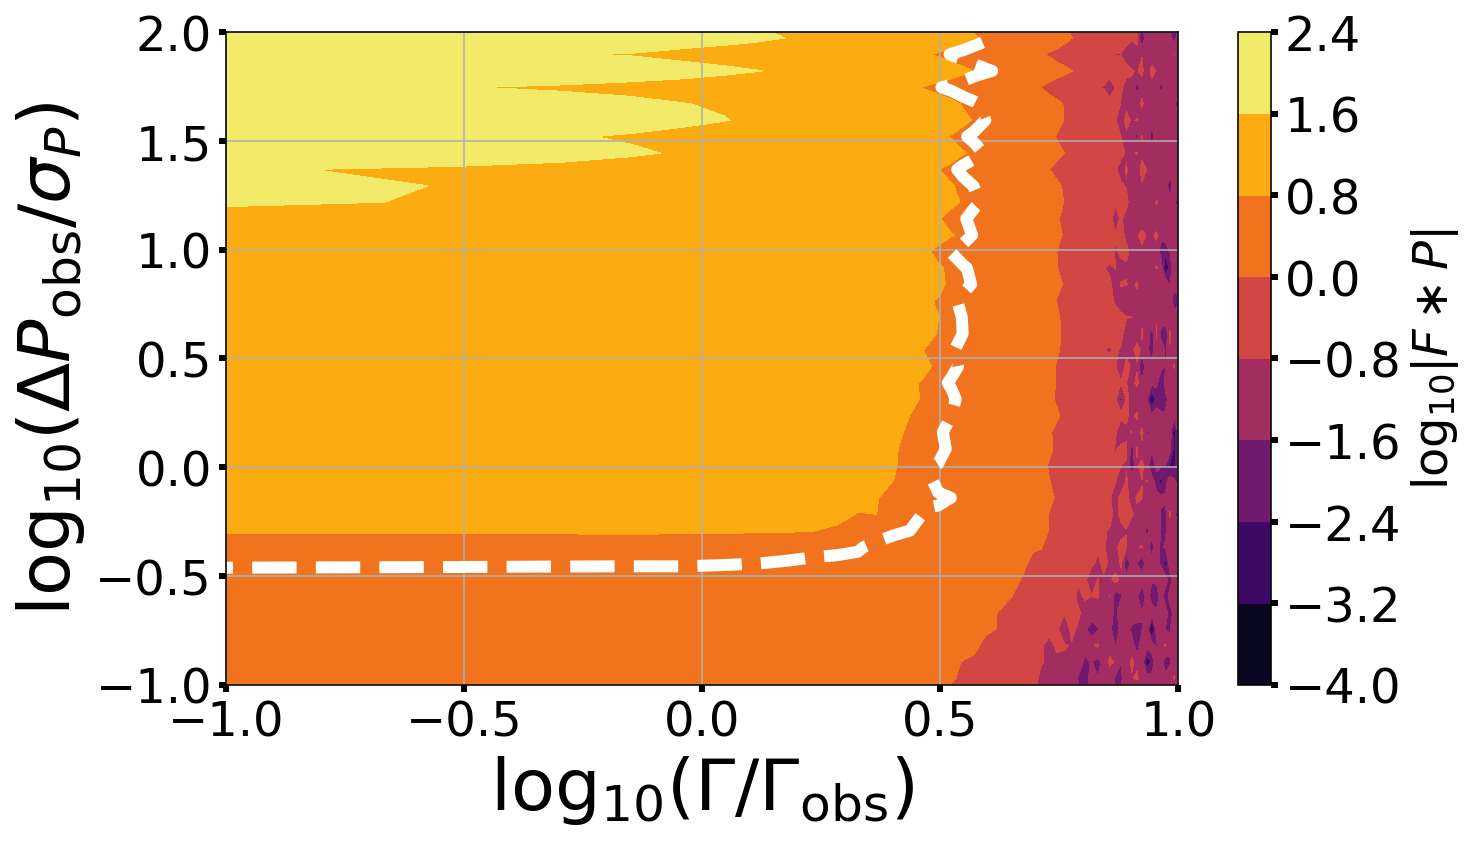

In [4]:
# sol = 65
sol = 323
LTST, LTST_and_sol, sol_data = retrieve_data(sol, dr=dr, filename_stem="calib")
LTST_and_sol -= 24.*sol
    
delta_t = np.max(LTST_and_sol[1:] - LTST_and_sol[0:-1])

# Generate synthetic data
baseline = 0.
slope = 0.
t0 = np.median(LTST_and_sol)

time = np.arange(-20.*matched_filter_fwhm, 20.*matched_filter_fwhm, delta_t) + t0

num_factors = 50
num_simulations = 200
noise_factors = 10**(np.linspace(2.2, -1.5, num_factors))
width_factors = np.linspace(0.1, 10., num_factors)

recovery = np.zeros([num_simulations, num_factors, num_factors])
for i in range(num_simulations):
    for j in range(num_factors):
        for k in range(num_factors):
            data = modified_lorentzian(time, baseline, slope, t0, matched_filter_depth, matched_filter_fwhm) +\
            normal(scale=matched_filter_depth/noise_factors[k], size=time.shape)
            
            convolution =\
                apply_lorentzian_matched_filter(time, data, matched_filter_depth/noise_factors[k], 
                                                matched_filter_fwhm*width_factors[j], matched_filter_depth)
            # What convolution do you get for the peak?
            ind = np.argmin(np.abs(time - t0))
            
            med = np.median(convolution)
            md = mad(convolution)
            recovery[i,j,k] = (convolution[ind] - med)/md
            
X, Y = np.meshgrid(np.log10(width_factors), np.log10(noise_factors))
fig = plt.figure(figsize=(6*aspect_ratio, 6))
# ax = fig.add_subplot(111)

# cp = ax.contourf(X, Y, np.log10(np.mean(recovery, axis=0)))
# fig.colorbar(cp) # Add a colorbar to a plot

CS = plt.contour(X, Y, np.log10(np.abs(np.mean(recovery, axis=0))), 
                 levels = [np.log10(5)], linewidths=(6,), colors=('white'), linestyles=("--"))
# CS = plt.contourf(X, Y, np.log10(np.mean(recovery, axis=0)), 
#                   np.array([np.log10(1), np.log10(3), np.log10(5), 
#                             np.log10(10), np.log10(30), np.log10(50), 
#                             np.log10(100), np.log10(300)]), cmap='inferno')
CS = plt.contourf(X, Y, np.log10(np.abs(np.mean(recovery, axis=0))), cmap='inferno')

CB = plt.colorbar(CS, extend='both')
CB.ax.tick_params(labelsize=24) 
CB.set_label(r'$\log_{10} | F\ast P |$', fontsize=24)
plt.ylim([-1, 2])

plt.tick_params(labelsize=24)
plt.xlabel(r'$\log_{10} \left( \Gamma/\Gamma_{\rm obs} \right)$', fontsize=36)
plt.ylabel(r'$\log_{10} \left( \Delta P_{\rm obs}/\sigma_P \right)$', fontsize=36)

plt.grid(True)

# plt.semilogx(1/noise_factors, np.mean(recovery[:,:,0], axis=0))
# plt.semilogx(matched_filter_depth/noise_factors, np.mean(recovery[:,:,1], axis=0))
# plt.semilogx(matched_filter_depth/noise_factors, np.mean(recovery[:,:,2], axis=0))

# sol_data['PRESSURE'] = modified_lorentzian(LTST_and_sol, 
#                                            baseline, slope, t0, matched_filter_depth, matched_filter_fwhm) +\
#     normal(scale=matched_filter_depth/5., size=LTST_and_sol.shape)

# fig.savefig("../figures/vortex_recovery.png", dpi=500, bbox_inches="tight")

In [10]:
# The sol with the deepest vortex, as reported by Spiga et al. (2020)
# sol = 65
# sol = 323
sol = med_sol
# sol = 18

print(sol)

LTST, LTST_and_sol, sol_data = retrieve_data(sol, dr=dr)
LTST_and_sol -= 24.*sol
  
delta_t = np.max(LTST_and_sol[1:] - LTST_and_sol[0:-1])

fig = plt.figure(figsize=(10*aspect_ratio, 10))

### Raw Data ###

ind = (LTST_and_sol > np.min(LTST_and_sol) + boxcar_window_size*delta_t) &\
        (LTST_and_sol < np.max(LTST_and_sol) - boxcar_window_size*delta_t)

ax1 = fig.add_subplot(221)
ax1.plot(LTST_and_sol, sol_data['PRESSURE'], marker='.', ls='', color=BoiseState_blue)
ax1.text(0.05, 0.05, "(a)", fontsize=48, transform=ax1.transAxes)
ax1.grid(True)
ax1.tick_params(labelsize=24, labelbottom=False)
ax1.set_ylabel(r'$P\,\left({\rm Pa}\right)$', fontsize=36)

### Filtered Data ###

ax2 = fig.add_subplot(223, sharex=ax1)

pressure_filter, st = boxcar_filter(LTST, LTST_and_sol, sol_data, boxcar_window_size)
filtered_pressure = sol_data["PRESSURE"] - pressure_filter

ax2.plot(LTST_and_sol, filtered_pressure, marker='.', ls='', color=BoiseState_blue)
ax2.text(0.05, 0.05, "(b)", fontsize=48, transform=ax2.transAxes)
ax2.grid(True)
ax2.tick_params(labelsize=24)
ax2.set_xlabel("LTST (hours)", fontsize=36)
ax2.set_ylabel(r'$\Delta P\,\left( {\rm Pa} \right)$', fontsize=36)

ax2.set_xlim([np.min(LTST_and_sol[ind]), np.max(LTST_and_sol[ind])])
ax2.set_ylim([0.9*np.min(filtered_pressure[ind]), 1.1*np.max(filtered_pressure[ind])])
# ax2.set_ylim([-1, 1])

### Matched Filter ###

# Convolve with Lorentzian

convolution = apply_lorentzian_matched_filter(LTST_and_sol, filtered_pressure, st, 
                                                      matched_filter_fwhm, matched_filter_depth, boxcar_window_size)
med = np.median(convolution)
md = mad(convolution)

convolution -= med
convolution /= md

ax3 = fig.add_subplot(222)
ax3.plot(LTST_and_sol, convolution, color=BoiseState_blue, ls='', marker='.')
ax3.axhline(detection_threshold, color=BoiseState_orange, ls='--', lw=6, zorder=-1)
ax3.text(0.05, 0.8, "(c)", fontsize=48, transform=ax3.transAxes)
ax3.grid(True)
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()
ax3.tick_params(labelsize=24, labelleft=False, labelright=True)

ax3.set_ylabel(r'$\left( F \ast \Delta P \right)$', fontsize=36)
# ax3.set_xlabel("LTST (hours)", fontsize=36)
ax3.set_xlim([np.min(LTST_and_sol[ind]), np.max(LTST_and_sol[ind])])
# ax3.set_xlim([8., 10.])
ax3.set_ylim([0.9*np.min(convolution[ind]), 1.1*np.max(convolution[ind])])

### Fit Vortex ###
ax4 = fig.add_subplot(224)

ex, pk_wds = find_vortices(LTST_and_sol, convolution, detection_threshold=detection_threshold)
print(len(ex))
for cur_ex in ex:
    ax1.axvline(LTST_and_sol[cur_ex], color=BoiseState_orange, zorder=-1, ls='--')
    ax2.axvline(LTST_and_sol[cur_ex], color=BoiseState_orange, zorder=-1, ls='--')
    ax3.axvline(LTST_and_sol[cur_ex], color=BoiseState_orange, zorder=-1, ls='--')
    
# Take largest one
mx_ind = np.argmax(convolution[ex])

# Take the smallest one
# mx_ind = np.argmin(convolution[ex])

# mx_ind = np.argmin(np.abs(convolution[ex] - np.median(convolution[ex])))
# mx_ind = 7
mx_width = np.max([2, int(pk_wds[mx_ind])])

# Use original, unfiltered data
vortex = np.array([LTST_and_sol[ex[mx_ind] - matched_filter_num_fwhm*mx_width:
                                ex[mx_ind] + matched_filter_num_fwhm*mx_width], 
                   sol_data['PRESSURE'][ex[mx_ind] - matched_filter_num_fwhm*mx_width:
                                        ex[mx_ind] + matched_filter_num_fwhm*mx_width]])

errs = st[ex[mx_ind] - matched_filter_num_fwhm*mx_width: ex[mx_ind] + matched_filter_num_fwhm*mx_width]

init_params = determine_init_params(vortex)
bounds = determine_bounds(vortex, init_params)

popt, uncertainties = fit_vortex(vortex, init_params, bounds, rescale_uncertainties=True, zoomed_in=None)
print(popt[2])

ax4.errorbar((vortex[0] - popt[2])*3600, vortex[1] - popt[0], 
             yerr=errs, ls='', marker='o', color=BoiseState_blue)
ax4.plot((vortex[0] - popt[2])*3600, modified_lorentzian(vortex[0], *popt) - popt[0], 
         lw=3, color=BoiseState_orange)

# ax4.text(0.05, 0.05, "(d), %g" % matched_filter_num_fwhm, fontsize=48, transform=ax4.transAxes)
ax4.text(0.05, 0.05, "(d)", fontsize=48, transform=ax4.transAxes)
ax4.text(0.525, 0.1, ("$\\Delta P_{\\rm obs} = $(%.1f$\\pm$%.1f) Pa \n $\\Gamma_{\\rm obs} = $(%.1f$\\pm$%.1f) s" %\
                       (popt[3], uncertainties[3], popt[4]*3600, uncertainties[4]*3600)), 
         fontsize=20, transform=ax4.transAxes)
ax4.grid(True)
ax4.yaxis.set_label_position("right")
ax4.yaxis.tick_right()
ax4.tick_params(labelsize=24, labelleft=False, labelright=True)
ax4.set_xlabel(r'$t - t_0\,\left( {\rm s} \right)$', fontsize=36)
ax4.set_ylabel(r'$\Delta P\,\left( {\rm Pa} \right)$', fontsize=36)

# fig.savefig("../figures/data_conditioning_and_fit.png", dpi=500, bbox_inches='tight')

395
0.9999999980209395


In [2]:
# 2020 Aug 8 - Next find all the vortices

# 2020 Sep 9 - Commented everything out

# plt.ioff() # turn off showing plot

# new_filename = "all_vortices.csv"
# f = open(new_filename, "w")
# # f = open(new_filename, "a")
# f.write("# vortex_number, sol, t0, t0_unc, DeltaP, DeltaP_unc, Gamma, Gamma_unc, "+\
#         "intercept, intercept_unc, slope, slope_unc, convolution\n")

# failed_filename = "all_the_sols_we_cannot_see.txt"
# # sols = np.genfromtxt(failed_filename, dtype='i', comments="#")
# ff = open(failed_filename, "w")

# # sols = range(14, 477)
# # sols = range(21, 23)

# # for cur_sol in sols[2:3]:
# for cur_sol in sols:
# # for cur_sol in [341]:
    
#     try:

#         LTST, LTST_and_sol, sol_data = retrieve_data(cur_sol, dr=dr)
#         LTST_and_sol -= 24.*cur_sol

#         delta_ts = (LTST_and_sol[1:] - LTST_and_sol[0:-1])
#         ind = delta_ts > 0.
#         delta_t = mode(delta_ts[ind])[0][0]

#         fig = plt.figure(figsize=(10*aspect_ratio, 10))
#         fig.suptitle("sol " + str(cur_sol), fontsize=36)

#         ### Raw Data ###

#         ind = (LTST_and_sol > np.min(LTST_and_sol) + boxcar_window_size*delta_t) &\
#                 (LTST_and_sol < np.max(LTST_and_sol) - boxcar_window_size*delta_t)

#         ax1 = fig.add_subplot(221)
#         ax1.plot(LTST_and_sol, sol_data['PRESSURE'], marker='.', ls='', color=BoiseState_blue)
#         ax1.text(0.05, 0.05, "(a)", fontsize=48, transform=ax1.transAxes)
#         ax1.grid(True)
#         ax1.tick_params(labelsize=24, labelbottom=False)
#         ax1.set_ylabel(r'$P\,\left({\rm Pa}\right)$', fontsize=36)

#         ### Filtered Data ###

#         ax2 = fig.add_subplot(223, sharex=ax1)

#         pressure_filter, st = boxcar_filter(LTST, LTST_and_sol, sol_data, boxcar_window_size)
#         filtered_pressure = sol_data["PRESSURE"] - pressure_filter

#         ax2.plot(LTST_and_sol, filtered_pressure, marker='.', ls='', color=BoiseState_blue)
#         ax2.text(0.05, 0.05, "(b)", fontsize=48, transform=ax2.transAxes)
#         ax2.grid(True)
#         ax2.tick_params(labelsize=24)
#         ax2.set_xlabel("LTST (hours)", fontsize=36)
#         ax2.set_ylabel(r'$\Delta P\,\left( {\rm Pa} \right)$', fontsize=36)

#         ax2.set_xlim([np.min(LTST_and_sol[ind]), np.max(LTST_and_sol[ind])])
#         ax2.set_ylim([0.9*np.min(filtered_pressure[ind]), 1.1*np.max(filtered_pressure[ind])])
#         # ax2.set_ylim([-1, 1])

#         ### Matched Filter ###

#         # Convolve with Lorentzian

#         convolution = apply_lorentzian_matched_filter(LTST_and_sol, filtered_pressure, st, 
#                                                       matched_filter_fwhm, matched_filter_depth, boxcar_window_size)
#         med = np.median(convolution)
#         md = mad(convolution)

#         convolution -= med
#         convolution /= md

#         ax3 = fig.add_subplot(222)
#         ax3.plot(LTST_and_sol, convolution, color=BoiseState_blue, ls='', marker='.')
#         ax3.axhline(detection_threshold, color=BoiseState_orange, ls='--', lw=6, zorder=-1)
#         ax3.text(0.05, 0.8, "(c)", fontsize=48, transform=ax3.transAxes)
#         ax3.grid(True)
#         ax3.yaxis.set_label_position("right")
#         ax3.yaxis.tick_right()
#         ax3.tick_params(labelsize=24, labelleft=False, labelright=True)

#         ax3.set_ylabel(r'$\left( F \ast \Delta P \right)$', fontsize=36)
#         # ax3.set_xlabel("LTST (hours)", fontsize=36)
#         ax3.set_xlim([np.min(LTST_and_sol[ind]), np.max(LTST_and_sol[ind])])
#         # ax3.set_xlim([8., 10.])
#         ax3.set_ylim([0.9*np.min(convolution[ind]), 1.1*np.max(convolution[ind])])

#         ### Fit Vortex ###
#         ax4 = fig.add_subplot(224)

#         ex, pk_wds = find_vortices(LTST_and_sol, convolution, detection_threshold=detection_threshold)

#         if(len(ex) > 0):

#             # Make a new directory
#             new_dir_name = "data_conditioning_figures/sol_" + str(cur_sol)
#             if not os.path.exists(new_dir_name):
#                 os.mkdir(new_dir_name)

#             # Sort vortices from weakest to strongest
#             srt = np.argsort(convolution[ex])
#             srt_ex = ex[srt]
#             srt_pk_wds = pk_wds[srt]

#             # 2020 Aug 10 - Sol 67 has an enormous increase in pressure, followed by a spike.
#             # This structure fools the fitting routine into seeing a lot of vortices.
#             # The easiest way to fix this is to ignore that region for that sol.
#             if((cur_sol == 67) or (cur_sol == 84)):
#                 drop_ind = ~(LTST_and_sol[srt_ex] > 18.)
#                 srt_ex = srt_ex[drop_ind]
#                 srt_pk_wds = srt_pk_wds[drop_ind]

#             for i in range(len(srt_ex)):

#                 mx_width = np.max([2, int(srt_pk_wds[i])])
#                 # Make sure that the mx_width doesn't go overboard
#                 mx_width = np.min([mx_width, int(300/15)])

#                 ax1.axvline(LTST_and_sol[srt_ex[i]], color=BoiseState_orange, zorder=-1, ls='--')
#                 ax2.axvline(LTST_and_sol[srt_ex[i]], color=BoiseState_orange, zorder=-1, ls='--')
#                 ax3.axvline(LTST_and_sol[srt_ex[i]], color=BoiseState_orange, zorder=-1, ls='--')

#             # Use original, unfiltered data
#                 vortex = np.array([LTST_and_sol[srt_ex[i] - matched_filter_num_fwhm*mx_width:
#                                                 srt_ex[i] + matched_filter_num_fwhm*mx_width], 
#                                    sol_data['PRESSURE'][srt_ex[i] - matched_filter_num_fwhm*mx_width:
#                                                         srt_ex[i] + matched_filter_num_fwhm*mx_width]])

#                 errs = st[srt_ex[i] - matched_filter_num_fwhm*mx_width: srt_ex[i] + matched_filter_num_fwhm*mx_width]

#                 # Sometimes the uncertainties go hay-wire. In those cases, impose a reasonable upper limit.
#                 if(np.any(errs > 10.)):
#                     errs = np.ones_like(errs)*1. # Pa

#                 init_params = determine_init_params(vortex)
#                 bounds = determine_bounds(vortex, init_params)

#                 popt, uncertainties = fit_vortex(vortex, init_params, bounds, rescale_uncertainties=True, zoomed_in=None)

#                 write_str = "%i, %i, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g" %\
#                     (i, cur_sol, popt[2], uncertainties[2], popt[3], uncertainties[3], 
#                      popt[4]*3600., uncertainties[4]*3600, 
#                      popt[0], uncertainties[0], popt[1], uncertainties[1], convolution[srt_ex[i]],)
#                 print(write_str)
#                 f.write(write_str + "\n")

#                 fig2 = plt.figure(figsize=(10*aspect_ratio, 10))
#                 fig2.suptitle("sol " + str(cur_sol) + ", vortex_number " + str(i), fontsize=36)

#                 axind = fig2.add_subplot(111)
#                 axind.errorbar((vortex[0] - popt[2])*3600, vortex[1] - popt[0], 
#                                yerr=errs, ls='', marker='o', color=BoiseState_blue)
#                 axind.plot((vortex[0] - popt[2])*3600, modified_lorentzian(vortex[0], *popt) - popt[0], 
#                            lw=3, color=BoiseState_orange)

#                 solution_str = ("$\\Delta P_{\\rm obs} = (%.1f\\pm%.1f)\\,{\\rm Pa}$ \n" +\
#                     "$\\Gamma_{\\rm obs} = (%.1f\\pm%.1f)\\,{\\rm s}$ \n "+\
#                     "$t_0 = %.4f\\,{\\rm hrs}\\pm%.3f\\,{\\rm s}$") %\
#                 (popt[3], uncertainties[3], popt[4]*3600, uncertainties[4]*3600, popt[2], uncertainties[2]*3600)

#                 axind.text(0.525, 0.1, solution_str, fontsize=20, transform=axind.transAxes)

#                 axind.grid(True)
#                 axind.tick_params(labelsize=24)
#                 axind.set_xlabel(r'$t - t_0\,\left( {\rm s} \right)$', fontsize=36)
#                 axind.set_ylabel(r'$\Delta P\,\left( {\rm Pa} \right)$', fontsize=36)

#                 fig2name = new_dir_name + "/sol_%s_vortex_number_%i.png" % (cur_sol, i)
#                 fig2.savefig(fig2name, dpi=500, bbox_inches="tight")

#             # Since the vortices are sorted biggest to smallest, the last one is the largest.
#             ax4.errorbar((vortex[0] - popt[2])*3600, vortex[1] - popt[0], 
#                          yerr=errs, ls='', marker='o', color=BoiseState_blue)
#             ax4.plot((vortex[0] - popt[2])*3600, modified_lorentzian(vortex[0], *popt) - popt[0], 
#                      lw=3, color=BoiseState_orange)

#             # ax4.text(0.05, 0.05, "(d), %g" % matched_filter_num_fwhm, fontsize=48, transform=ax4.transAxes)
#             ax4.text(0.05, 0.05, "(d)", fontsize=48, transform=ax4.transAxes)
#             ax4.text(0.525, 0.1, ("$\\Delta P_{\\rm obs} = $(%.1f$\\pm$%.1f) Pa \n $\\Gamma_{\\rm obs} = $(%.1f$\\pm$%.1f) s" %\
#                                    (popt[3], uncertainties[3], popt[4]*3600, uncertainties[4]*3600)), 
#                      fontsize=20, transform=ax4.transAxes)
#             ax4.grid(True)
#             ax4.yaxis.set_label_position("right")
#             ax4.yaxis.tick_right()
#             ax4.tick_params(labelsize=24, labelleft=False, labelright=True)
#             ax4.set_xlabel(r'$t - t_0\,\left( {\rm s} \right)$', fontsize=36)
#             ax4.set_ylabel(r'$\Delta P\,\left( {\rm Pa} \right)$', fontsize=36)

#         figname = "data_conditioning_figures/data_conditioning_sol_%s.png" % cur_sol
#         fig.savefig(figname, dpi=500, bbox_inches='tight')

#     except:
#         e = sys.exc_info()
#         print( e )
#         print("Broken sol: ", cur_sol)
#         ff.write(str(cur_sol) + "\n")
#         pass

# f.close()
# ff.close()

number of original vortices:  1034
number of culled vortices:  990
Gammaobs_quantile, DeltaPobs_quantile:  5.991664999999999 1.1151550000000001


(0.1, 10)

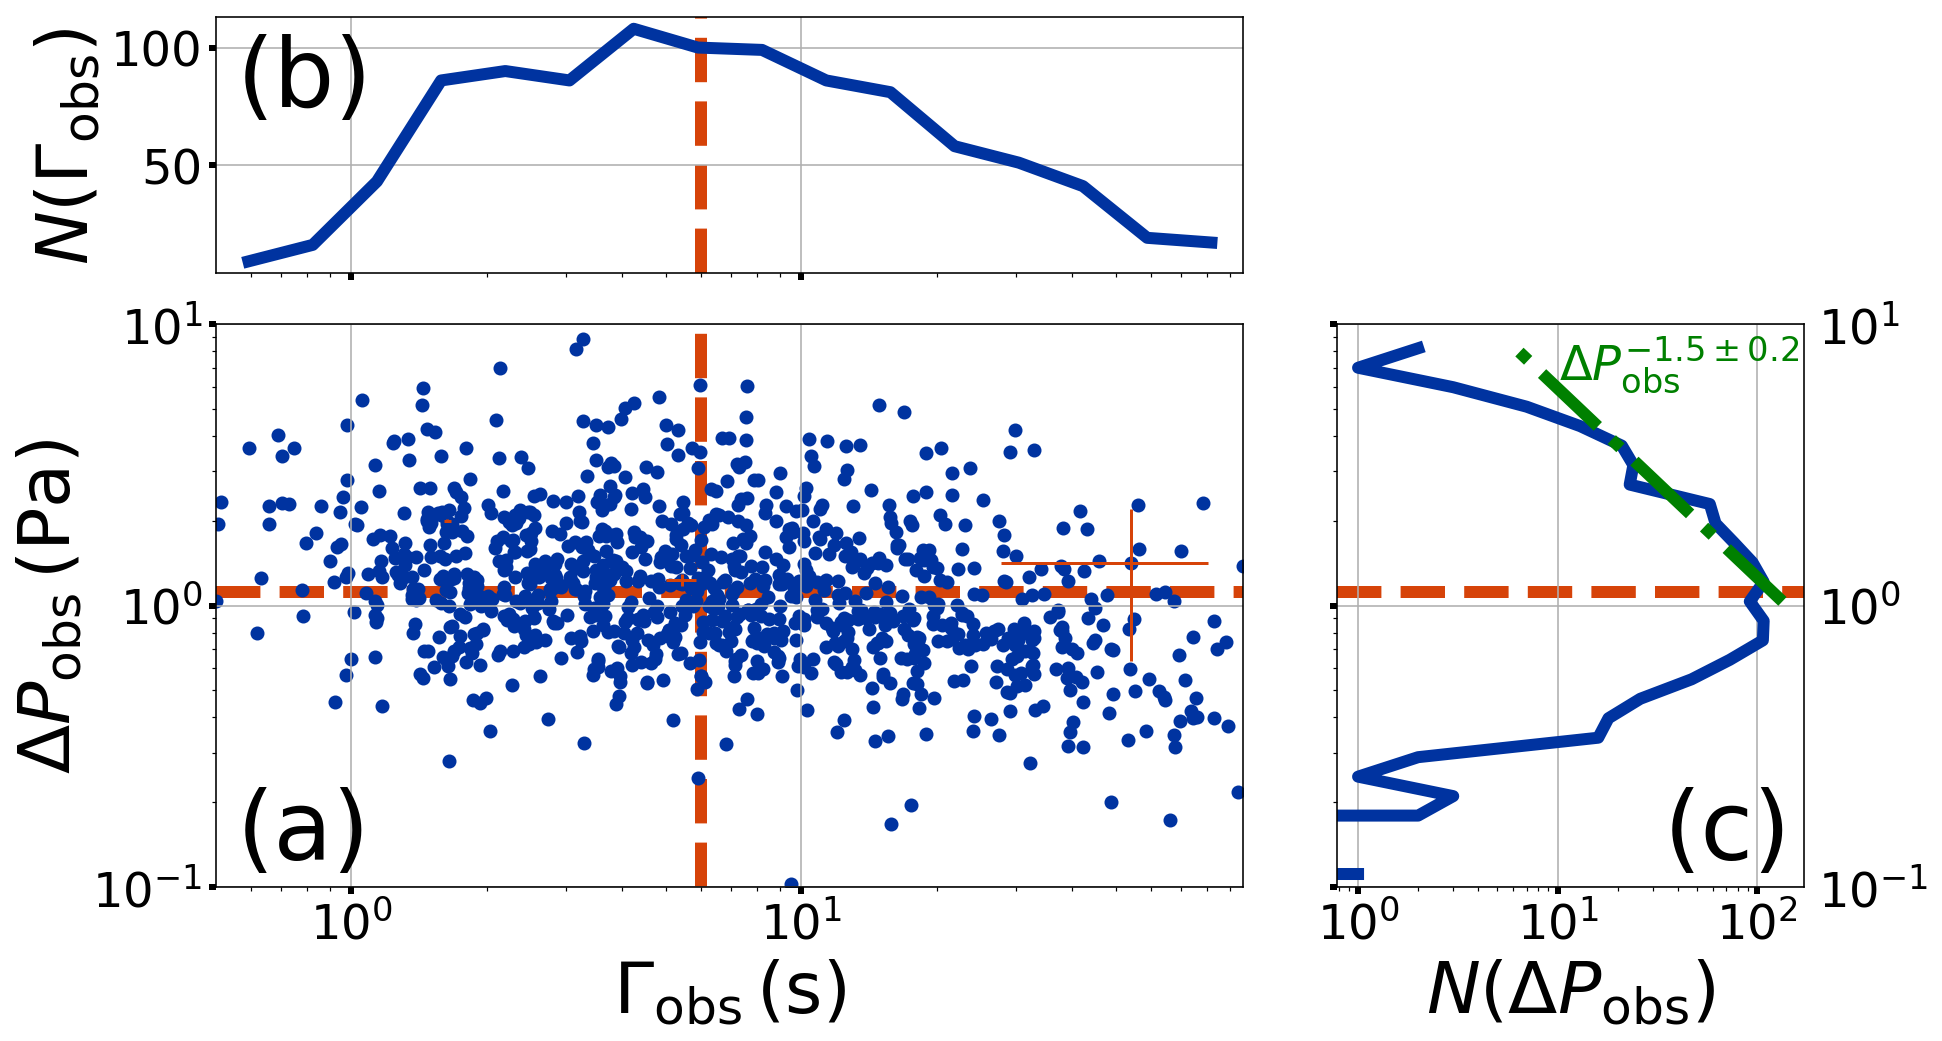

In [7]:
filename = "all_vortices.csv"
data = np.genfromtxt(filename, delimiter=',', names=True)
print("number of original vortices: ", len(data))

fig = plt.figure(figsize=(8*aspect_ratio, 8))
ax = fig.add_subplot(111)

# Toss the ones at either end
ind = (data['Gamma'] > Gamma_min) & (data['Gamma'] < Gamma_max) & (data['DeltaP'] > P_min)
x = data['Gamma'][ind]
y = data['DeltaP'][ind]
xerr = data['Gamma_unc'][ind]
yerr = data['DeltaP_unc'][ind]

Gammaobs_quantile = np.quantile(x, 0.5)
DeltaPobs_quantile = np.quantile(y, 0.5)
print("number of culled vortices: ", len(x))

print("Gammaobs_quantile, DeltaPobs_quantile: ", Gammaobs_quantile, DeltaPobs_quantile)

# print(len(x), len(data['Gamma']), len(data['Gamma']) - len(x))
# print(np.max(y), data['DeltaP_unc'][ind][np.argmax(y)], data['sol'][ind][np.argmax(y)])
# print(np.max(x), data['Gamma_unc'][ind][np.argmax(x)], data['sol'][ind][np.argmax(x)])
# print(Gammaobs_quantile, data['Gamma_unc'][ind][np.argmin(np.abs(Gammaobs_quantile - x))])
# print(DeltaPobs_quantile, data['DeltaP_unc'][ind][np.argmin(np.abs(DeltaPobs_quantile - y))])

### Create axes ###

ax = plt.subplot2grid((3,3), (1,0), colspan=2, rowspan=2)
ax_Gammahist = plt.subplot2grid((3,3), (0,0), colspan=2, sharex=ax)
ax_DeltaPhist = plt.subplot2grid((3,3), (1,2), rowspan=2, sharey=ax)

### Make scatterplot ###

ax.loglog(x, y, marker='o', ls='', color=BoiseState_blue, lw=6, zorder=0)
err_ind = np.argmax(np.sqrt(xerr**2 + yerr**2))
ax.errorbar(x[err_ind], y[err_ind], xerr=xerr[err_ind], yerr=yerr[err_ind], color=BoiseState_orange)
err_ind = np.argmin(np.sqrt(xerr**2 + yerr**2))
ax.errorbar(x[err_ind], y[err_ind], xerr=xerr[err_ind], yerr=yerr[err_ind], color=BoiseState_orange)
err_ind = np.argsort(np.sqrt(xerr**2 + yerr**2))[len(np.sqrt(xerr**2 + yerr**2))//2]
ax.errorbar(x[err_ind], y[err_ind], xerr=xerr[err_ind], yerr=yerr[err_ind], color=BoiseState_orange)

ax.axvline(Gammaobs_quantile, lw=6, ls='--', color=BoiseState_orange, zorder=-1)
ax.axhline(DeltaPobs_quantile, lw=6, ls='--', color=BoiseState_orange, zorder=-1)

### Make Gammaobs histogram ###

Gammaobs_hst, bin_edges = np.histogram(np.log10(x), bins='auto')
Gammaobs_bins = 0.5*(bin_edges[1:] + bin_edges[0:-1])
ax_Gammahist.semilogx(10.**Gammaobs_bins, Gammaobs_hst, lw=6, color=BoiseState_blue)

ax_Gammahist.axvline(Gammaobs_quantile, lw=6, ls='--', color=BoiseState_orange, zorder=-1)

### Make table of histogram values ###
tablefile = "Gamma_obs_histogram_table.csv"
f = open(tablefile, "w")
f.write("# Gamma_obs\n")
f.write("# bin_edges, histogram\n")
fmt1 = "%g, %g\n"
fmt2 = "%g, \n"
for i in range(len(bin_edges)):
    if(i < len(bin_edges) - 1):
        f.write(fmt1 % (bin_edges[i], Gammaobs_hst[i]))
    else:
        f.write(fmt2 % bin_edges[i])
        
f.close()

### Make Delta Pobs histogram ###

Pobs_hst, bin_edges = np.histogram(np.log10(y), bins='auto')
Pobs_bins = 0.5*(bin_edges[1:] + bin_edges[0:-1])

ax_DeltaPhist.semilogx(Pobs_hst, 10.**Pobs_bins, lw=6, color=BoiseState_blue)

ax_DeltaPhist.axhline(DeltaPobs_quantile, lw=6, ls='--', color=BoiseState_orange, zorder=-1)

### Make table of histogram values ###
tablefile = "DeltaP_obs_histogram_table.csv"
f = open(tablefile, "w")
f.write("# DeltaP_obs\n")
f.write("# bin_edges, histogram\n")
fmt1 = "%g, %g\n"
fmt2 = "%g, \n"
for i in range(len(bin_edges)):
    if(i < len(bin_edges) - 1):
        f.write(fmt1 % (bin_edges[i], Pobs_hst[i]))
    else:
        f.write(fmt2 % bin_edges[i])
        
f.close()

### Fit Delta Pobs hist with power-law ###

mx_ind = np.argmin(np.abs(DeltaPobs_quantile - 10.**Pobs_bins))
err = np.sqrt(Pobs_hst)/(np.log(10.)*Pobs_hst)

# err = np.ones_like(hst)
popt, pcov = curve_fit(line, Pobs_bins[mx_ind:], np.log10(Pobs_hst[mx_ind:]), sigma=err[mx_ind:])
uncertainties = np.diag(np.sqrt(pcov))
ax_DeltaPhist.semilogx(10.**np.polyval(popt, Pobs_bins[mx_ind:]), 10.**Pobs_bins[mx_ind:], 
                       ls='-.', lw=6, color='green')

### Tweak and label axes

ax_DeltaPhist.text(0.475, 0.9, r'$\Delta P_{\rm obs}^{%.2g\pm%.1g}$' % (popt[0], uncertainties[0]), 
                   fontsize=24, transform=ax_DeltaPhist.transAxes, color='green')

ax.grid(True)
ax_Gammahist.grid(True)
ax_DeltaPhist.grid(True)
ax.tick_params(labelsize=24)
ax_Gammahist.tick_params(labelbottom=False, labelsize=24)
ax_DeltaPhist.tick_params(labelleft=False, labelright=True, labelsize=24)

ax.set_xlabel(r'$\Gamma_{\rm obs}\,\left( {\rm s} \right)$', fontsize=36)
ax.set_ylabel(r'$\Delta P_{\rm obs}\,\left( {\rm Pa} \right)$', fontsize=36)
ax_DeltaPhist.set_xlabel(r'$N\left(\Delta P_{\rm obs}\right)$', fontsize=36)
ax_Gammahist.set_ylabel(r'$N\left(\Gamma_{\rm obs}\right)$', fontsize=36)

ax.text(0.02, 0.05, "(a)", fontsize=48, transform=ax.transAxes)
ax_Gammahist.text(0.02, 0.65, "(b)", fontsize=48, transform=ax_Gammahist.transAxes)
ax_DeltaPhist.text(0.7, 0.05, "(c)", fontsize=48, transform=ax_DeltaPhist.transAxes)

ax.set_xlim([np.min(x), np.max(x)])
ax.set_ylim([0.1, 10])

# fig.savefig("../figures/DeltaPobs_vs_Gammaobs.png", dpi=500, bbox_inches="tight")

number of original vortices:  1034
number of culled vortices:  990
Gammaobs_quantile, DeltaPobs_quantile:  5.991664999999999 1.1151550000000001


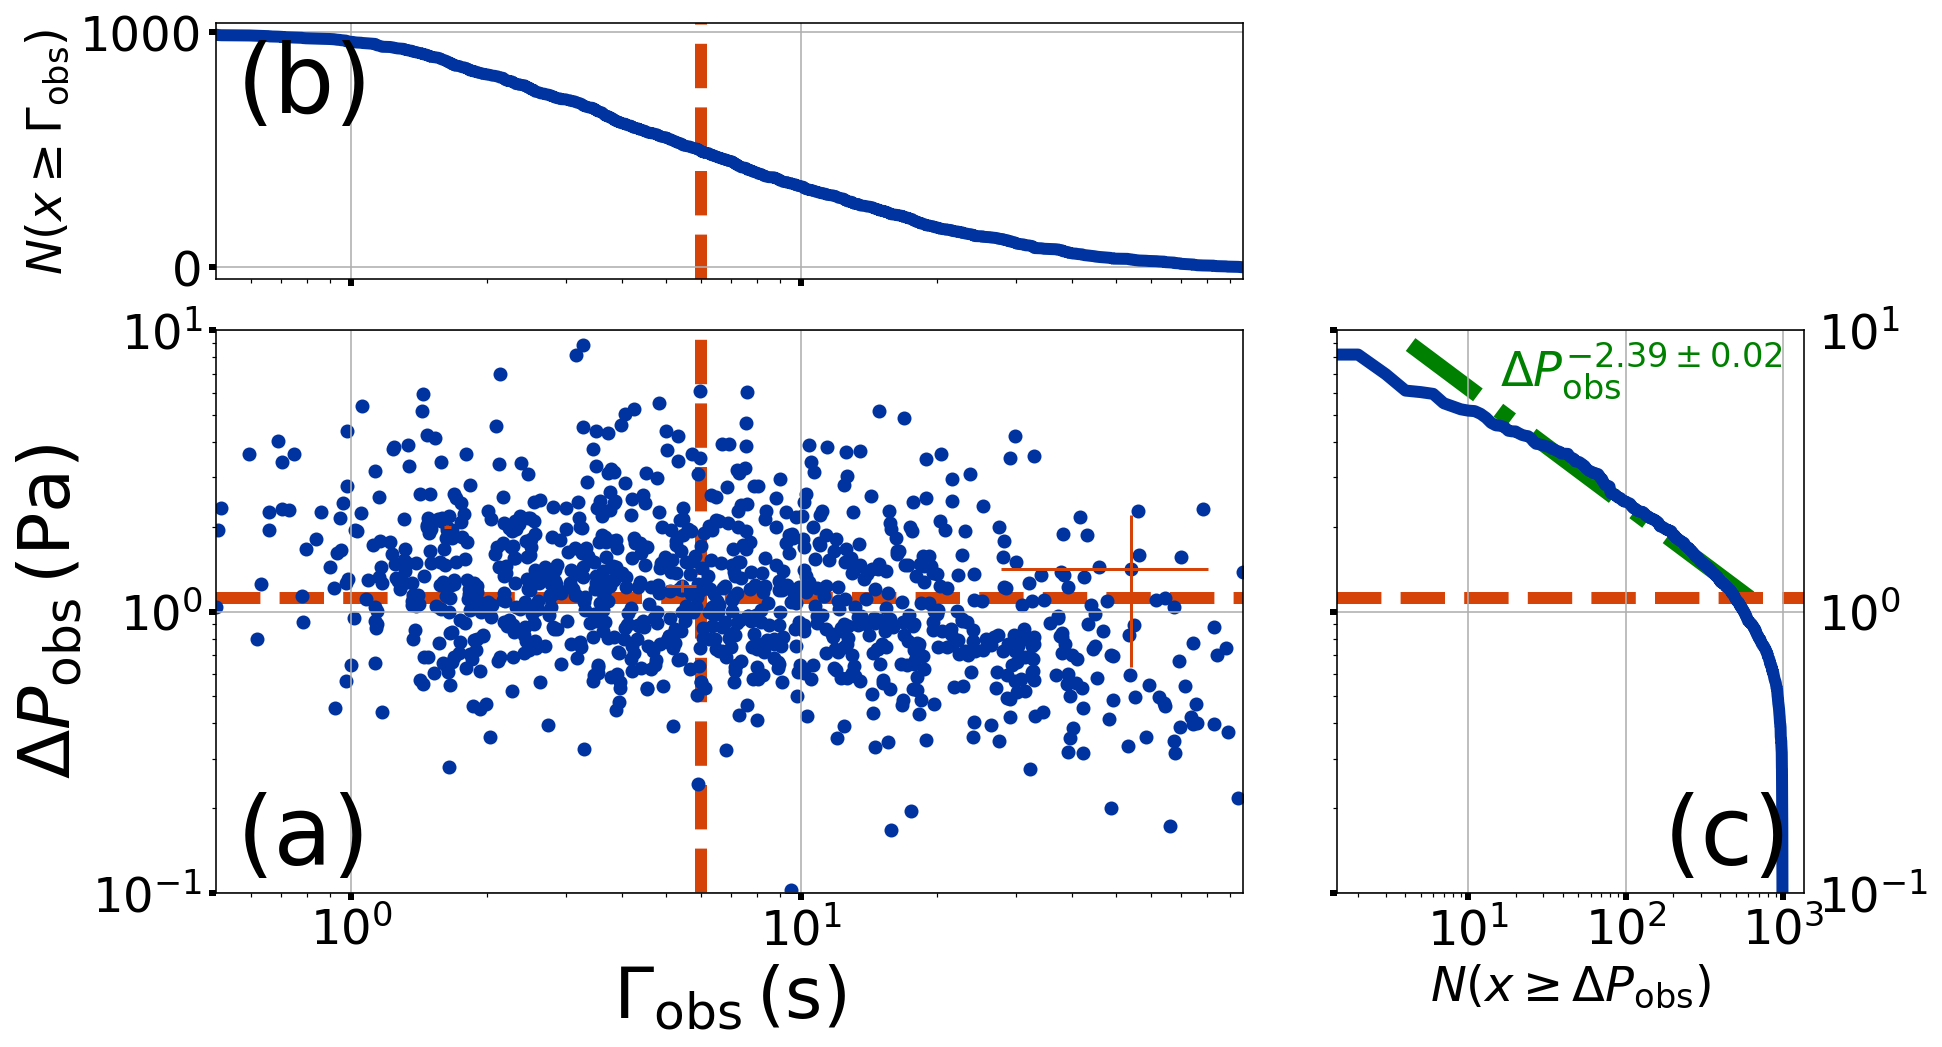

In [9]:
# Change to cumulative histogram
filename = "all_vortices.csv"
data = np.genfromtxt(filename, delimiter=',', names=True)

print("number of original vortices: ", len(data))

fig = plt.figure(figsize=(8*aspect_ratio, 8))
ax = fig.add_subplot(111)

# Toss the ones at either end
ind = (data['Gamma'] > Gamma_min) & (data['Gamma'] < Gamma_max) & (data['DeltaP'] > P_min)
x = data['Gamma'][ind]
y = data['DeltaP'][ind]
xerr = data['Gamma_unc'][ind]
yerr = data['DeltaP_unc'][ind]

Gammaobs_quantile = np.quantile(x, 0.5)
DeltaPobs_quantile = np.quantile(y, 0.5)
print("number of culled vortices: ", len(x))

print("Gammaobs_quantile, DeltaPobs_quantile: ", Gammaobs_quantile, DeltaPobs_quantile)

### Create axes ###

ax = plt.subplot2grid((3,3), (1,0), colspan=2, rowspan=2)
ax_Gammahist = plt.subplot2grid((3,3), (0,0), colspan=2, sharex=ax)
ax_DeltaPhist = plt.subplot2grid((3,3), (1,2), rowspan=2, sharey=ax)

### Make scatterplot ###

ax.loglog(x, y, marker='o', ls='', color=BoiseState_blue, lw=6, zorder=0)
err_ind = np.argmax(np.sqrt(xerr**2 + yerr**2))
ax.errorbar(x[err_ind], y[err_ind], xerr=xerr[err_ind], yerr=yerr[err_ind], color=BoiseState_orange)
err_ind = np.argmin(np.sqrt(xerr**2 + yerr**2))
ax.errorbar(x[err_ind], y[err_ind], xerr=xerr[err_ind], yerr=yerr[err_ind], color=BoiseState_orange)
err_ind = np.argsort(np.sqrt(xerr**2 + yerr**2))[len(np.sqrt(xerr**2 + yerr**2))//2]
ax.errorbar(x[err_ind], y[err_ind], xerr=xerr[err_ind], yerr=yerr[err_ind], color=BoiseState_orange)

ax.axvline(Gammaobs_quantile, lw=6, ls='--', color=BoiseState_orange, zorder=-1)
ax.axhline(DeltaPobs_quantile, lw=6, ls='--', color=BoiseState_orange, zorder=-1)

### Make Gammaobs histogram ###

srt = np.argsort(x)
log_Gammaobs = np.log10(x)[srt]
hst, _ = np.histogram(log_Gammaobs, bins=[-np.inf, *log_Gammaobs])
log_Gammaobs_cum_hst = len(log_Gammaobs) - np.cumsum(hst)

ax_Gammahist.semilogx(10.**log_Gammaobs, log_Gammaobs_cum_hst, lw=6, color=BoiseState_blue)

### Make table of histogram values ###

# tablefile = "Gamma_obs_histogram_table.csv"
# f = open(tablefile, "w")
# f.write("# Gamma_obs\n")
# f.write("# bin_edges, histogram\n")
# fmt1 = "%g, %g\n"
# fmt2 = "%g, \n"
# for i in range(len(bin_edges)):
#     if(i < len(bin_edges) - 1):
#         f.write(fmt1 % (bin_edges[i], Gammaobs_hst[i]))
#     else:
#         f.write(fmt2 % bin_edges[i])
        
# f.close()

### Make Delta Pobs histogram ###

srt = np.argsort(y)
log_DeltaPobs = np.log10(y)[srt]
hst, _ = np.histogram(log_DeltaPobs, bins=[-np.inf, *log_DeltaPobs])
log_DeltaPobs_cum_hst = len(log_DeltaPobs) - np.cumsum(hst)
err = np.sqrt(np.log10(log_DeltaPobs_cum_hst))/(np.log(10.)*np.log10(log_DeltaPobs_cum_hst))

ax_DeltaPhist.loglog(log_DeltaPobs_cum_hst, 10.**log_DeltaPobs, lw=6, color=BoiseState_blue)
# ax_DeltaPhist.errorbar(log_DeltaPobs_cum_hst, 10.**log_DeltaPobs, 
#                        xerr=err, color=BoiseState_blue)

### Make table of histogram values ###
# tablefile = "DeltaP_obs_histogram_table.csv"
# f = open(tablefile, "w")
# f.write("# DeltaP_obs\n")
# f.write("# bin_edges, histogram\n")
# fmt1 = "%g, %g\n"
# fmt2 = "%g, \n"
# for i in range(len(bin_edges)):
#     if(i < len(bin_edges) - 1):
#         f.write(fmt1 % (bin_edges[i], Pobs_hst[i]))
#     else:
#         f.write(fmt2 % bin_edges[i])
        
# f.close()

### Fit Delta Pobs hist with power-law ###

# mx_ind = np.argmin(np.abs(DeltaPobs_quantile - 10.**Pobs_bins))

# Only fit the values above the 50% quintile
srt = np.argsort(y)
log_DeltaPobs = np.log10(y)[srt]
log_DeltaPobs = log_DeltaPobs[log_DeltaPobs > np.log10(DeltaPobs_quantile)]
hst, _ = np.histogram(log_DeltaPobs, bins=[-np.inf, *log_DeltaPobs])
log_DeltaPobs_cum_hst = len(log_DeltaPobs) - np.cumsum(hst)
err = np.sqrt(np.log10(log_DeltaPobs_cum_hst))/(np.log(10.)*np.log10(log_DeltaPobs_cum_hst))
ind = np.isfinite(err)

popt, pcov = curve_fit(line, log_DeltaPobs[ind], np.log10(log_DeltaPobs_cum_hst[ind]))
uncertainties = np.diag(np.sqrt(pcov))
ax_DeltaPhist.plot(10.**np.polyval(popt, log_DeltaPobs), 10.**log_DeltaPobs, 
                       ls='-.', lw=8, color='green', zorder=-1)

### Tweak and label axes
ax_DeltaPhist.text(0.35, 0.9, r'$\Delta P_{\rm obs}^{%.2f\pm%.2f}$' % (popt[0], uncertainties[0]), 
                   fontsize=24, transform=ax_DeltaPhist.transAxes, color='green')

ax.grid(True)
ax_Gammahist.grid(True)
ax_DeltaPhist.grid(True)
ax.tick_params(labelsize=24)
ax_Gammahist.tick_params(labelbottom=False, labelsize=24)
ax_DeltaPhist.tick_params(labelleft=False, labelright=True, labelsize=24)

ax.set_xlabel(r'$\Gamma_{\rm obs}\,\left( {\rm s} \right)$', fontsize=36)
ax.set_ylabel(r'$\Delta P_{\rm obs}\,\left( {\rm Pa} \right)$', fontsize=36)
ax_DeltaPhist.set_xlabel(r'$N\left(x \geq \Delta P_{\rm obs}\right)$', fontsize=24)
ax_Gammahist.set_ylabel(r'$N\left(x \geq \Gamma_{\rm obs}\right)$', fontsize=24)

ax.text(0.02, 0.05, "(a)", fontsize=48, transform=ax.transAxes)
ax_Gammahist.text(0.02, 0.65, "(b)", fontsize=48, transform=ax_Gammahist.transAxes)
ax_DeltaPhist.text(0.7, 0.05, "(c)", fontsize=48, transform=ax_DeltaPhist.transAxes)

ax.set_xlim([np.min(x), np.max(x)])
ax.set_ylim([0.1, 10])

ax_Gammahist.axvline(Gammaobs_quantile, lw=6, ls='--', color=BoiseState_orange, zorder=-1)
ax_DeltaPhist.axhline(DeltaPobs_quantile, lw=6, ls='--', color=BoiseState_orange, zorder=-1)

# fig.savefig("../figures/DeltaPobs_vs_Gammaobs.png", dpi=500, bbox_inches="tight")

[-1.74684654  3.34231275]


Text(0, 0.5, '$N$')

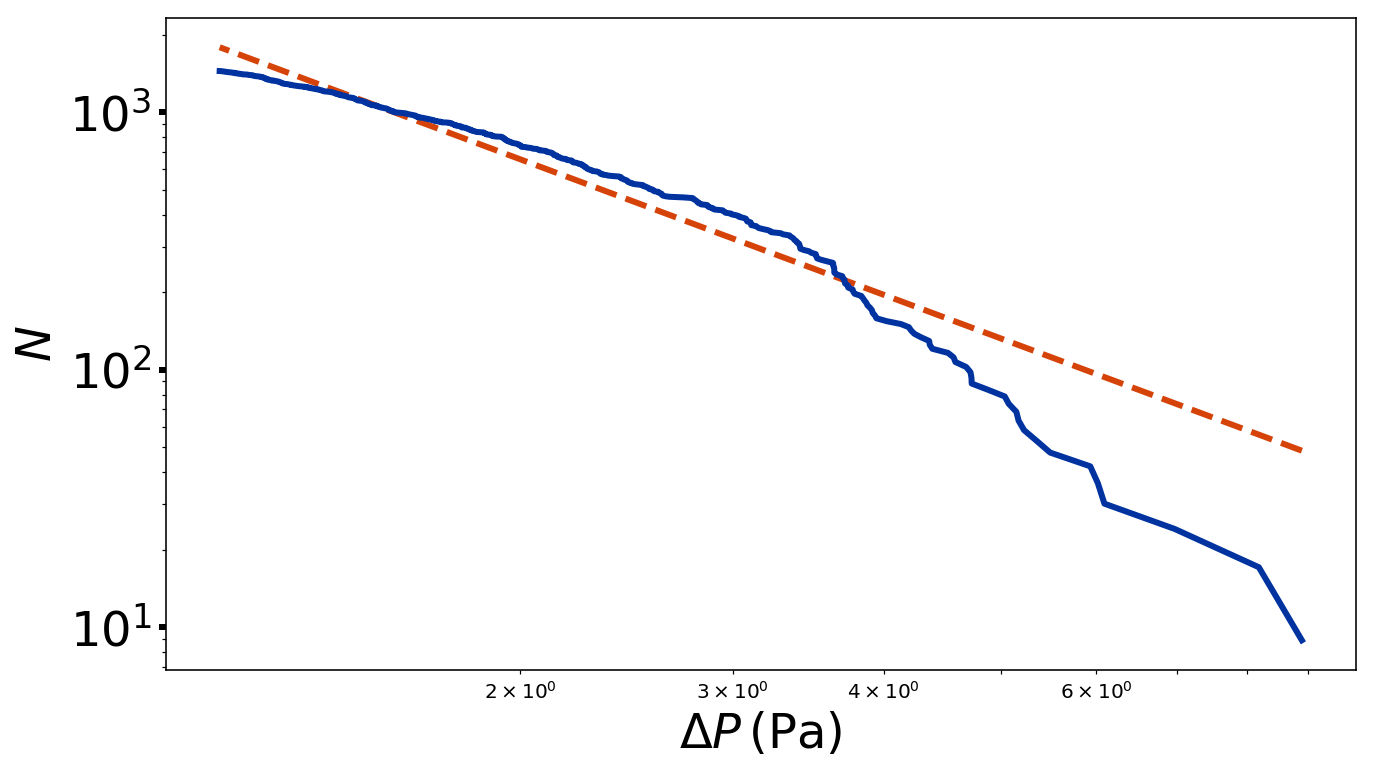

In [92]:
# Cumulative histogram of Delta Pobs
fig = plt.figure(figsize=(6*aspect_ratio, 6))
ax = fig.add_subplot(111)

filename = "all_vortices_2020Aug9.csv"
data = np.genfromtxt(filename, delimiter=',', names=True)

# Toss the ones at either end
ind = (data['Gamma'] > Gamma_min) & (data['Gamma'] < Gamma_max) & (data['DeltaP'] > P_min)

DeltaP = data['DeltaP'][ind]

DeltaPobs_quantile = np.quantile(DeltaP, 0.5)
ind = DeltaP > DeltaPobs_quantile
DeltaP = DeltaP[ind]

srt = np.argsort(DeltaP)[::-1]
DeltaP = DeltaP[srt]

cum_hst = np.cumsum(DeltaP)
x = DeltaP
y = cum_hst
yerr = np.sqrt(np.log10(y))/(np.log(10.)*np.log10(y))

ax.loglog(x, y, lw=3, color=BoiseState_blue)

# popt, pcov = curve_fit(line, np.log10(x), np.log10(y), sigma=yerr)
# uncertainties = np.sqrt(np.diag(pcov))
# print(popt)
# print(uncertainties)

fit_params = np.polyfit(np.log10(x), np.log10(y), 1)
print(fit_params)
ax.loglog(x, 10**np.polyval(fit_params, np.log10(x)), ls='--', lw=3, color=BoiseState_orange, zorder=-1)

# ax.text(0.05, 0.05, r'$\gamma = %.1f\pm%.1f$' % (popt[0], uncertainties[0]), 
#         transform=ax.transAxes, fontsize=24, color='green')

# ax.text(0.05, 0.15, r'$\gamma - 1 = %.2g$' % (fit_params[0] - 1.), 
#         transform=ax.transAxes, fontsize=24, color=BoiseState_orange)
ax.tick_params(labelsize=24)
ax.set_xlabel(r'$\Delta P\,\left({\rm Pa}\right)$', fontsize=24)
ax.set_ylabel(r'$N$', fontsize=24)

<Figure size 768x432 with 0 Axes>

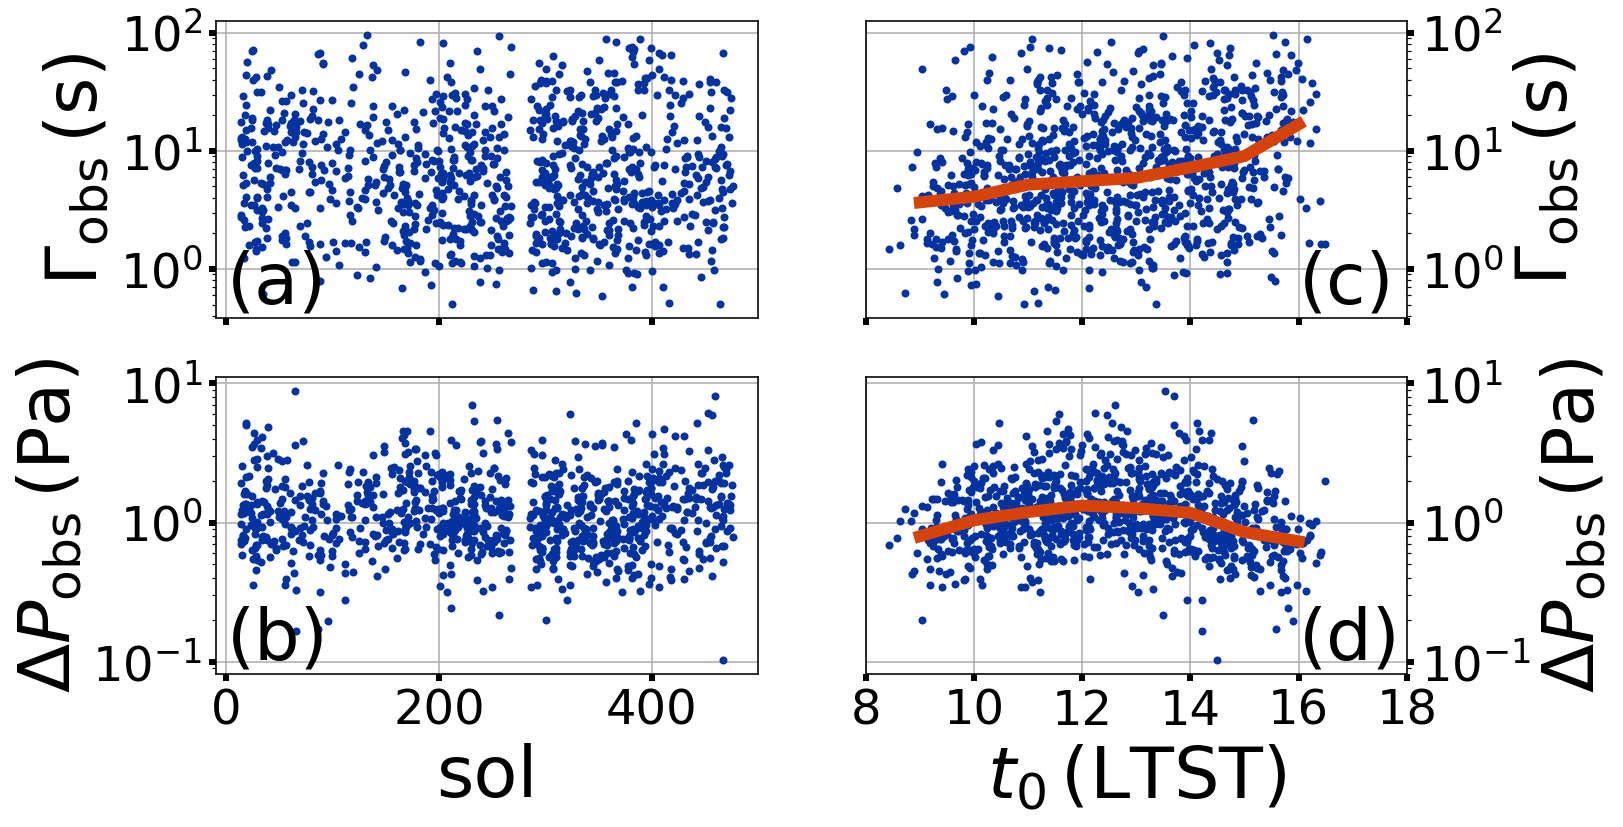

In [62]:
fig = plt.figure(figsize=(6*aspect_ratio, 6), constrained_layout=True)

filename = "all_vortices.csv"
data = np.genfromtxt(filename, delimiter=',', names=True)

# Toss the ones at either end
ind = (data['Gamma'] > Gamma_min) & (data['Gamma'] < Gamma_max) & (data['DeltaP'] > P_min)

### Plot by sol ###

sols = data['sol'][ind]
x = data['Gamma'][ind]
y = data['DeltaP'][ind]
xerr = data['Gamma_unc'][ind]
yerr = data['DeltaP_unc'][ind]

bins = int(max(sols) - min(sols))

fig = plt.figure(figsize=(6*aspect_ratio, 6))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(223)

ax1.semilogy(sols, x, marker='.', color=BoiseState_blue, ls='')
# rng = np.arange(np.floor(np.min(sols)), np.ceil(np.max(sols)), 1)
# inds = np.digitize(sols, rng)
# unq = np.unique(inds)
# sav_sols = np.array([])
# sols_meds = np.array([])
# for i in range(len(unq)):
#     where_ind = np.where(inds == unq[i])
#     if(len(x[where_ind[0]]) > 0):
#         sav_sols = np.append(sav_sols, sols[where_ind[0]][0])
#         sols_meds = np.append(sols_meds, np.median(np.log10(x[where_ind[0]])))
# ax1.plot(sav_sols, 10.**sols_meds, color=BoiseState_orange, lw=1, alpha=0.5)

ax2.semilogy(sols, y, marker='.', color=BoiseState_blue, ls='')
# sav_sols = np.array([])
# sols_meds = np.array([])
# for i in range(len(unq)):
#     where_ind = np.where(inds == unq[i])
#     if(len(x[where_ind[0]]) > 0):
#         sav_sols = np.append(sav_sols, sols[where_ind[0]][0])
#         sols_meds = np.append(sols_meds, np.median(np.log10(y[where_ind[0]])))
# ax2.plot(sav_sols, 10.**sols_meds, color=BoiseState_orange, lw=1, alpha=0.5)

ax1.grid(True)
ax1.tick_params(labelbottom=False, labelsize=24)
ax1.set_ylabel(r'$\Gamma_{\rm obs}\,\left( {\rm s} \right)$', fontsize=36)

ax2.grid(True)
ax2.tick_params(labelsize=24)
ax2.set_xlabel('sol', fontsize=36)
ax2.set_ylabel(r'$\Delta P_{\rm obs}\,\left( {\rm Pa} \right)$', fontsize=36)

ax1.text(0.02, 0.05, "(a)", fontsize=36, transform=ax1.transAxes)
ax2.text(0.02, 0.05, "(b)", fontsize=36, transform=ax2.transAxes)

### Plot by time-of-day ###

TOD = data['t0'][ind]
x = data['Gamma'][ind]
y = data['DeltaP'][ind]
xerr = data['Gamma_unc'][ind]
yerr = data['DeltaP_unc'][ind]

ax3 = fig.add_subplot(222, sharey=ax1)
ax4 = fig.add_subplot(224, sharex=ax3, sharey=ax2)

ax3.semilogy(TOD, x, marker='.', color=BoiseState_blue, ls='')

### Median by TOD ###

rng = np.arange(np.floor(np.min(TOD)) - 0.5, np.ceil(np.max(TOD)) + 0.5, 1)
sav_TOD = np.array([])
TOD_meds = np.array([])
TOD_mads = np.array([])

# inds = np.digitize(TOD, rng)
# unq = np.unique(inds)
# for i in range(len(unq)):
#     where_ind = np.where(inds == unq[i])
#     if(len(x[where_ind[0]]) > 0):
#         sav_TOD = np.append(sav_TOD, TOD[where_ind[0]][0])
#         TOD_meds = np.append(TOD_meds, np.median(x[where_ind[0]]))
#         TOD_mads = np.append(TOD_mads, mad(x[where_ind[0]])/np.sqrt(len(x[where_ind[0]]) - 1.))
# ax3.semilogy(sav_TOD, TOD_meds, color=BoiseState_orange, lw=6)
# popt, pcov = curve_fit(line, sav_TOD, TOD_meds, sigma=TOD_mads)
# uncertainties = np.sqrt(np.diag(pcov))
# print("np.min(TOD_meds), np.max(TOD_meds): ", np.min(TOD_meds), np.max(TOD_meds))
# print("popt: ", popt)
# print("uncertainties: ", uncertainties)
# print("sav_TOD: ", sav_TOD)

for i in range(len(rng)-1):
    ind = (TOD >= rng[i]) & (TOD < rng[i+1])
    if(len(x[ind]) > 3):
        sav_TOD = np.append(sav_TOD, 0.5*(rng[i] + rng[i+1]))
        TOD_meds = np.append(TOD_meds, np.median(x[ind]))
ax3.semilogy(sav_TOD, TOD_meds, color=BoiseState_orange, lw=6)

Gamma_TOD = sav_TOD
Gamma_meds = TOD_meds

ax4.semilogy(TOD, y, marker='.', color=BoiseState_blue, ls='')

### Median by TOD ###

sav_TOD = np.array([])
TOD_meds = np.array([])
TOD_mads = np.array([])
# for i in range(len(unq)):
#     where_ind = np.where(inds == unq[i])
#     if(len(x[where_ind[0]]) > 0):
#         sav_TOD = np.append(sav_TOD, TOD[where_ind[0]][0])
#         TOD_meds = np.append(TOD_meds, np.median(y[where_ind[0]]))
#         TOD_mads = np.append(TOD_mads, mad(y[where_ind[0]])/np.sqrt(len(y[where_ind[0]]) - 1.))

for i in range(len(rng)-1):
    ind = (TOD >= rng[i]) & (TOD < rng[i+1])
    if(len(x[ind]) > 3):
        sav_TOD = np.append(sav_TOD, 0.5*(rng[i] + rng[i+1]))
        TOD_meds = np.append(TOD_meds, np.median(y[ind]))

ax4.semilogy(sav_TOD, TOD_meds, color=BoiseState_orange, lw=6)

# Checking that the values of Delta P at either end of the TOD plot are statistically equivalent.
mx_ind = np.argmax(TOD_meds)
# print("sav_TOD[mx_ind], TOD_meds[mx_ind], TOD_mads[mx_ind]: ", sav_TOD[mx_ind], TOD_meds[mx_ind], TOD_mads[mx_ind])
# print("TOD_meds[0], TOD_mads[0]: ", TOD_meds[0], TOD_mads[0])
# print("TOD_meds[-1], TOD_mads[-1]: ", TOD_meds[-1], TOD_mads[-1])
# print("(TOD_meds[mx_ind] - np.min(TOD_meds))/np.sqrt(TOD_mads[mx_ind]**2 + np.min(TOD_mads)**2): ", 
#       (TOD_meds[mx_ind] - np.min(TOD_meds))/np.sqrt(TOD_mads[mx_ind]**2 + np.min(TOD_mads)**2))

ax3.grid(True)
ax3.tick_params(labelbottom=False, labelsize=24)
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()
ax3.set_xticks([8, 10, 12, 14, 16, 18])

ax4.grid(True)
ax4.yaxis.set_label_position("right")
ax4.yaxis.tick_right()
ax4.tick_params(labelright=True, labelleft=False, labelsize=24)
ax4.set_xticks([8, 10, 12, 14, 16, 18])

ax3.set_ylabel(r'$\Gamma_{\rm obs}\,\left( {\rm s} \right)$', fontsize=36)
ax4.set_xlabel(r'$t_0\,\left({\rm LTST}\right)$', fontsize=36)
ax4.set_ylabel(r'$\Delta P_{\rm obs}\,\left( {\rm Pa} \right)$', fontsize=36)

ax3.text(0.8, 0.05, "(c)", fontsize=36, transform=ax3.transAxes)
ax4.text(0.8, 0.05, "(d)", fontsize=36, transform=ax4.transAxes)

# ax2.set_yticks([0, 5, 10])
# ax4.set_yticks([0, 5, 10])

fig.savefig("../figures/Gammaobs_DeltaPobs_vs_TOD_and_sol.png", dpi=500, bbox_inches="tight")

In [3]:
# 2020 Dec 4 - Figure out during how many sols were observed by the pressure logger during each hour of the day
#   and what was the average windspeed during each sol and each hour of each sol.
binsize = 1
hourly_bin_edges = np.arange(0, 25, binsize)
print_str = "sol, median_wind"
for cur_edge in hourly_bin_edges[0:-1]:
    print_str += (", %d_median_wind, %d_hour_fraction" % (cur_edge, cur_edge))

text_file = open("sols_hour_median_winds.csv", "w")
# print(print_str)
text_file.write(print_str + "\n")

all_sols = np.arange(14, 477)
for cur_sol in all_sols:
    
    try:
        wind_LTST, wind_LTST_and_sol, wind_data = find_wind(cur_sol, dr_wind=dr_wind)
        daily_med_wind = np.nanmedian(wind_data["HORIZONTAL_WIND_SPEED"])

        print_str = "%d, %g" % (cur_sol, daily_med_wind)

        for cur_edge in hourly_bin_edges[0:-1]:
            ind = (wind_LTST >= cur_edge) & (wind_LTST < cur_edge + binsize)
            
            cur_print_str = ", , "
        
            if(len(wind_LTST[ind]) > 1):
                
                # I'm assuming that I observe through the whole hour.
                mn = np.min(wind_LTST[ind])
                mx = np.max(wind_LTST[ind])

                frac = (mx - mn)/binsize
                hourly_med_wind = np.nanmedian(wind_data["HORIZONTAL_WIND_SPEED"][ind])
                
                cur_print_str = (", %g, %g" % (hourly_med_wind, frac))
            else:
                cur_print_str = (", %g, %g" % (0., 0.))
                
            print_str += cur_print_str
                
#         print(print_str)
        text_file.write(print_str + "\n")
    except:
        pass
    
text_file.close()

31 doesn't have windspeed data!
93 doesn't have windspeed data!
109 doesn't have windspeed data!
110 doesn't have windspeed data!
111 doesn't have windspeed data!
121 doesn't have windspeed data!
122 doesn't have windspeed data!
270 doesn't have windspeed data!
271 doesn't have windspeed data!
272 doesn't have windspeed data!
273 doesn't have windspeed data!
274 doesn't have windspeed data!
275 doesn't have windspeed data!
276 doesn't have windspeed data!
277 doesn't have windspeed data!
278 doesn't have windspeed data!
279 doesn't have windspeed data!
280 doesn't have windspeed data!
281 doesn't have windspeed data!
282 doesn't have windspeed data!
283 doesn't have windspeed data!


In [3]:
# 2021 Jan 6 (Day 1 of trump's Insurrection) - I recorded the fraction of each hour for each sol during which
#   pressure logger data were recorded.

data_file = np.genfromtxt("sols_hour_median_winds.csv", delimiter=',', names=True)
def hour_frac(hour, sol):
    sol_ind = data_file['sol'] == sol
    hour_key = str(hour) + "_hour_fraction"
    
    return data_file[hour_key][sol_ind]

def how_many_hours(hour):
    # During most sols, all 24 hours are observed completely. But during some, only a fraction of an hour is observed.
    # This routine totals up the fraction of a particular hour was observed across all sols.
    # 
    # For example, on sol 422, 0% of the hour between 1 and 2 LTST was observed. On sol 423, 100% was observed.
    # If these were the only two sols on which that hour was observed, it would have been observed for a total of 
    # 1 hour.
    
    hour_key = str(hour) + "_hour_fraction"
    return np.sum(data_file[hour_key])

print(how_many_hours(12))

430.196052


<Figure size 768x432 with 0 Axes>

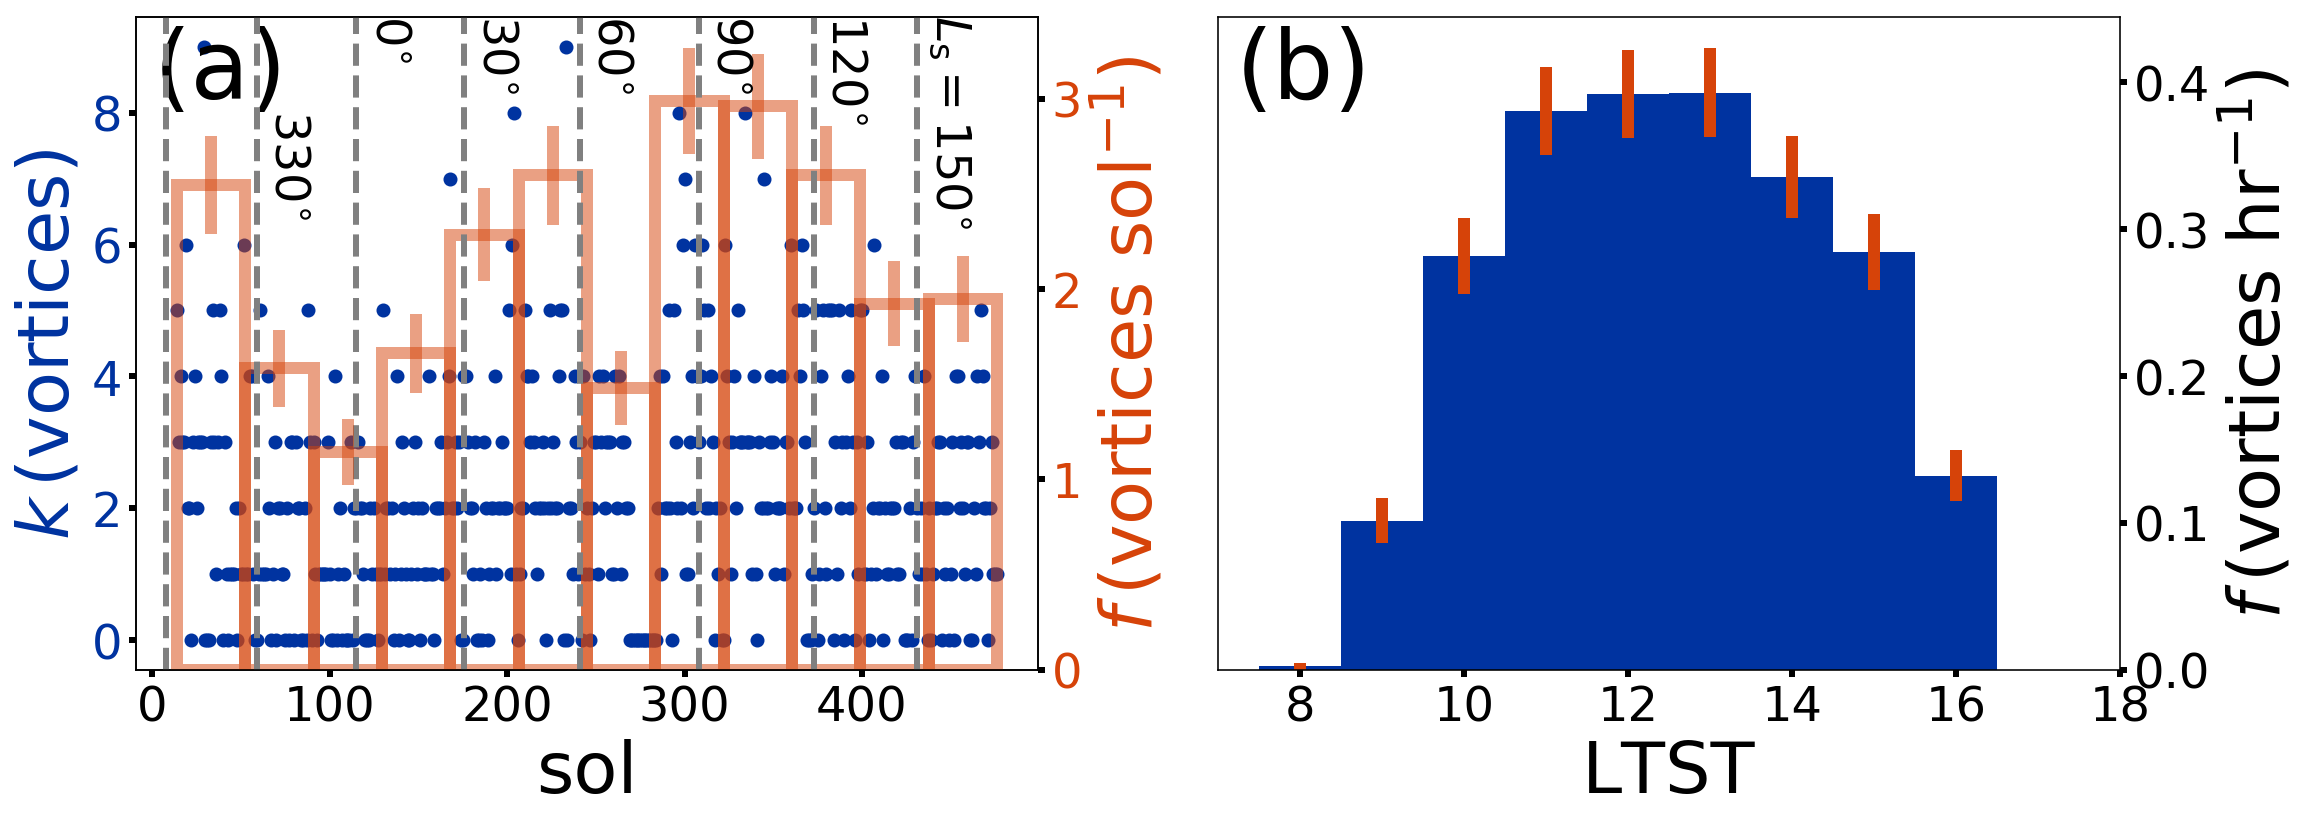

In [22]:
fig = plt.figure(figsize=(6*aspect_ratio, 6), constrained_layout=True)

filename = "all_vortices.csv"
data = np.genfromtxt(filename, delimiter=',', names=True)

# Toss the ones at either end
ind = (data['Gamma'] > Gamma_min) & (data['Gamma'] < Gamma_max) & (data['DeltaP'] > P_min)

### Plot by sol ###

sols = data['sol'][ind]
x = data['Gamma'][ind]
y = data['DeltaP'][ind]
xerr = data['Gamma_unc'][ind]
yerr = data['DeltaP_unc'][ind]

bins = np.arange(np.floor(np.min(sols)) - 0.5, np.ceil(np.max(sols)) + 1.5, 1)

fig = plt.figure(figsize=(10*aspect_ratio, 6))

ax1 = fig.add_subplot(121)
ax3 = ax1.twinx()
ax2 = fig.add_subplot(122)

hst, bin_edges = np.histogram(sols, bins=bins)
bins = 0.5*(bin_edges[1:] + bin_edges[0:-1])
srt = np.argsort(hst)[::-1]
ax1.plot(bins, hst, marker='o', color=BoiseState_blue, ls='', zorder=1)
# ax1.errorbar(bins, hst, yerr=yerr, color=BoiseState_blue, ls='', zorder=1)

hst, bin_edges = np.histogram(sols, bins='auto')
bins = 0.5*(bin_edges[1:] + bin_edges[0:-1])
binsize = np.median(bins[1:] - bins[0:-1])
yerr = np.sqrt(hst)/binsize

# print(bin_edges)
# print(hst)
ax3.bar(bins, hst/binsize, width=binsize, edgecolor=BoiseState_orange, color='None', lw=6, alpha=0.5, zorder=-1)
err_ind = hst > 0.
ax3.errorbar(bins[err_ind], hst[err_ind]/binsize, yerr=yerr[err_ind], ls='', color=BoiseState_orange, alpha=0.5, lw=6)

# print("several sols binned: ", binsize)
# print("# per sol: ", np.min(hst/binsize), np.max(hst/binsize))
# yerr = np.sqrt(hst/binsize)
# ax3.errorbar(bins, hst/binsize, yerr=yerr, color=BoiseState_orange, ls='', lw=6, zorder=-1, alpha=0.5)

### Plot by time-of-day ###

TOD = data['t0'][ind]
x = data['Gamma'][ind]
y = data['DeltaP'][ind]
xerr = data['Gamma_unc'][ind]
yerr = data['DeltaP_unc'][ind]

binsize = 1.
bins = np.arange(np.floor(np.min(TOD)) - 0.5*binsize, np.ceil(np.max(TOD)) + 1. + 0.5*binsize, binsize)
# hst, bin_edges = np.histogram(TOD, bins=bins)
# hst, bin_edges, patches = ax2.hist(TOD, bins=bins, color=BoiseState_blue, lw=6)
all_hst, bin_edges = np.histogram(TOD, bins=bins)
hst = np.zeros_like(all_hst)
yerr = np.zeros_like(all_hst)

hst = hst.astype(float)
yerr = yerr.astype(float)
# 2020 Oct 9 - Calculate total number of hours over all days
for i in range(len(bins[:-1])):
    ind = (TOD >= bins[i]) & (TOD < bins[i+1])
    hst[i] = float(len(TOD[ind])/how_many_hours(int(np.floor(bins[i]))))
    yerr[i] = np.sqrt(len(TOD[ind]))/how_many_hours(int(np.floor(bins[i])))
    
# bins = np.arange(8, 17, 1)
bins = 0.5*(bin_edges[1:] + bin_edges[0:-1])

# 2020 Dec 3 - This isn't really a bar graph because I'm dividing through by the total number of hours over the 
#   entire course of the observation.
ax2.bar(bins, hst/binsize, width=binsize, color=BoiseState_blue, lw=6)

# hst, bin_edges, patches = ax2.hist(TOD, bins='auto', color=BoiseState_blue, lw=6)

# print("binned by hour?: ", binsize)
# print("# per sol: ", np.min(hst/binsize), np.max(hst/binsize))

# yerr = np.sqrt(hst)/binsize
# print("hst: ", hst)
# ax2.plot(bins, hst, marker='o', color=BoiseState_blue, ls='', zorder=1)
# print(yerr)
ax2.errorbar(bins, hst/binsize, yerr=yerr, color=BoiseState_orange, ls='', lw=6, marker='')

ax1.tick_params(labelsize=24)
ax1.tick_params(axis='y', labelcolor=BoiseState_blue)
ax2.tick_params(labelsize=24)
ax3.tick_params(labelsize=24)
ax3.tick_params(axis='y', labelcolor=BoiseState_orange)

ax1.set_xlabel('sol', fontsize=36)
ax1.set_ylabel(r'$k\,\left({\rm vortices} \right)$', fontsize=36, color=BoiseState_blue)
ax3.set_ylabel(r'$f\,\left({\rm vortices\ sol^{-1}} \right)$', fontsize=36, color=BoiseState_orange)

ax2.set_xlabel("LTST", fontsize=36)
ax2.set_ylabel(r'$f\,\left({\rm vortices\ hr^{-1}} \right)$', fontsize=36)

ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

ax1.text(0.02, 0.875, "(a)", fontsize=48, transform=ax1.transAxes)
ax2.text(0.02, 0.875, "(b)", fontsize=48, transform=ax2.transAxes)

# Fit slope to either side of the peak
mx_ind = np.argmax(hst)

# Only include bins to the left of the peak that have points in them
# ind = hst[0:mx_ind+1] > 0.
# temp_x = bins[0:mx_ind+1][ind]
# temp_y = hst[0:mx_ind+1][ind]
# temp_yerr = yerr[0:mx_ind+1][ind]/hst[mx_ind]
# fit_params = np.polyfit(temp_x, temp_y, 1)
# ax2.plot(temp_x, np.polyval(fit_params, temp_x), lw=6, ls='--', color='green')
# ax2.text(0.025, 0.7, r'$\frac{dN}{dt} = %.0f\,{\rm hr^{-1}}$' % fit_params[0]*100, 
#          color='green', fontsize=36, transform=ax2.transAxes, rotation=50)

# print(fit_params)
# ax2.plot(temp_x, np.polyval(fit_params, temp_x), color=BoiseState_orange, lw=6, ls='--')

# Only include bins to the right of the peak that have points in them
# ind = hst[mx_ind:] > 0.
# temp_x = bins[mx_ind:][ind]
# temp_y = hst[mx_ind:][ind]
# temp_yerr = yerr[mx_ind:][ind]/hst[mx_ind]
# fit_params = np.polyfit(temp_x, temp_y, 1)
# uncertainties = np.sqrt(np.diag(cov))
# ax2.plot(temp_x, np.polyval(fit_params, temp_x), lw=6, ls='--', color='green')
# ax2.text(0.02, 0.7, r'$%.0f\pm%.0f\,{\rm hr^{-1}}$' % (fit_params[0], uncertainties[0]), 
#          color='green', fontsize=24, transform=ax2.transAxes, rotation=50)

# print(fit_params)
# ax2.plot(temp_x, np.polyval(fit_params, temp_x), color=BoiseState_orange, lw=6, ls='--')

# ax2.set_ylim([0.9, 1.3])

# 2021 Jan 14 - Adding Ls using this website - http://www-mars.lmd.jussieu.fr/mars/time/martian_time.html
#
# How did I calculate these, you ask? As follows:
#   1. Choose desired Ls-values to display - 0, 30, 60, etc. (corresponding to Spiga's spacing)
#   2. Figured out the Mars year and sol when InSight landed using the above website -- MY 34, sol 555
#   3. Calculated the date corresponding to each Ls for the desired year using this website 
#      (http://www-mars.lmd.jussieu.fr/mars/time/mars_date_to_earth_date.html) - 
#      E.g., Ls = 0 during the first year means MY 35 is 2019 Mar 23. Type that date back into the former
#      website to calculate the sol # (sol 1 in MY 35)
#   4. There are 668.59 sols in one Mars year, so since InSight landed in MY 34, 
#      sol 1 in MY 35 is mission sol 668.59 + 1 - 555 = 115.
#
# Check notebook notes from today for the conversions!
ax3.axvline(115, lw=3, ls='--', color='grey', zorder=-1)
ax3.text(121, 3.25, r'$0^{\circ}$',rotation=-90, color='k', fontsize=24)

ax3.axvline(176, lw=3, ls='--', color='grey', zorder=-1)
ax3.text(181, 3.25, r'$30^{\circ}$',rotation=-90, color='k', fontsize=24)

ax3.axvline(241, lw=3, ls='--', color='grey', zorder=-1)
ax3.text(246, 3.25, r'$60^{\circ}$',rotation=-90, color='k', fontsize=24)

ax3.axvline(308, lw=3, ls='--', color='grey', zorder=-1)
ax3.text(313, 3.25, r'$90^{\circ}$',rotation=-90, color='k', fontsize=24)

ax3.axvline(373, lw=3, ls='--', color='grey', zorder=-1)
ax3.text(378, 3.25, r'$120^{\circ}$',rotation=-90, color='k', fontsize=24)

ax3.axvline(431, lw=3, ls='--', color='grey', zorder=-1)
ax3.text(436, 3.25, r'$L_{\rm s} = 150^{\circ}$',rotation=-90, color='k', fontsize=24)

ax3.axvline(8, lw=3, ls='--', color='grey', zorder=-1)
# ax3.text(13, 3.25, r'$300^{\circ}$',rotation=-90, color='k', fontsize=24)

ax3.axvline(59, lw=3, ls='--', color='grey', zorder=-1)
ax3.text(64, 2.75, r'$330^{\circ}$',rotation=-90, color='k', fontsize=24)

# fig.savefig("../figures/sol_and_t0_histograms.png", dpi=500, bbox_inches="tight")

In [46]:
# 2020 Oct 16 - Find windspeeds during times and sols when vortices are NOT detected

data = np.genfromtxt(filename, delimiter=',', names=True)
# Toss the ones at either end

# ('vortex_number', 'sol', 't0', 't0_unc', 'DeltaP', 'DeltaP_unc', 'Gamma', 'Gamma_unc', 'slope', 'slope_unc', 
# 'intercept', 'intercept_unc', 'U', 'U_unc', 'Diameter', 'Diameter_unc')
ind = (data['Gamma'] > Gamma_min) & (data['Gamma'] < Gamma_max) & (data['DeltaP'] > P_min)

all_sols = np.arange(np.min(data['sol'][ind]), np.max(data['sol'][ind]))
# All the sols during which no vortices are detected
all_sols_wo_vortices = all_sols[~np.isin(all_sols, data['sol'][ind])]

# Check which sols without vortices also have data
all_sols_wo_vortices_but_with_data = []
for i in range(len(all_sols_wo_vortices)):
    fn = create_datafilename(all_sols_wo_vortices[i], filename_stem="_model_", dr=dr_wind)
    if(len(fn) > 0):
        all_sols_wo_vortices_but_with_data.append(int(all_sols_wo_vortices[i]))
        
# wind_LTST, wind_LTST_and_sol, wind_data = find_wind(all_sols_wo_vortices[21])

# if(wind_LTST is not None):
#     plt.scatter(wind_LTST, wind_data['HORIZONTAL_WIND_SPEED'])
#     for cur_t0 in data['t0'][ind]:
#         plt.axvline(cur_t0, color=BoiseState_orange, zorder=-1)

#     windspeeds = np.zeros_like(data['t0'][ind])
#     for i in range(len(data['t0'][ind])):
#         windspeeds[i] = wind_data['HORIZONTAL_WIND_SPEED'][np.argmin(np.abs(wind_LTST - data['t0'][ind][i]))]

# plt.scatter(data['t0'][ind], windspeeds)

[22, 23, 30, 32, 40, 43, 48, 58, 59, 62, 67, 70, 75, 77, 80, 84, 85, 87, 90, 94, 98, 100, 101, 102, 104, 107, 113, 120, 123, 124, 127, 131, 136, 139, 144, 145, 151, 155, 159, 164, 172, 174, 175, 183, 184, 186, 189, 206, 222, 232, 234, 242, 247, 260, 262, 264, 269, 284, 293, 317, 321, 322, 341, 369, 370, 371, 375, 384, 390, 396, 404, 412, 424, 425, 426, 428, 437, 439, 445, 449, 452, 461, 462, 471]


Text(0, 0.5, '$N\\left( \\Delta P_{\\rm obs}\\right)$')

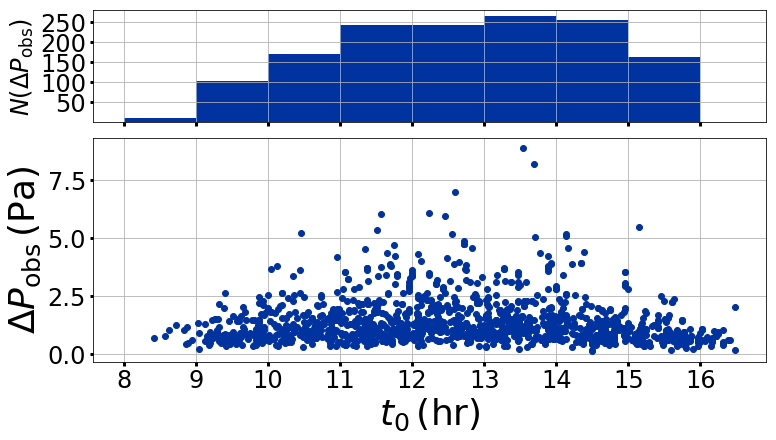

In [3]:
filename = "all_vortices_2020Aug9.csv"
data = np.genfromtxt(filename, delimiter=',', names=True)

# Toss the ones at either end
ind = (data['Gamma'] > 0.5) & (data['Gamma'] < 300.) & (data['DeltaP'] > 0.1)

TOD = data['t0'][ind]
x = data['Gamma'][ind]
y = data['DeltaP'][ind]
xerr = data['Gamma_unc'][ind]
yerr = data['DeltaP_unc'][ind]

# plot it
fig = plt.figure(figsize=(6*aspect_ratio, 6), constrained_layout=True)

gs = fig.add_gridspec(3, 1)
ax1 = fig.add_subplot(gs[1:, :])
ax2 = fig.add_subplot(gs[0, 0], sharex=ax1)

ax1.plot(TOD, y, marker='o', color=BoiseState_blue, ls='')

bins = np.arange(np.floor(np.min(TOD)), np.ceil(np.max(TOD)), 1)
hst, bin_edges, patches = ax2.hist(TOD, bins=bins, color=BoiseState_blue)

ax1.tick_params(labelsize=24)
ax1.set_xticks(bins)
ax1.grid(True)
ax2.tick_params(labelbottom=False, labelsize=24)
ax2.set_yticks([50, 100, 150, 200, 250])
ax2.grid(True)
ax1.set_xlabel(r'$t_0\,\left({\rm hr}\right)$', fontsize=36)
ax1.set_ylabel(r'$\Delta P_{\rm obs}\,\left( {\rm Pa} \right)$', fontsize=36)
ax2.set_ylabel(r'$N\left( \Delta P_{\rm obs}\right)$', fontsize=24)

Gamma +- sigma, U +- sigma, D_obs +- sigma:  98.9319 2.70176 7.8565000000000005 2.4166416161641324 777.25847235 240.02336241486876
[190.417 190.502 190.732 ... 190.399 190.461 190.479]
Gamma +- sigma, U +- sigma, D_obs +- sigma:  9.33541 0.193959 2.6485000000000003 1.7457641122903462 24.724833385 16.30551774858029
Gamma +- sigma, U +- sigma, D_obs +- sigma:  0.502185 0.158902 11.929 0.28200000000000003 5.990564865 1.9008246773818835


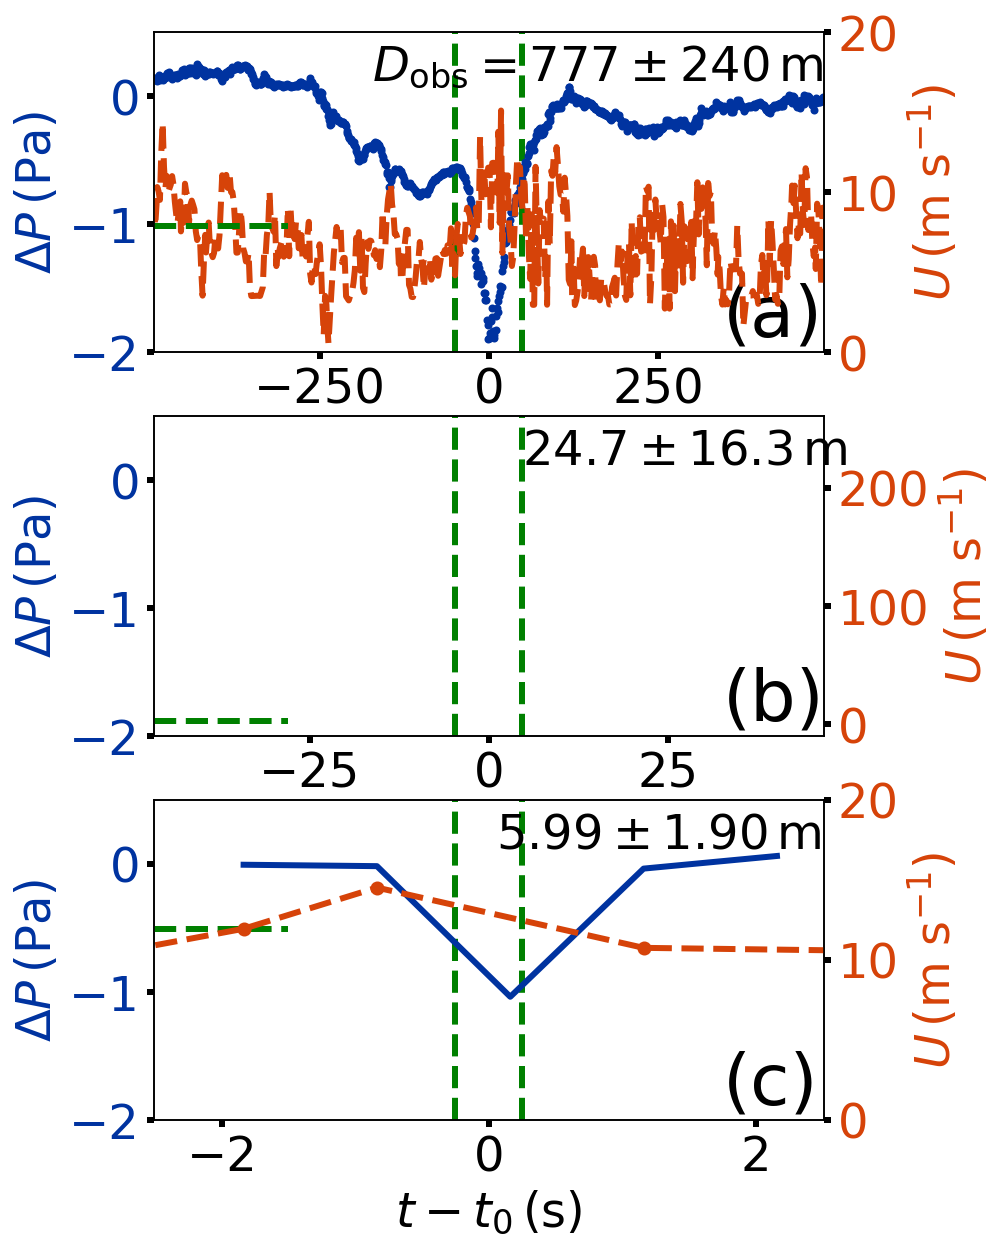

In [8]:
# 2020 Sep 1 - START HERE!


fig = plt.figure(figsize=(6, 10))

filename = "all_vortices_2020Aug9.csv"
data = np.genfromtxt(filename, delimiter=',', names=True)

# Toss the ones at either end
ind = (data['Gamma'] > Gamma_min) & (data['Gamma'] < Gamma_max) & (data['DeltaP'] > P_min)
sols = data['sol'][ind]
t0 = data['t0'][ind]
t0_err = data['t0_unc'][ind]
Gamma = data['Gamma'][ind]
DeltaP = data['DeltaP'][ind]
Gamma_err = data['Gamma_unc'][ind]
DeltaP_err = data['DeltaP_unc'][ind]
slope = data['slope'][ind]
intercept = data['intercept'][ind]

### Maximum Duration ###

mx_Gamma_ind = np.argmax(Gamma)
ax_mx = fig.add_subplot(311)
ax_mx_wind = ax_mx.twinx()
wind_LTST, wind_LTST_and_sol, wind_data = find_wind(sols[mx_Gamma_ind], dr_wind=dr_wind)
wind_LTST_and_sol -= 24.*sols[mx_Gamma_ind]

LTST, LTST_and_sol, sol_data = retrieve_data(sols[mx_Gamma_ind], dr=dr)
LTST_and_sol -= 24.*sols[mx_Gamma_ind]
ind = np.abs(LTST_and_sol - t0[mx_Gamma_ind]) < 5.*Gamma[mx_Gamma_ind]/3600.

time = (LTST_and_sol - t0[mx_Gamma_ind])[ind]
pressure = sol_data["PRESSURE"][ind]
ax_mx.plot(time*3600., pressure - np.polyval([slope[mx_Gamma_ind], intercept[mx_Gamma_ind]], time), 
              color=BoiseState_blue, marker='.', ls='', zorder=1)
ax_mx.axvline(-0.5*Gamma[mx_Gamma_ind], color='green', lw=3, ls='--', zorder=-1)
ax_mx.axvline(0.5*Gamma[mx_Gamma_ind], color='green', lw=3, ls='--', zorder=-1)
ax_mx_wind.plot((wind_LTST_and_sol - t0[mx_Gamma_ind])*3600., wind_data["HORIZONTAL_WIND_SPEED"], lw=3, ls='--', 
                color=BoiseState_orange, zorder=-1)

diameter, diameter_unc, med, md = estimate_diameter(sols[mx_Gamma_ind], t0[mx_Gamma_ind], Gamma[mx_Gamma_ind], 
                                                    Gamma_err[mx_Gamma_ind], dr_wind=dr_wind)
ax_mx_wind.plot([-5.*Gamma[mx_Gamma_ind], -3.*Gamma[mx_Gamma_ind]], 
                [med, med], lw=3, ls='--', color='green', zorder=-1)

ax_mx.set_xlim([-5.*Gamma[mx_Gamma_ind], 5.*Gamma[mx_Gamma_ind]])
ax_mx.set_ylim([-2, 0.5])
ax_mx_wind.set_ylim([0, 20])
ax_mx.tick_params(labelsize=24)
ax_mx.tick_params(axis='y', labelcolor=BoiseState_blue)
ax_mx_wind.tick_params(labelsize=24)
ax_mx_wind.tick_params(axis='y', labelcolor=BoiseState_orange)
# ax_mx.set_xlabel("$t - t_0\,\left({\rm s}\right)$")
ax_mx.set_ylabel(r'$\Delta P\,\left({\rm Pa}\right)$', color=BoiseState_blue, fontsize=24)
ax_mx_wind.set_ylabel(r'$U\,\left({\rm m\ s^{-1}}\right)$', color=BoiseState_orange, fontsize=24)
ax_mx.text(0.85, 0.05, "(a)", fontsize=36, transform=ax_mx.transAxes)
ax_mx.text(0.325, 0.85, r'$D_{\rm obs} = %.0f\pm%.0f\,{\rm m}$' %\
           (med*Gamma[mx_Gamma_ind], 
            med*Gamma[mx_Gamma_ind]*np.sqrt((md/med)**2 + (Gamma_err[mx_Gamma_ind]/Gamma[mx_Gamma_ind])**2)), 
          fontsize=24, transform=ax_mx.transAxes)

print("Gamma +- sigma, U +- sigma, D_obs +- sigma: ", Gamma[mx_Gamma_ind], Gamma_err[mx_Gamma_ind], 
      med, md, 
      med*Gamma[mx_Gamma_ind], 
      med*Gamma[mx_Gamma_ind]*np.sqrt((md/med)**2 + (Gamma_err[mx_Gamma_ind]/Gamma[mx_Gamma_ind])**2))

### Median Duration ###

md_Gamma_ind = np.argmin(np.abs(Gamma - np.median(Gamma)))
ax_md = fig.add_subplot(312)
ax_md_wind = ax_md.twinx()
wind_LTST, wind_LTST_and_sol, wind_data = find_wind(sols[md_Gamma_ind], dr_wind=dr_wind)
wind_LTST_and_sol -= 24.*sols[md_Gamma_ind]

LTST, LTST_and_sol, sol_data = retrieve_data(sols[md_Gamma_ind], dr=dr)
LTST_and_sol -= 24.*sols[md_Gamma_ind]
ind = np.abs(LTST_and_sol - t0[md_Gamma_ind]) < 5.*Gamma[md_Gamma_ind]/3600.

time = (LTST_and_sol - t0[md_Gamma_ind])[ind]
pressure = sol_data["PRESSURE"][ind]
# ax_md.plot(time*3600., pressure - np.polyval([slope[md_Gamma_ind], intercept[md_Gamma_ind]], time), 
#               color=BoiseState_blue, marker='.', ls='')

# ax_md_wind.plot((wind_LTST_and_sol - t0[md_Gamma_ind])*3600., wind_data["HORIZONTAL_WIND_SPEED"], lw=3, ls='--', 
#                 marker='o', color=BoiseState_orange, zorder=-1)

print(wind_data["BMY_AIR_TEMP"])
ax_md_wind.plot((wind_LTST_and_sol - t0[md_Gamma_ind])*3600., wind_data["BMY_AIR_TEMP"], lw=3,  
                marker='o', color='green')

ax_md.axvline(-0.5*Gamma[md_Gamma_ind], color='green', lw=3, ls='--', zorder=-1)
ax_md.axvline(0.5*Gamma[md_Gamma_ind], color='green', lw=3, ls='--', zorder=-1)

diameter, diameter_unc, med, md = estimate_diameter(sols[md_Gamma_ind], t0[md_Gamma_ind], Gamma[md_Gamma_ind], 
                                                    Gamma_err[md_Gamma_ind], dr_wind=dr_wind)
ax_md_wind.plot([-5.*Gamma[md_Gamma_ind], -3.*Gamma[md_Gamma_ind]], 
                [med, med], lw=3, ls='--', color='green', zorder=-1)

ax_md.set_xlim([-5.*Gamma[md_Gamma_ind], 5.*Gamma[md_Gamma_ind]])
ax_md.set_ylim([-2, 0.5])
# ax_md_wind.set_ylim([0, 20])
ax_md.tick_params(labelsize=24)
ax_md.tick_params(axis='y', labelcolor=BoiseState_blue)
ax_md_wind.tick_params(labelsize=24)
ax_md_wind.tick_params(axis='y', labelcolor=BoiseState_orange)
ax_md.set_ylabel(r'$\Delta P\,\left({\rm Pa}\right)$', color=BoiseState_blue, fontsize=24)
ax_md_wind.set_ylabel(r'$U\,\left({\rm m\ s^{-1}}\right)$', color=BoiseState_orange, fontsize=24)
ax_md.text(0.85, 0.05, "(b)", fontsize=36, transform=ax_md.transAxes)
ax_md.text(0.55, 0.85, r'$%.1f\pm%.1f\,{\rm m}$' %\
           (med*Gamma[md_Gamma_ind], 
            med*Gamma[md_Gamma_ind]*np.sqrt((md/med)**2 + (Gamma_err[md_Gamma_ind]/Gamma[md_Gamma_ind])**2)), 
          fontsize=24, transform=ax_md.transAxes)

print("Gamma +- sigma, U +- sigma, D_obs +- sigma: ", Gamma[md_Gamma_ind], Gamma_err[md_Gamma_ind], 
      med, md, 
      med*Gamma[md_Gamma_ind], 
      med*Gamma[md_Gamma_ind]*np.sqrt((md/med)**2 + (Gamma_err[md_Gamma_ind]/Gamma[md_Gamma_ind])**2))
      
# ### Minimum Duration ###

mn_Gamma_ind = np.argmin(Gamma)
ax_mn = fig.add_subplot(313)
ax_mn_wind = ax_mn.twinx()

wind_LTST, wind_LTST_and_sol, wind_data = find_wind(sols[mn_Gamma_ind], dr_wind=dr_wind)
wind_LTST_and_sol -= 24.*sols[mn_Gamma_ind]

LTST, LTST_and_sol, sol_data = retrieve_data(sols[mn_Gamma_ind], dr=dr)
LTST_and_sol -= 24.*sols[mn_Gamma_ind]
ind = np.abs(LTST_and_sol - t0[mn_Gamma_ind]) < 5.*Gamma[mn_Gamma_ind]/3600.

time = (LTST_and_sol - t0[mn_Gamma_ind])[ind]
pressure = sol_data["PRESSURE"][ind]
ax_mn.plot(time*3600., pressure - np.polyval([slope[mn_Gamma_ind], intercept[mn_Gamma_ind]], time), 
              color=BoiseState_blue, lw=3)
ax_mn_wind.plot((wind_LTST_and_sol - t0[mn_Gamma_ind])*3600., wind_data["HORIZONTAL_WIND_SPEED"], lw=3, ls='--',
                marker='o', color=BoiseState_orange)
ax_mn.axvline(-0.5*Gamma[mn_Gamma_ind], color='green', lw=3, ls='--', zorder=-1)
ax_mn.axvline(0.5*Gamma[mn_Gamma_ind], color='green', lw=3, ls='--', zorder=-1)
diameter, diameter_unc, med, md = estimate_diameter(sols[mn_Gamma_ind], t0[mn_Gamma_ind], Gamma[mn_Gamma_ind], 
                                                    Gamma_err[mn_Gamma_ind], dr_wind=dr_wind)
ax_mn_wind.plot([-5.*Gamma[mn_Gamma_ind], -3.*Gamma[mn_Gamma_ind]], 
                [med, med], lw=3, ls='--', color='green', zorder=-1)

ax_mn.set_xlim([-5.*Gamma[mn_Gamma_ind], 5.*Gamma[mn_Gamma_ind]])
ax_mn.set_ylim([-2, 0.5])
ax_mn_wind.set_ylim([0, 20])
ax_mn.tick_params(labelsize=24)
ax_mn.tick_params(axis='y', labelcolor=BoiseState_blue)
ax_mn_wind.tick_params(labelsize=24)
ax_mn_wind.tick_params(axis='y', labelcolor=BoiseState_orange)
ax_mn.set_xlabel(r'$t - t_0\,\left({\rm s}\right)$', fontsize=24)
ax_mn.set_ylabel(r'$\Delta P\,\left({\rm Pa}\right)$', color=BoiseState_blue, fontsize=24)
ax_mn_wind.set_ylabel(r'$U\,\left({\rm m\ s^{-1}}\right)$', color=BoiseState_orange, fontsize=24)
ax_mn.text(0.85, 0.05, "(c)", fontsize=36, transform=ax_mn.transAxes)
ax_mn.text(0.51, 0.85, r'$%.2f\pm%.2f\,{\rm m}$' %\
           (med*Gamma[mn_Gamma_ind], 
            med*Gamma[mn_Gamma_ind]*np.sqrt((md/med)**2 + (Gamma_err[mn_Gamma_ind]/Gamma[mn_Gamma_ind])**2)), 
          fontsize=24, transform=ax_mn.transAxes)

print("Gamma +- sigma, U +- sigma, D_obs +- sigma: ", Gamma[mn_Gamma_ind], Gamma_err[mn_Gamma_ind], 
      med, md, 
      med*Gamma[mn_Gamma_ind], 
      med*Gamma[mn_Gamma_ind]*np.sqrt((md/med)**2 + (Gamma_err[mn_Gamma_ind]/Gamma[mn_Gamma_ind])**2))

# fig.savefig("../figures/vortices_and_windspeed.png", dpi=500, bbox_inches="tight")

In [2]:
# 2020 Sep 9 - Commented everything out

# Create table of diameters

filename = "all_vortices.csv"
data = np.genfromtxt(filename, delimiter=',', names=True)

# Toss the ones at either end
ind = (data['Gamma'] > Gamma_min) & (data['Gamma'] < Gamma_max) & (data['DeltaP'] > P_min)
vortex_number = data['vortex_number'][ind]
sols = data['sol'][ind]
t0 = data['t0'][ind]
t0_err = data['t0_unc'][ind]
Gamma = data['Gamma'][ind]
Gamma_err = data['Gamma_unc'][ind]
DeltaP = data['DeltaP'][ind]
DeltaP_err = data['DeltaP_unc'][ind]
slope = data['slope'][ind]
slope_err = data['slope_unc'][ind]
intercept = data['intercept'][ind]
intercept_err = data['intercept_unc'][ind]

diameters = np.array([])
diameter_uncs = np.array([])
DeltaPs = np.array([])
DeltaP_uncs = np.array([])
Gammas = np.array([])
Gamma_uncs = np.array([])
U = np.array([])
U_uncs = np.array([])

filename = "all_vortices_with_diameters.csv"
# f = open(filename, "w")
# f.write("# vortex_number, sol, t0, t0_unc, DeltaP, DeltaP_unc, Gamma, Gamma_unc, slope, slope_unc, "+\
#         "intercept, intercept_unc, U, U_unc, Diameter, Diameter_unc\n")

for i in range(len(sols[0:11])):
# for i in [0]:

    diameter, diameter_unc, U, U_unc = estimate_diameter(sols[i], t0[i], Gamma[i], Gamma_err[i], dr_wind=dr_wind)

    # 2021 Jan 31 - Many of the vortices have only a handful of wind data points. 
    # For those cases, diameter_unc = 0. Be sure to toss them out!
    
    if(diameter is not None):
        print("%i, %i, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g" %\
              (vortex_number[i], sols[i], t0[i], t0_err[i], DeltaP[i], DeltaP_err[i], Gamma[i], Gamma_err[i], 
               slope[i], slope_err[i], intercept[i], intercept_err[i], U, U_unc, diameter, diameter_unc))
        
#         f.write("%i, %i, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g\n" %\
#                 (vortex_number[i], sols[i], t0[i], t0_err[i], DeltaP[i], DeltaP_err[i], Gamma[i], Gamma_err[i], 
#                  slope[i], slope_err[i], intercept[i], intercept_err[i], U, U_unc, diameter, diameter_unc))
        
# f.close()

0, 14, 12.0302, 0.000106779, 0.698558, 0.0414835, 12.9454, 1.12539, -2.0059, 0.0793729, 740.918, 0.00409603, 8.92, 2.88901, 115.473, 38.7232
1, 14, 12.9698, 8.46418e-05, 0.748218, 0.0365595, 12.4715, 0.890924, -5.03188, 0.0686569, 735.75, 0.00355436, 6.573, 2.39694, 81.9752, 30.4616
2, 14, 12.8427, 3.73416e-05, 1.15952, 0.104944, 2.84131, 0.371845, -12.25, 0.768696, 736.656, 0.00981517, 8.76, 0.0855535, 24.8899, 3.26642
3, 14, 13.3452, 4.87628e-05, 0.973078, 0.121369, 2.7553, 0.502842, -3.20498, 1.20717, 733.722, 0.0124879, 8.385, 12.2463, 23.1032, 34.0047
4, 14, 14.7406, 7.10467e-05, 1.94021, 0.0561605, 17.6693, 0.758421, -4.99231, 0.125549, 726.733, 0.00664434, 8.539, 2.64115, 150.878, 47.1144
0, 15, 15.1452, 8.12429e-05, 0.587536, 0.0260479, 13.1931, 0.856811, -4.04133, 0.0503125, 719.577, 0.0026165, 7.116, 2.62374, 93.8821, 35.1482
1, 15, 12.4142, 4.84331e-05, 1.23031, 0.0377356, 11.3681, 0.513513, -7.5183, 0.104173, 733.459, 0.00409006, 4.8295, 1.72458, 54.9022, 19.7615
2, 15, 13.

np.mean(data['Gamma']):  12.574989621475053
240.267 1097.63
10.8542 52.364
0.701485 3.56362
1097.63 3.56362 52.364
D vs Delta P:
[-0.38118757  1.73541433]
[0.04362661 0.01416429]
[785.38692576  90.91402584]
[4.21054729 0.77582921]
8.638787232938032
52.364


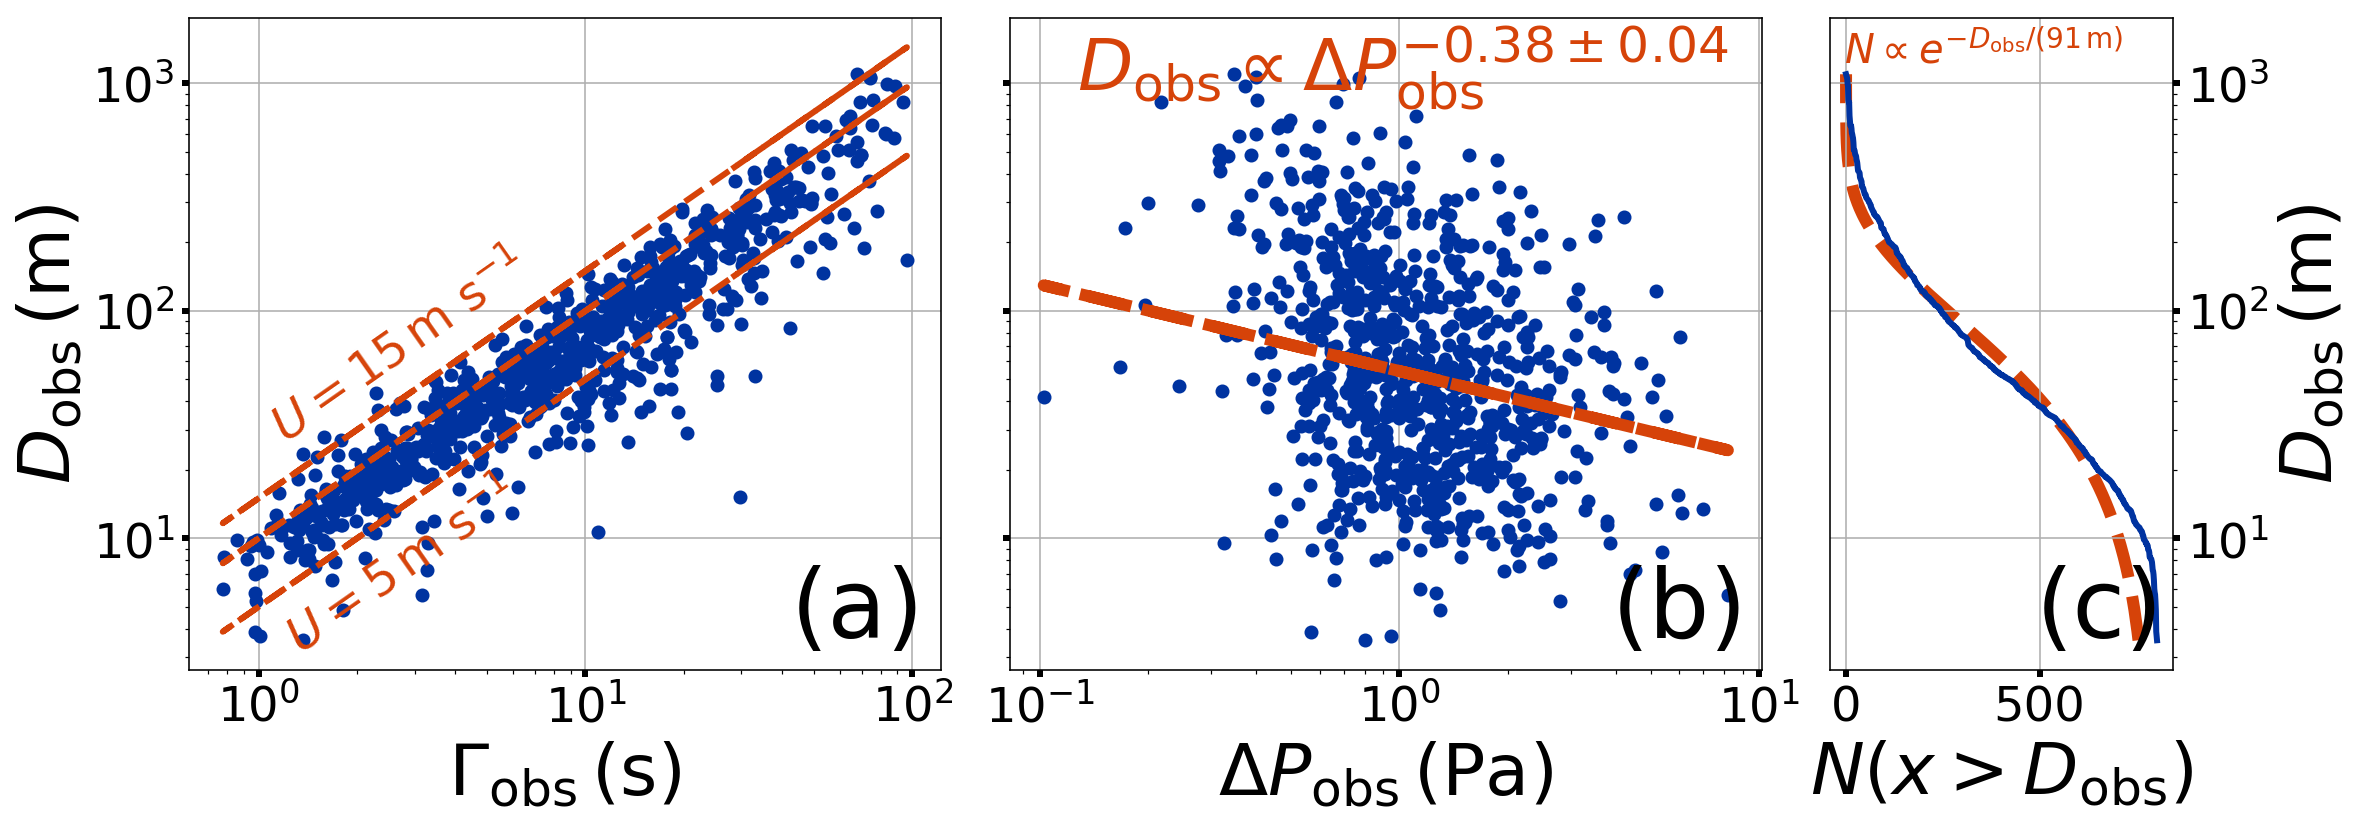

In [52]:
def exponential(x, amp, scale):
    return amp*np.exp(-x/scale)

fig = plt.figure(figsize=(10*aspect_ratio, 6))

ax1 = plt.subplot2grid((1,5), (0,0), colspan=2, rowspan=1)
ax2 = plt.subplot2grid((1,5), (0,2), colspan=2, rowspan=1, sharey=ax1)
ax3 = plt.subplot2grid((1,5), (0,4), colspan=1, rowspan=1, sharey=ax1)

filename = "all_vortices_with_diameters.csv"   
data = np.genfromtxt(filename, delimiter=',', names=True, dtype=None)    
# ('sol', 't0', 'DeltaP', 'DeltaP_unc', 'Gamma', 'Gamma_unc', 'U', 'U_unc', 'Diameter', 'Diameter_unc')

# Take only vortices with estimates uncertainties for the diameters
ind = data['Diameter_unc'] > 0

print("np.mean(data['Gamma']): ", np.mean(data['Gamma']))

mx_ind = np.argmax(data['Diameter'][ind])
print(data['Diameter_unc'][ind][mx_ind], data['Diameter'][ind][mx_ind])
md_ind = np.argmin(np.abs(data['Diameter'][ind] - np.median(data['Diameter'][ind])))
print(data['Diameter_unc'][ind][md_ind], data['Diameter'][ind][md_ind])
mn_ind = np.argmin(np.abs(data['Diameter'][ind]))
print(data['Diameter_unc'][ind][mn_ind], data['Diameter'][ind][mn_ind])

print(np.nanmax(data['Diameter'][ind]), np.nanmin(data['Diameter'][ind]), np.nanmedian(data['Diameter'][ind]))

### D_obs vs. Gamma_obs ###

ax1.loglog(data['Gamma'][ind], data['Diameter'][ind], ls='', marker='o', color=BoiseState_blue)

U0 = 5.
ax1.loglog(data['Gamma'][ind], U0*data['Gamma'][ind], color=BoiseState_orange, lw=3, ls='--')
ax1.text(0.12, 0.25, r'$U = %.0f\,{\rm m\ s^{-1}}$' % U0, 
        fontsize=24, transform=ax1.transAxes, color=BoiseState_orange, rotation=35)
U0 = 10.
ax1.loglog(data['Gamma'][ind], U0*data['Gamma'][ind], color=BoiseState_orange, lw=3, ls='--')
U0 = 15.
ax1.loglog(data['Gamma'][ind], U0*data['Gamma'][ind], color=BoiseState_orange, lw=3, ls='--')
ax1.text(0.1, 0.6, r'$U = %.0f\,{\rm m\ s^{-1}}$' % U0, 
        fontsize=24, transform=ax1.transAxes, color=BoiseState_orange, rotation=35)

ax1.text(0.8, 0.05, "(a)", fontsize=48, transform=ax1.transAxes)
ax1.grid(True)
ax1.tick_params(labelsize=24)
ax1.set_xlabel(r'$\Gamma_{\rm obs}\,\left( {\rm s} \right)$', fontsize=36)
ax1.set_ylabel(r'$D_{\rm obs}\,\left( {\rm m} \right)$', fontsize=36)

### D_obs vs. Delta P_obs ###
ax2.loglog(data['DeltaP'][ind], data['Diameter'][ind], ls='', marker='o', color=BoiseState_blue)

# polyfit
x = np.log10(data['DeltaP'][ind])
xerr = data['DeltaP_unc'][ind]/(data['DeltaP'][ind]*np.log(10.))
y = np.log10(data['Diameter'][ind])
yerr = data['Diameter_unc'][ind]/(data['Diameter'][ind]*np.log(10.))
popt, pcov = curve_fit(line, x, y, sigma=yerr)
uncertainties = np.sqrt(np.diag(pcov))
print("D vs Delta P:")
print(popt)
print(uncertainties)
ax2.loglog(10.**x, 10.**(np.polyval(popt, x)), lw=6, ls='--', color=BoiseState_orange)
ax2.text(0.09, 0.89, r'$D_{\rm obs} \propto \Delta P_{\rm obs}^{%.2f\pm%.2f}$' % (popt[0], uncertainties[0]), 
         fontsize=36, transform=ax2.transAxes, color=BoiseState_orange)

ax2.text(0.8, 0.05, "(b)", fontsize=48, transform=ax2.transAxes)
ax2.yaxis.set_label_position("right")
ax2.grid(True)
ax2.tick_params(axis='x', labelsize=24)
ax2.tick_params(labelleft=False)
ax2.set_xlabel(r'$\Delta P_{\rm obs}\,\left( {\rm Pa} \right)$', fontsize=36)
# ax2.set_ylabel(r'$D_{\rm obs}\,\left( {\rm m} \right)$', fontsize=36)

### D_obs cumulative histogram ###
# hst, bin_edges = np.histogram(np.log10(data['Diameter'][ind]), bins='auto')
# bins = 0.5*(bin_edges[1:] + bin_edges[0:-1])
# hst_err = np.sqrt(hst)
# ax3.plot(hst, 10**bins, lw=3, color=BoiseState_blue)

# hst, bin_edges = np.histogram(data['Diameter'][ind], bins='auto')
# bins = 0.5*(bin_edges[1:] + bin_edges[0:-1])
# hst_err = np.sqrt(hst)
# ax3.loglog(hst, bins, lw=3, color=BoiseState_blue)

x = data['Diameter'][ind]
srt = np.argsort(x)
Diameter = x[srt]
hst, _ = np.histogram(Diameter, bins=[0, *Diameter])
Diameter_cum_hst = len(Diameter) - np.cumsum(hst)
Diameter_cum_hst_err = np.sqrt(Diameter_cum_hst)
ax3.semilogy(Diameter_cum_hst, Diameter, lw=3, color=BoiseState_blue)

ind = Diameter_cum_hst > 0
# fit_params = np.polyfit(np.log10(Diameter[ind]), np.log10(Diameter_cum_hst[ind]), 1, 
#                         w=1./Diameter_cum_hst_err[ind])
# print(fit_params)
# ax3.loglog(10**np.polyval(fit_params, np.log10(Diameter)), Diameter, lw=3, ls='--', color=BoiseState_orange)

popt, pcov = curve_fit(exponential, Diameter[ind], Diameter_cum_hst[ind], sigma=Diameter_cum_hst_err[ind])
uncertainties = np.sqrt(np.diag(pcov))
print(popt)
print(uncertainties)
print(popt[0]/popt[1])
ax3.plot(exponential(Diameter, *popt), Diameter, lw=6, ls='--', color=BoiseState_orange, zorder=-1)

ax3.grid(True)
ax3.tick_params(labelsize=24)
ax3.text(0.6, 0.05, "(c)", fontsize=48, transform=ax3.transAxes)
ax3.text(0.04, 0.93, r'$N \propto e^{-D_{\rm obs}/\left( %.0f\, {\rm m} \right)}$' %\
         popt[1], fontsize=20, color=BoiseState_orange, transform=ax3.transAxes)
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()
ax3.set_xlabel(r'$N\left(x > D_{\rm obs}\right)$', fontsize=36)
# ax3.set_xlabel(r'$N\left(D_{\rm obs}\right)$', fontsize=36)
ax3.set_ylabel(r'$D_{\rm obs}\,\left( {\rm m} \right)$', fontsize=36)

Dobs_quantile = np.quantile(Diameter, 0.5)
print(Dobs_quantile)
# popt, pcov = curve_fit(gauss, bins, hst)
# uncertainties = np.sqrt(np.diag(pcov))
# ax3.plot(gauss(bins, *popt), 10**bins, lw=3, ls='--', color=BoiseState_orange)
# ax3.text(0.1, 0.95, "exponential", transform=ax3.transAxes)
# ax3.text(0.1, 0.9, r'$A = %g, \log\ D_0 = %g$' % (popt[0], popt[1]), transform=ax3.transAxes)
# ax3.text(0.1, 0.85, r'$\sigma = %g$' % np.abs(popt[2]), transform=ax3.transAxes)
# print(popt)
# print(uncertainties)

# fit_params = np.polyfit(bins, hst, 2, w=1/hst_err)
# print(fit_params)
# ax3.plot(np.polyval(fit_params, bins), 10**bins, lw=3, ls='--', color=BoiseState_orange)

# fig.savefig("../figures/Dobs_vs_Gammaobs-DeltaPobs_hist.png", dpi=500, bbox_inches="tight")

19.059 1.03434
7.7815 0.116731
0.513 0.231885
7.7815
bins[np.argmax(med)]:  11.0
peak in U histogram at 7.867448275862069
[-4.10758531  5.74071197]


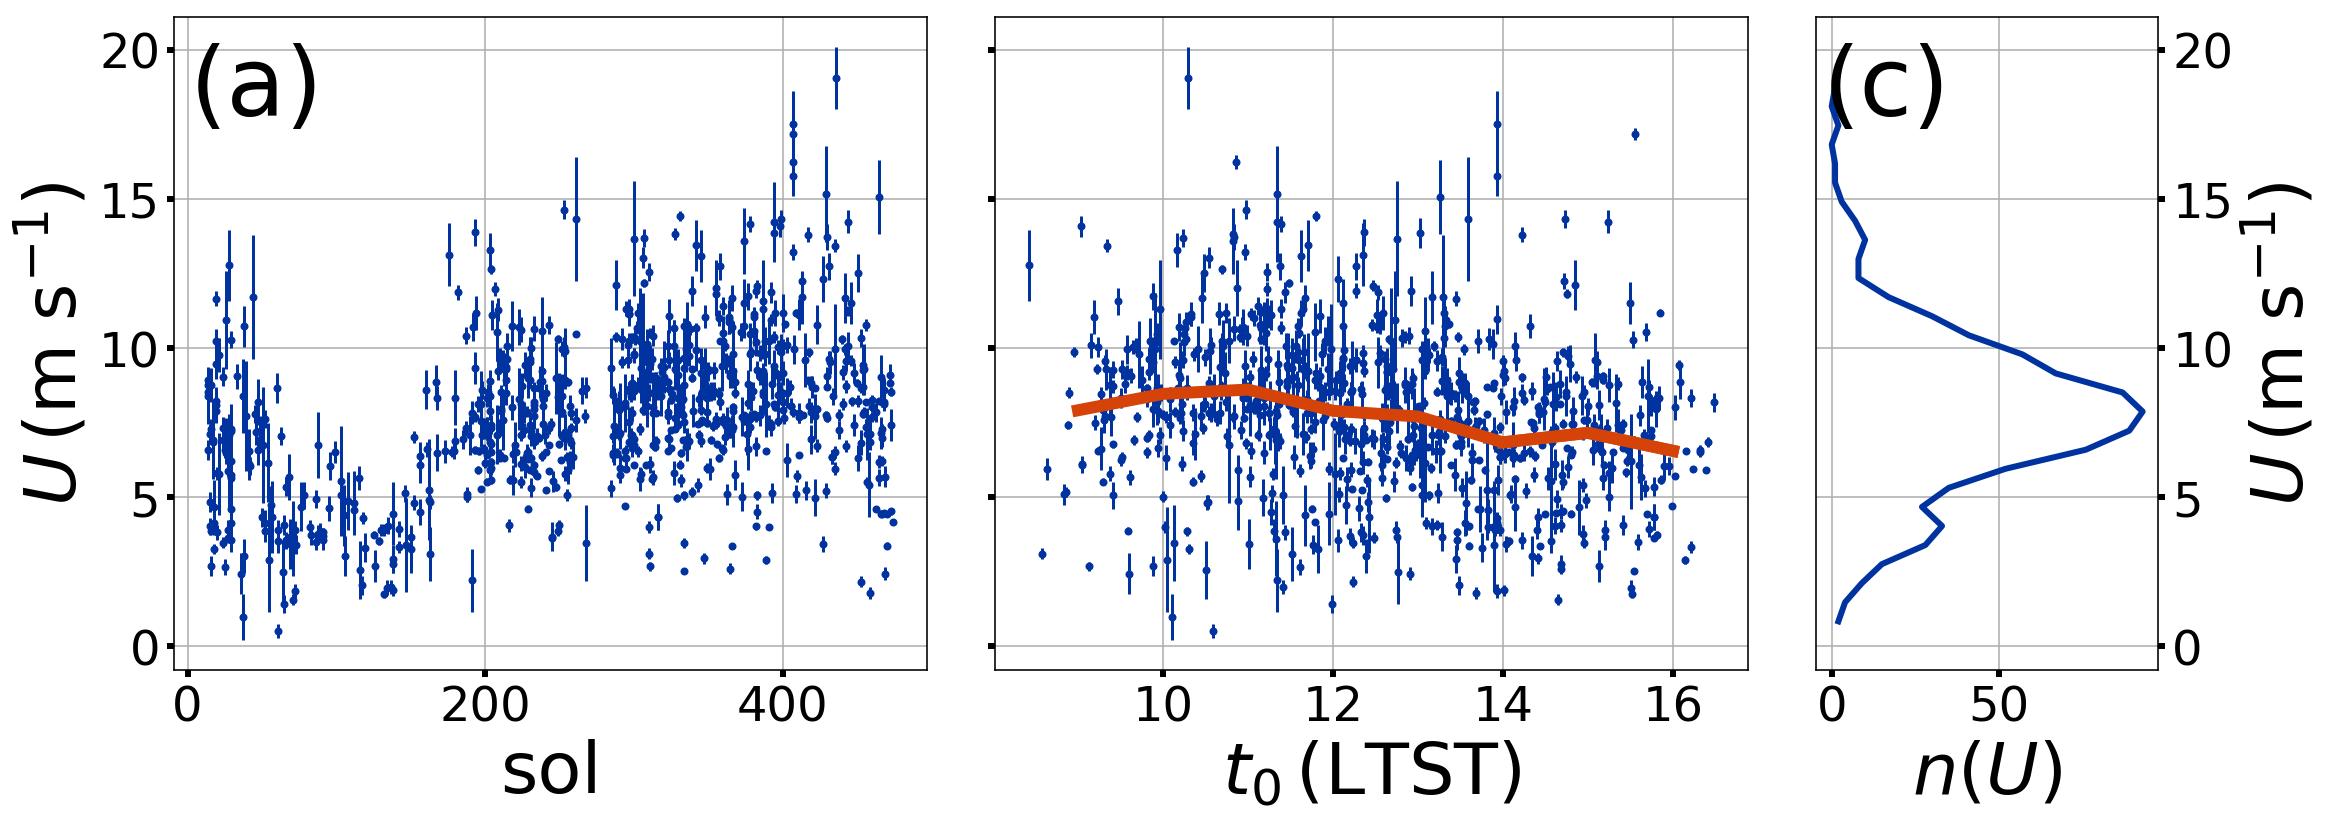

In [3]:
filename = "all_vortices_with_diameters.csv"
data = np.genfromtxt(filename, delimiter=',', names=True, dtype=None)    
# ('sol', 't0', 'DeltaP', 'DeltaP_unc', 'Gamma', 'Gamma_unc', 'U', 'U_unc', 'Diameter', 'Diameter_unc')
ind = data['Diameter_unc'] > 0

fig = plt.figure(figsize=(10*aspect_ratio, 6))
ax1 = plt.subplot2grid((1,5), (0,0), colspan=2, rowspan=1)
ax2 = plt.subplot2grid((1,5), (0,2), colspan=2, rowspan=1, sharey=ax1)
ax3 = plt.subplot2grid((1,5), (0,4), colspan=1, rowspan=1, sharey=ax1)

mx = np.argmax(data['U'][ind])
print(data['U'][ind][mx], data['U_unc'][ind][mx])

md = np.argmin(np.abs(data['U'][ind] - np.median(data['U'][ind])))
print(data['U'][ind][md], data['U_unc'][ind][md])

mn = np.argmin(data['U'][ind])
print(data['U'][ind][mn], data['U_unc'][ind][mn])

### Windspeed vs. SOL ###
ax1.errorbar(data['sol'][ind], data['U'][ind], yerr=data['U_unc'][ind], color=BoiseState_blue, ls='', marker='.')

bin_edges = np.arange(np.min(data['sol'][ind]) - 0.5, np.max(data['sol'][ind]) + 1.5, 1)
med = np.array([])
bins = np.array([])
for i in range(len(bin_edges) - 1):
    oind = (data['t0'][ind] >= bin_edges[i]) & (data['t0'][ind] < bin_edges[i+1])
    if(len(data['t0'][ind][oind]) > 1):
        bins = np.append(bins, 0.5*(bin_edges[i] + bin_edges[i+1]))
        med = np.append(med, np.nanmedian(data['U'][ind][oind]))

ax2.plot(bins, med, color=BoiseState_orange, lw=6, zorder=3)

ax1.set_xlabel('sol', fontsize=36)
ax1.set_ylabel(r'$U\, \left( {\rm m\ s^{-1}} \right)$', fontsize=36)
ax1.tick_params(axis='x', labelsize=24)
ax1.tick_params(labelsize=24)
ax1.grid(True)
ax1.text(0.02, 0.85, "(b)", fontsize=48, transform=ax2.transAxes)

### Windspeed vs. t0 ###
print(np.quantile(data['U'][ind], 0.5))
ax2.errorbar(data['t0'][ind], data['U'][ind], yerr=data['U_unc'][ind], color=BoiseState_blue, ls='', marker='.')

# Bin by hour
bin_edges = np.arange(-0.5, 25.5, 1)
med = np.array([])
bins = np.array([])
for i in range(len(bin_edges) - 1):
    oind = (data['t0'][ind] >= bin_edges[i]) & (data['t0'][ind] < bin_edges[i+1])
    if(len(data['t0'][ind][oind]) > 1):
        bins = np.append(bins, 0.5*(bin_edges[i] + bin_edges[i+1]))
        med = np.append(med, np.nanmedian(data['U'][ind][oind]))

ax2.plot(bins, med, color=BoiseState_orange, lw=6, zorder=3)
wind_bins = bins
wind_meds = med
print("bins[np.argmax(med)]: ", bins[np.argmax(med)])

ax2.set_xlabel(r'$t_0\, {\rm (LTST) }$', fontsize=36)
ax2.tick_params(labelleft=False, labelright=False)
ax2.tick_params(labelsize=24)
ax2.grid(True)
ax2.text(0.02, 0.85, "(a)", fontsize=48, transform=ax1.transAxes)

### Histogram ###
hst, bin_edges = np.histogram(data['U'][ind], bins='auto')
bins = 0.5*(bin_edges[1:] + bin_edges[0:-1])
ax3.plot(hst, bins, color=BoiseState_blue, lw=3)
ax3.set_xlabel(r'$n \left( U \right)$', fontsize=36)
ax3.set_ylabel(r'$U\, \left( {\rm m\ s^{-1}} \right)$', fontsize=36)
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()
ax3.tick_params(labelsize=24)
ax3.grid(True)
ax3.text(0.02, 0.85, "(c)", fontsize=48, transform=ax3.transAxes)

# 2020 Oct 28 - Fitting the wind speed on the low end
peak_ind = np.argmax(hst)
print("peak in U histogram at", bins[peak_ind])

wind_ind = (bins >= bins[peak_ind]) & (bins < 12.)
coeffs = np.polyfit(np.log10(bins[wind_ind]), np.log10(hst[wind_ind]), 1)
print(coeffs)

fig.savefig("../figures/U_vs_t0-sol_hist.png", dpi=500, bbox_inches="tight")

1.174664997814008
[9.49334148]
(-0.7903519724524989, 0.019566021712103775)


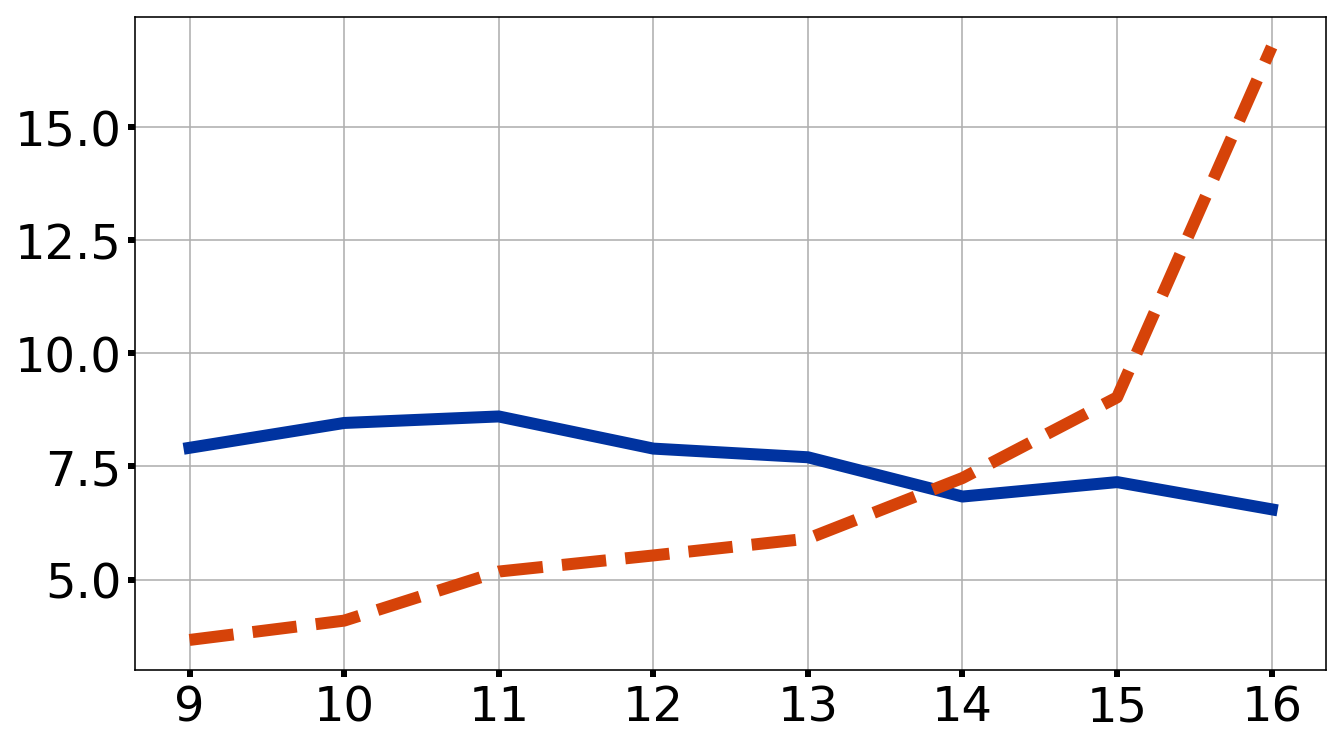

In [59]:
fig = plt.figure(figsize=(6*aspect_ratio, 6))
ax = fig.add_subplot(111)

# plt.plot(wind_meds, Gamma_meds, marker='o', color=BoiseState_blue, ls='')
plt.plot(wind_bins, wind_meds, color=BoiseState_blue, lw=6)
plt.plot(Gamma_TOD, Gamma_meds, color=BoiseState_orange, ls='--', lw=6)

ax.tick_params(labelsize=24)
# ax.set_xlabel(r'$U\,\left( {\rm m\ s^{-1}} \right)$', fontsize=36)
# ax.set_ylabel(r'$\Gamma_{\rm obs}\,\left( {\rm s} \right)$', fontsize=36)
ax.grid(True)

print(np.min(wind_meds)/(np.max(wind_meds) - np.min(wind_meds)))
print((np.max(Gamma_meds) - Gamma_meds[Gamma_TOD == 11])/Gamma_meds[Gamma_TOD == 11])

res = pearsonr(wind_meds, Gamma_meds)
print(res)

[723789.20015699]


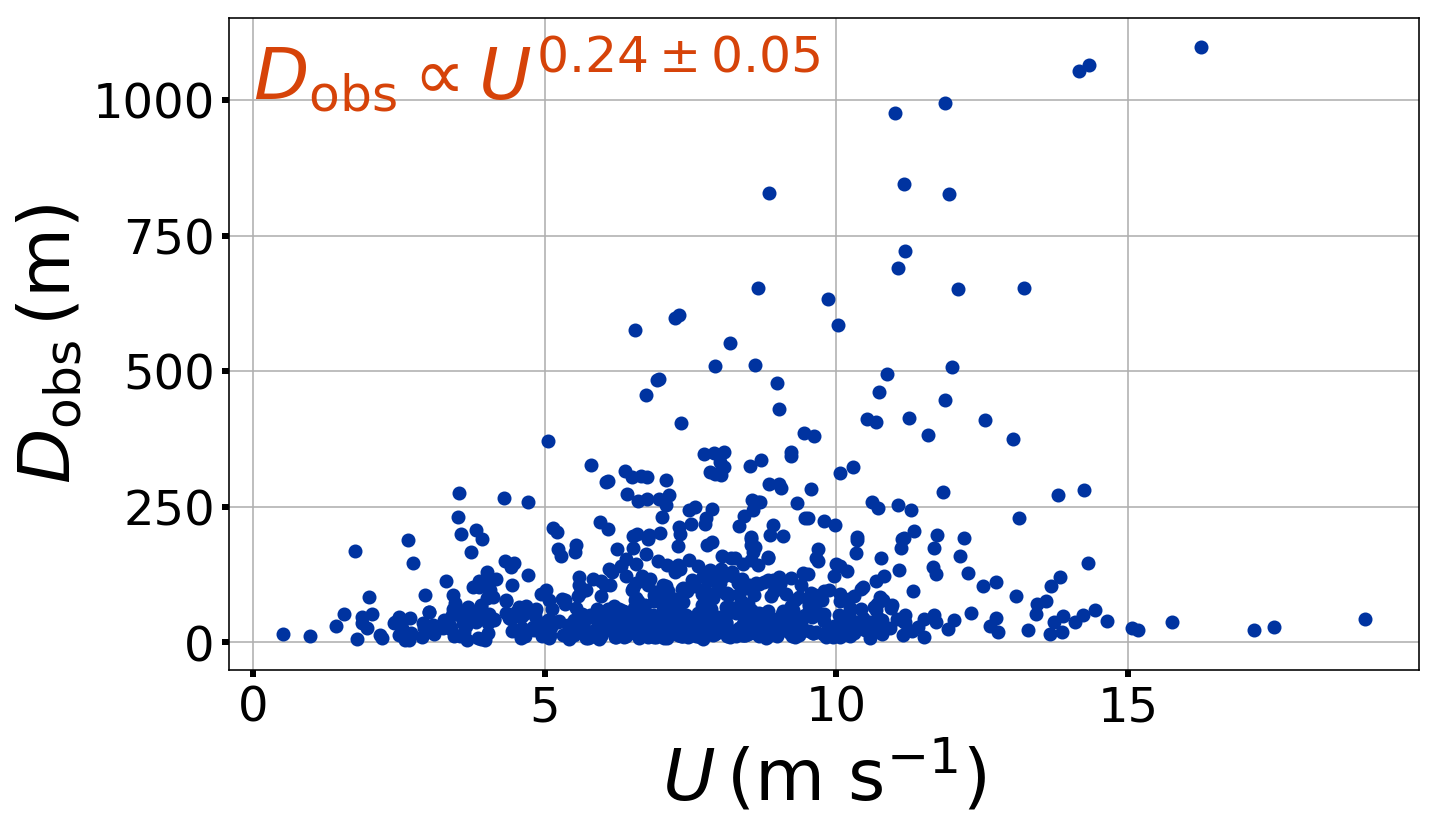

In [11]:
fig = plt.figure(figsize=(6*aspect_ratio, 6))
ax = fig.add_subplot(111)

filename = "all_vortices_with_diameters.csv"
data = np.genfromtxt(filename, delimiter=',', names=True, dtype=None)    

# ('sol', 't0', 'DeltaP', 'DeltaP_unc', 'Gamma', 'Gamma_unc', 'U', 'U_unc', 'Diameter', 'Diameter_unc')
ind = data['Diameter_unc'] > 0.

ax.plot(data['U'][ind], data['Diameter'][ind], marker='o', color=BoiseState_blue, ls='')

# popt, pcov = curve_fit(line, data['U'][ind], data['Diameter'][ind])#, sigma=data['Diameter_unc'][ind])
# uncertainties = np.sqrt(np.diag(pcov))
# print(popt)
# print(uncertainties)
# print(redchisqg(data['Diameter'][ind], line(data['U'][ind], *popt), deg=2))#, sd=data['Diameter_unc'][ind]))
# srt = np.argsort(data['U'][ind])
# ax.plot(data['U'][ind][srt], np.polyval(popt, data['U'][ind][srt]), 
#             color=BoiseState_orange, ls='--', lw=6)

# popt, pcov = curve_fit(line, np.log10(data['U'][ind]), np.log10(data['Diameter'][ind]), 
#                        sigma=data['Diameter_unc'][ind]/(np.log(10)*data['Diameter'][ind]))
# uncertainties = np.sqrt(np.diag(pcov))
# print(popt)
# print(uncertainties)
# print(redchisqg(np.log10(data['Diameter'][ind]), line(np.log10(data['U'][ind]), *popt), deg=2, 
#                 sd=data['Diameter_unc'][ind]/(np.log(10)*data['Diameter'][ind])))
# srt = np.argsort(data['U'][ind])
# ax.plot(data['U'][ind][srt], 10.**np.polyval(popt, np.log10(data['U'][ind][srt])), 
#             color=BoiseState_orange, ls='--', lw=6)

ax.set_ylabel(r'$D_{\rm obs}\,\left( {\rm m} \right)$', fontsize=36)
ax.set_xlabel(r'$U\,\left( {\rm m\ s^{-1}} \right)$', fontsize=36)
ax.tick_params(labelsize=24)
ax.grid(True)

ax.text(0.02, 0.875, r'$D_{\rm obs} \propto U^{%.2f\pm%.2f}$' % (popt[0], uncertainties[0]), 
        transform=ax.transAxes, fontsize=36, color=BoiseState_orange)

[-0.23288183  5.25665595]
[0.0587431  0.47450258]
297.1547185034371

[-0.22453247  1.31845734]
[0.07188577 0.05895881]
478.81366705732347

657.0449509148598
(-0.07444914555082043, 0.03491646549303933)


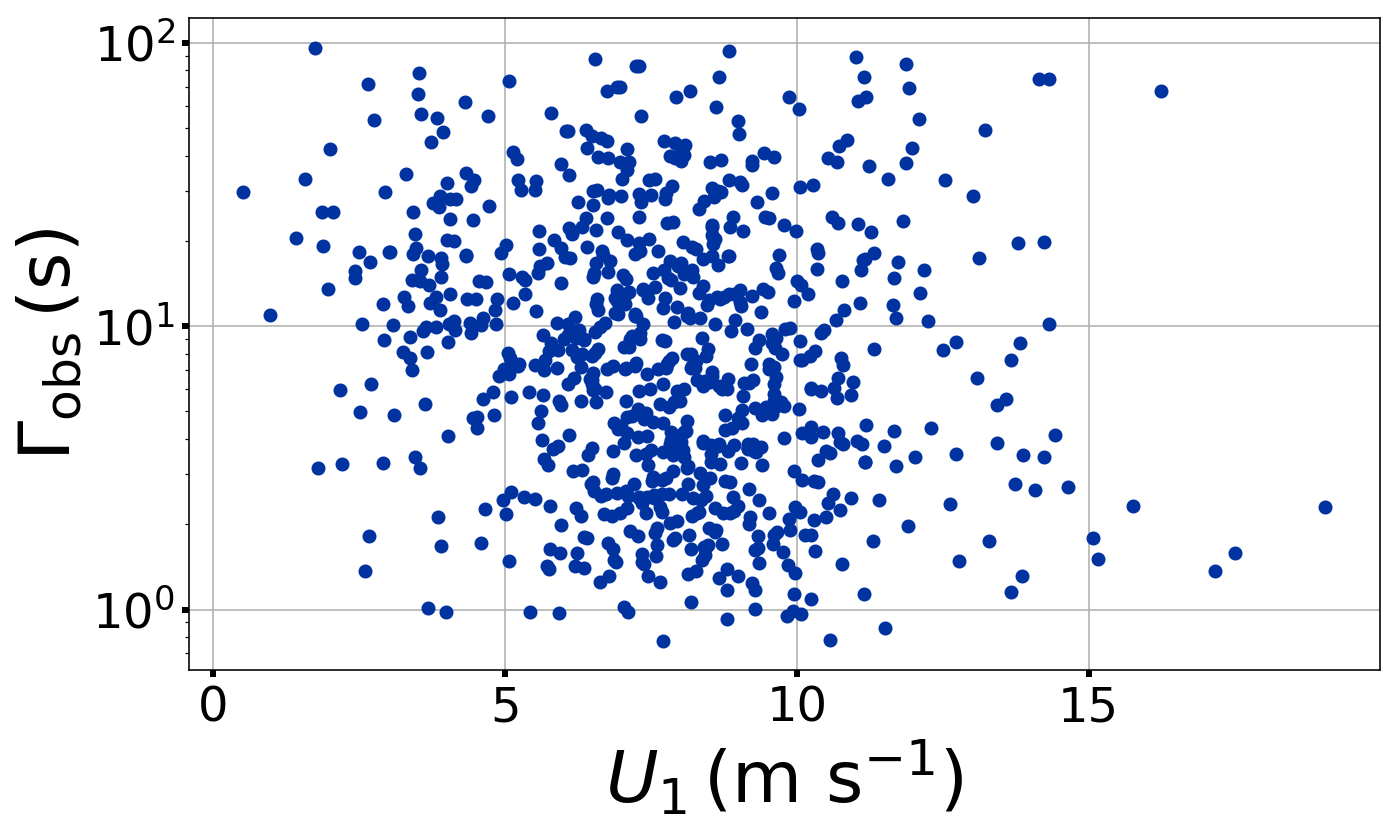

In [26]:
fig = plt.figure(figsize=(6*aspect_ratio, 6))
ax = fig.add_subplot(111)

filename = "all_vortices_with_diameters.csv"
data = np.genfromtxt(filename, delimiter=',', names=True, dtype=None)    

# ('sol', 't0', 'DeltaP', 'DeltaP_unc', 'Gamma', 'Gamma_unc', 'U', 'U_unc', 'Diameter', 'Diameter_unc')
ind = data['Diameter_unc'] > 0

ax.semilogy(data['U'][ind], data['Gamma'][ind], marker='o', color=BoiseState_blue, ls='')

popt, pcov = curve_fit(line, data['U'][ind], data['Gamma'][ind], sigma=data['Gamma_unc'][ind])
uncertainties = np.sqrt(np.diag(pcov))
print(popt)
print(uncertainties)
print(redchisqg(data['Gamma'][ind], np.polyval(popt, data['U'][ind]), deg=2, sd=data['Gamma_unc'][ind]))
# srt = np.argsort(data['U'][ind])
# ax.semilogy(data['U'][ind][srt], np.polyval(popt, data['U'][ind][srt]), 
#             color=BoiseState_orange, ls='--', lw=6)

print()

popt, pcov = curve_fit(line, np.log10(data['U'][ind]), np.log10(data['Gamma'][ind]), 
                       sigma=data['Gamma_unc'][ind]/(np.log(10)*data['Gamma'][ind]))
uncertainties = np.sqrt(np.diag(pcov))
print(popt)
print(uncertainties)
print(redchisqg(np.log10(data['Gamma'][ind]), np.polyval(popt, np.log10(data['U'][ind])), 
                sd=data['Gamma_unc'][ind]/(np.log(10)*data['Gamma'][ind])))

print()

print(redchisqg(np.log10(data['Gamma'][ind]), 
                np.ones_like(data['Gamma'][ind])*np.median(np.log10(data['Gamma'][ind])), 
                sd=data['Gamma_unc'][ind]/(np.log(10)*data['Gamma'][ind])))

# srt = np.argsort(data['U'][ind])
# ax.semilogy(data['U'][ind][srt], 10.**np.polyval(popt, np.log10(data['U'][ind][srt])), 
#             color=BoiseState_orange, ls='--', lw=6)

print(pearsonr(data['Gamma'][ind], data['U'][ind]))

ax.set_ylabel(r'$\Gamma_{\rm obs}\,\left( {\rm s} \right)$', fontsize=36)
ax.set_xlabel(r'$U_1\,\left( {\rm m\ s^{-1}} \right)$', fontsize=36)
ax.tick_params(labelsize=24)
ax.grid(True)

# ax.text(0.02, 0.875, r'$\Gamma_{\rm obs} \propto U_1^{%.2f\pm%.2f}$' % (popt[0], uncertainties[0]), 
#         transform=ax.transAxes, fontsize=36, color=BoiseState_orange)

fig.savefig("../figures/Gammaobs_vs_U1.png", dpi=500, bbox_inches="tight")

Check notes from 2020 Aug 21  <br>
$V_{\rm obs} = V(t_0) - V(\infty)$ <br>
$P_{\rm obs} = P(t_0) - P(\infty)$<br>
$P_{\rm act} = \left( 1 - \frac{\rho V_{\rm obs}^2}{P_{\rm obs}} \right)^{-1}\ P_{\rm obs}$<br>
$V_{\rm act} = \left( \frac{P_{\rm act}}{\rho} \right)^{1/2}$<br>
$\left( b/r_{\rm act} \right) = \sqrt{\frac{P_{\rm act}}{P_{\rm obs}} - 1}$<br>
$r_{\rm act} = r_{\rm obs} \bigg( 1 + \left( \frac{b}{r_{\rm act}} \right)^2 \bigg)^{-1/2}$

Notes from 2020 Aug 23<br>
Model for wind velocity - $V(t) = \sqrt{V_r^2 + 2 U V_r \cos \theta + U^2}$ with
$V_r(t) = V_{\rm act} \frac{2 \left( r/r_{\rm act} \right)}{1 + \left( r/r_{\rm act} \right)^2 }.
$

With that timescale, we can write $V_r$ as 
$$
V_r(t) = V_{\rm obs} \frac{\sqrt{ 1 + \left( 2 \left( t - t_0 \right)/\Gamma_{\rm wind} \right)^2 } }{1 + \left( 2\left( t - t_0 \right)/\Gamma_{\rm obs} \right)^2}.
$$

$\cos \theta = \pm \left( 1 + \left( 2 \left( t - t_0 \right) / \Gamma_{\rm wind} \right)^2 \right)^{-1/2}$ with the sign determined by whether the wind speed goes up or down during the encounter!

Therefore, 
$$
V_r \cos \theta = \frac{V_{\rm obs}}{1 + \left( 2 \left( t - t_0 \right)/\Gamma_{\rm obs} \right)^2 }.
$$

simple_profile BIC:  24.989660118097696
U1, U2:  1.787 11.122499999999999
DeltaP[which_vortex], Vobs:  8.18645 26.554000000000002
wind_sigma:  1.8504999999999994
np.abs(Vobs)/wind_sigma:  14.349635233720623
Pact, Vact:  10.90546431839907 30.689552955527425
bact, Diameter, Dact:  1.4137550113290283 5.66266 4.906210895117354

0.8557460185439787
full_profile BIC:  17.561055021674008
U1, U2:  1.787 11.122499999999999
DeltaP[which_vortex], Vobs:  8.18645 -28.200697375304426
wind_sigma:  1.8504999999999994
np.abs(Vobs)/wind_sigma:  15.239501418700046
Pact, Vact:  11.38917237546852 31.36278094592297
bact, Diameters, Dact:  1.5014264230364542 5.66266 4.800895027016507


Text(0.05, 0.05, 'sol 459, vortex_number 2')

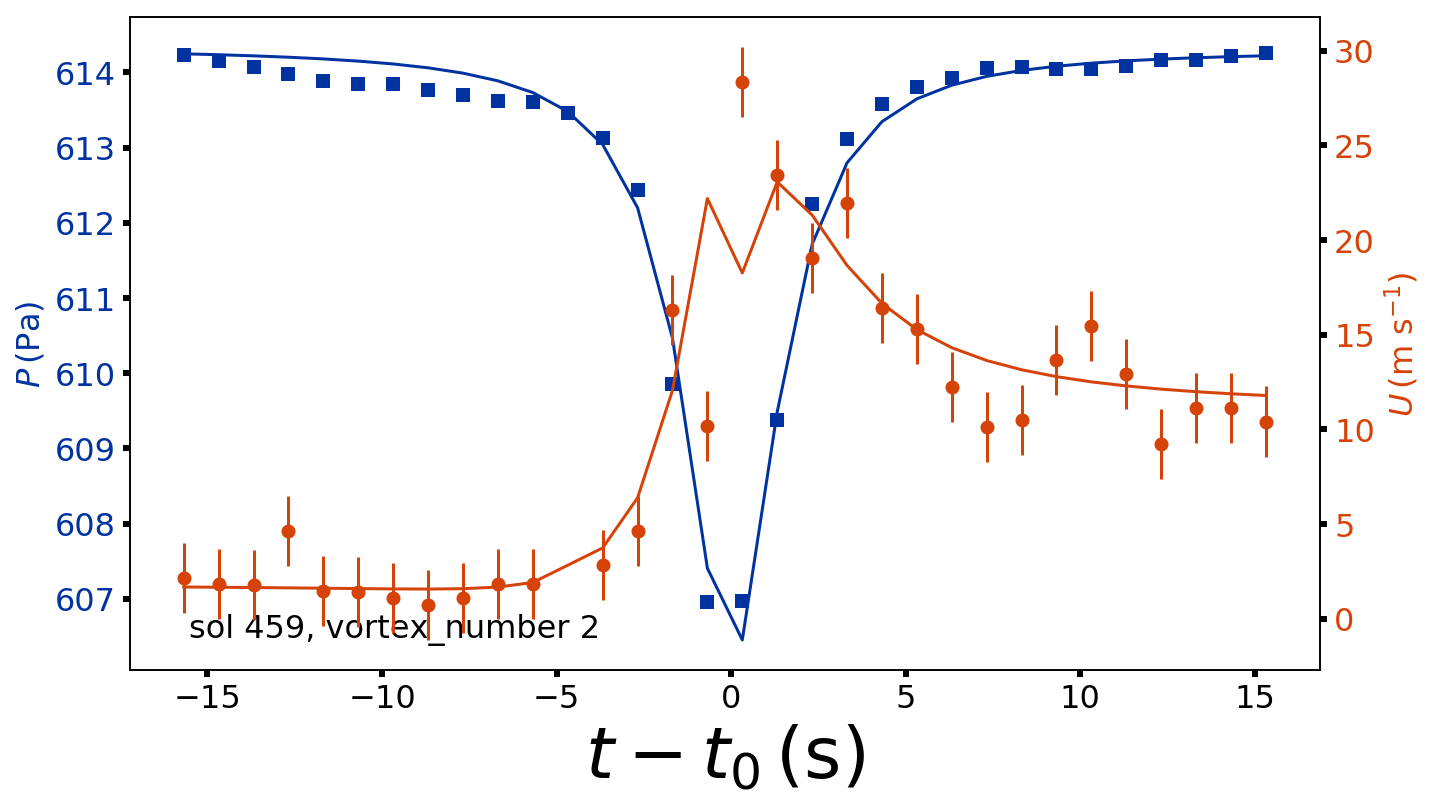

In [2]:
# Read in pressure fits
filename = "all_vortices_with_diameters.csv"
data = np.genfromtxt(filename, delimiter=',', names=True, dtype=None)

# Read in the other data file
ind = data['Diameter_unc'] > 0
vortex_number = data['vortex_number'][ind]
sols = data['sol'][ind]
t0 = data['t0'][ind]
DeltaP = data['DeltaP'][ind]
Gamma = data['Gamma'][ind]
Diameters = data['Diameter'][ind]
intercept = data['intercept'][ind]
slope = data['slope'][ind]

# Fit the vortices in order from deepest to least deep until we can't fit 'em no more
srt = np.argsort(DeltaP)[::-1]

# which_vortex = 6
# which_vortex = srt[500]
which_vortex = srt[0]

fig = plt.figure(figsize=(6*aspect_ratio, 6))

ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

ax1.set_xlabel(r'$t - t_0\, \left({\rm s} \right)$', fontsize=36)

wind_x, wind_y, wind_sigma, pressure_x, pressure_y, pressure_sigma, density =\
    retrieve_wind_and_pressure(sols[which_vortex], dr, dr_wind, t0[which_vortex], Gamma[which_vortex])

sampling = np.median(wind_x[1:] - wind_x[0:-1])

simple_profile = simple_wind_profile(wind_x, wind_y, 0., Gamma[which_vortex]/3600., sampling)
U1, U2, Vobs = simple_wind_profile_parameters(wind_x, wind_y, 0., Gamma[which_vortex]/3600., sampling)
Pact, Vact, Dact, bact = calculate_act_values(density, Vobs, DeltaP[which_vortex], Diameters[which_vortex])

simple_BIC = BIC(wind_y, simple_profile, deg=3, sd=wind_sigma)
print("simple_profile BIC: ", simple_BIC)
print("U1, U2: ", U1, U2) 
print("DeltaP[which_vortex], Vobs: ", DeltaP[which_vortex], Vobs)
print("wind_sigma: ", wind_sigma)
simple_Vobs_sigma = np.abs(Vobs)/wind_sigma
print("np.abs(Vobs)/wind_sigma: ", simple_Vobs_sigma)
print("Pact, Vact: ", Pact, Vact)
print("bact, Diameter, Dact: ", bact, Diameters[which_vortex], Dact)
print()

make_plot(ax1, ax2, wind_x, wind_y, wind_sigma, pressure_x, pressure_y, pressure_sigma,
          t0[which_vortex], intercept[which_vortex], slope[which_vortex], DeltaP[which_vortex], Gamma[which_vortex])

popt, uncertainties, U1, U2 = fit_wind_profile(wind_x*3600., wind_y, wind_sigma, 0., Gamma[which_vortex],
                                               [-30., -1.])
full_profile = wind_profile(wind_x*3600., 0., popt[0], U1, U2, popt[1], Gamma[which_vortex])
print(np.median(np.abs(full_profile - wind_y)))

Pact, Vact, Dact, bact = calculate_act_values(density, popt[0], DeltaP[which_vortex], Diameters[which_vortex])

full_BIC = BIC(wind_y, full_profile, deg=4, sd=wind_sigma)
print("full_profile BIC: ", full_BIC)
print("U1, U2: ", U1, U2) 
print("DeltaP[which_vortex], Vobs: ", DeltaP[which_vortex], popt[0])
print("wind_sigma: ", wind_sigma)
full_Vobs_sigma = np.abs(popt[0])/wind_sigma
print("np.abs(Vobs)/wind_sigma: ", full_Vobs_sigma)
print("Pact, Vact: ", Pact, Vact)
print("bact, Diameters, Dact: ", bact, Diameters[which_vortex], Dact)

ax2.plot(wind_x*3600., full_profile, color=BoiseState_orange)

ax1.text(0.05, 0.05, "sol %i, vortex_number %i" % (sols[which_vortex], vortex_number[which_vortex]), 
         transform=ax1.transAxes, fontsize=16)

In [18]:
# Read in pressure fits
filename = "all_vortices_with_diameters.csv"
data = np.genfromtxt(filename, delimiter=',', names=True, dtype=None)

# Read in the other data file
ind = data['Diameter_unc'] > 0
vortex_number = data['vortex_number'][ind]
sols = data['sol'][ind]
t0 = data['t0'][ind]
DeltaP = data['DeltaP'][ind]
Gamma = data['Gamma'][ind]
Diameters = data['Diameter'][ind]
intercept = data['intercept'][ind]
slope = data['slope'][ind]

# Fit the vortices in order from deepest to least deep until we can't fit 'em no more
srt = np.argsort(DeltaP)[::-1]

which_vortex = srt[0]

# fig = plt.figure(figsize=(6*aspect_ratio, 6))

# ax1 = fig.add_subplot(111)
# ax2 = ax1.twinx()

# ax1.set_xlabel(r'$t - t_0\, \left({\rm s} \right)$', fontsize=36)

# wind_x, wind_y, wind_sigma, pressure_x, pressure_y, pressure_sigma, density =\
#     retrieve_wind_and_pressure(sols[which_vortex], dr, dr_wind, t0[which_vortex], Gamma[which_vortex])

# sampling = np.median(wind_x[1:] - wind_x[0:-1])

# simple_profile = simple_wind_profile(wind_x, wind_y, 0., Gamma[which_vortex]/3600., sampling)
# U1, U2, Vobs = simple_wind_profile_parameters(wind_x, wind_y, 0., Gamma[which_vortex]/3600., sampling)
# Pact, Vact, Dact, bact = calculate_act_values(density, Vobs, DeltaP[which_vortex], Diameters[which_vortex])

# simple_BIC = BIC(wind_y, simple_profile, deg=3, sd=wind_sigma)
# print("simple_profile BIC: ", simple_BIC)
# print("U1, U2: ", U1, U2) 
# print("DeltaP[which_vortex], Vobs: ", DeltaP[which_vortex], Vobs)
# print("wind_sigma: ", wind_sigma)
# simple_Vobs_sigma = np.abs(Vobs)/wind_sigma
# print("np.abs(Vobs)/wind_sigma: ", simple_Vobs_sigma)
# print("Pact, Vact: ", Pact, Vact)
# print("bact, Diameter, Dact: ", bact, Diameters[which_vortex], Dact)
# print()

# make_plot(ax1, ax2, wind_x, wind_y, wind_sigma, pressure_x, pressure_y, pressure_sigma,
#           t0[which_vortex], intercept[which_vortex], slope[which_vortex], DeltaP[which_vortex], Gamma[which_vortex], 
#          U1, Vobs, U2)

# popt, uncertainties, U1, U2 = fit_wind_profile(wind_x*3600., wind_y, wind_sigma, 0., Gamma[which_vortex],
#                                                [-30., -1.])
# full_profile = wind_profile(wind_x*3600., 0., popt[0], U1, U2, popt[1], Gamma[which_vortex])

# Pact, Vact, Dact, bact = calculate_act_values(density, popt[0], DeltaP[which_vortex], Diameters[which_vortex])

# full_BIC = BIC(wind_y, full_profile, deg=4, sd=wind_sigma)
# print("full_profile BIC: ", full_BIC)
# print("U1, U2: ", U1, U2) 
# print("DeltaP[which_vortex], Vobs: ", DeltaP[which_vortex], popt[0])
# print("wind_sigma: ", wind_sigma)
# full_Vobs_sigma = np.abs(popt[0])/wind_sigma
# print("np.abs(Vobs)/wind_sigma: ", full_Vobs_sigma)
# print("Pact, Vact: ", Pact, Vact)
# print("bact, Diameters, Dact: ", bact, Diameters[which_vortex], Dact)

# ax2.plot(wind_x*3600., full_profile, color=BoiseState_orange)

# ax1.text(0.05, 0.05, "sol %i, vortex_number %i" % (sols[which_vortex], vortex_number[which_vortex]), 
#          transform=ax1.transAxes, fontsize=16)

filename = "wind_data.txt"
zipped = list(zip(wind_x*86400., wind_y))
np.savetxt(filename, zipped, fmt='%g, %g')

filename = "pressure_data.txt"
zipped = list(zip(pressure_x*86400., pressure_y))
np.savetxt(filename, zipped, fmt='%g, %g')


full_profile chi-squared:  3.825106203733422
U1, U2:  1.787 11.122499999999999
DeltaP[which_vortex], Vobs:  8.18645 -28.200697375304426
wind_sigma:  1.8504999999999994
np.abs(Vobs)/wind_sigma:  15.239501418700046
Pact, Vact:  11.38917237546852 31.36278094592297
bact, Diameters, Dact:  1.5014264230364542 5.66266 4.800895027016508

full_profile chi-squared:  6.073239520028915
U1, U2:  6.2940000000000005 9.5535
DeltaP[which_vortex], Vobs:  6.97169 -7.744221204057067
wind_sigma:  1.2930000000000006
np.abs(Vobs)/wind_sigma:  5.989343545287752
Pact, Vact:  11.38917237546852 31.36278094592297
bact, Diameters, Dact:  1.5014264230364542 13.4925 4.800895027016508

full_profile chi-squared:  21.312383026628645
U1, U2:  2.169 10.9155
DeltaP[which_vortex], Vobs:  6.0968 -22.939943387085886
wind_sigma:  0.6809999999999992
np.abs(Vobs)/wind_sigma:  33.68567310878989
Pact, Vact:  8.152284620173965 26.41396449703314
bact, Diameters, Dact:  3.249594082799635 12.9432 11.193166639880529


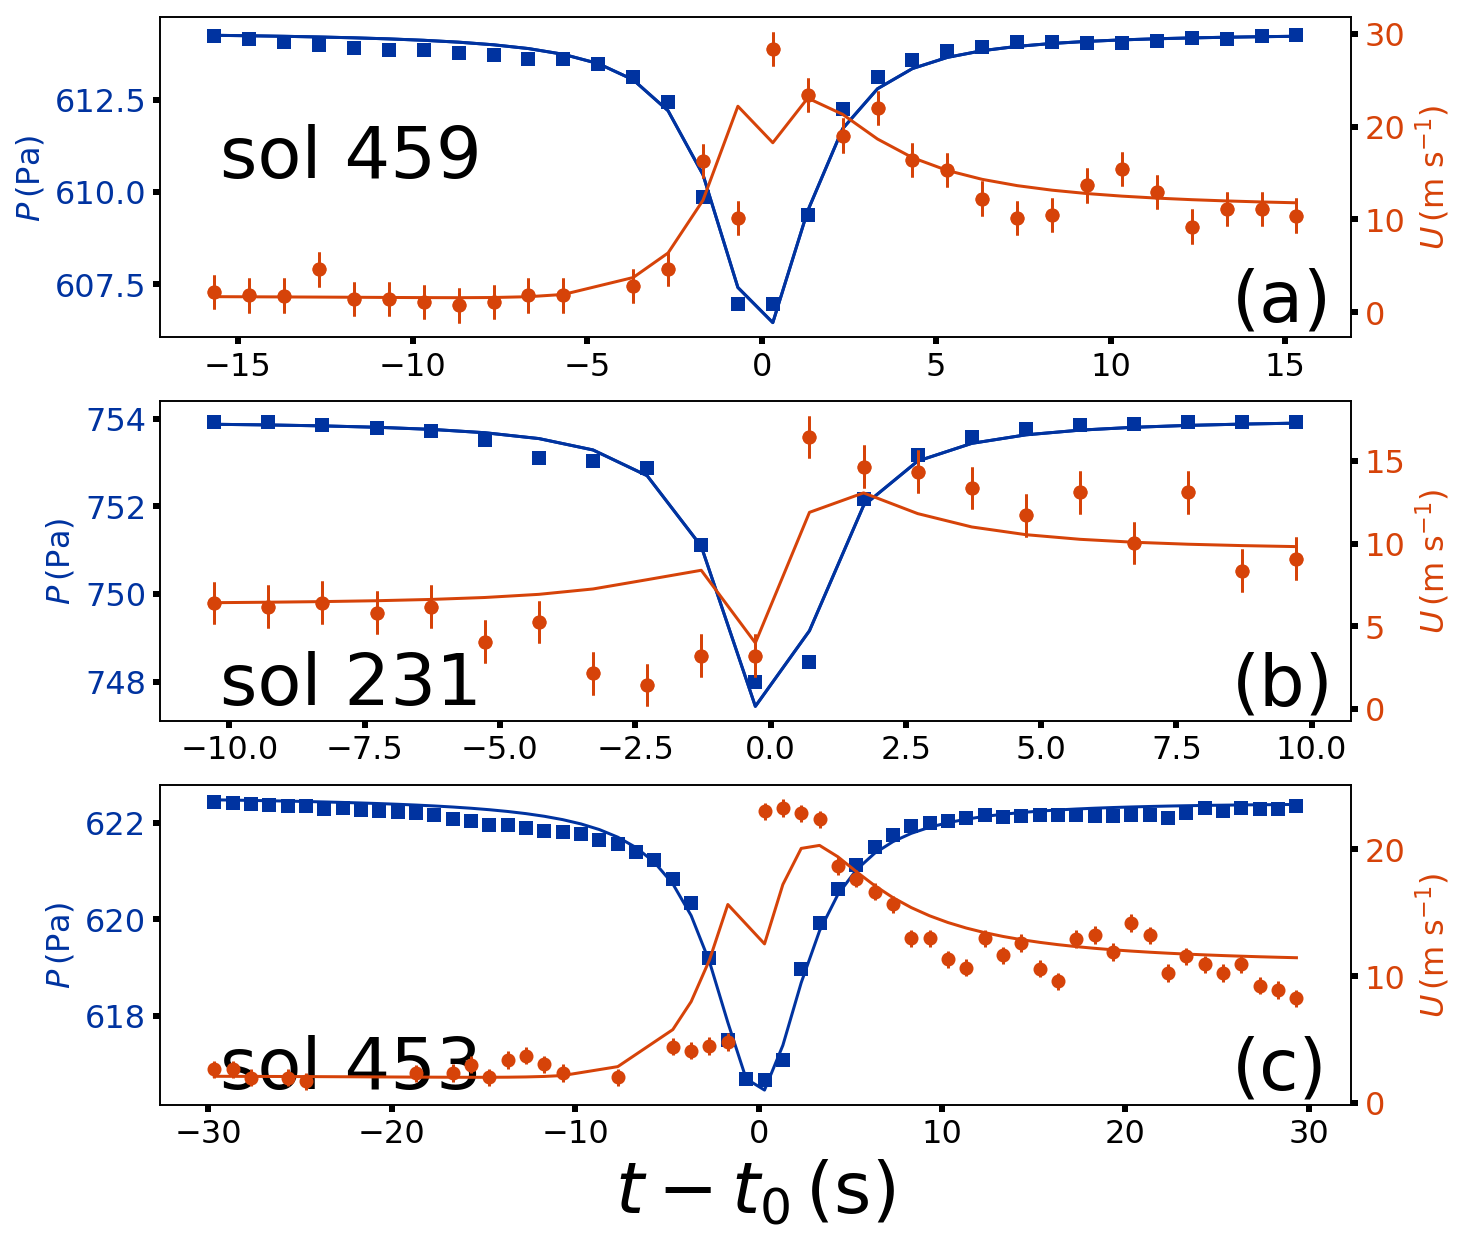

In [4]:
fig = plt.figure(figsize=(6*aspect_ratio, 10))

# Read in pressure fits
filename = "all_vortices_with_diameters.csv"
data = np.genfromtxt(filename, delimiter=',', names=True, dtype=None)

# Read in the other data file
ind = data['Diameter_unc'] > 0
sols = data['sol'][ind]
t0 = data['t0'][ind]
DeltaP = data['DeltaP'][ind]
Gamma = data['Gamma'][ind]
Diameters = data['Diameter'][ind]
intercept = data['intercept'][ind]
slope = data['slope'][ind]

# Fit the vortices in order from deepest to least deep until we can't fit 'em no more
srt = np.argsort(DeltaP)[::-1]
# 77 looks like crap
# 76 looks fine

### Deepest vortex ###

which_vortex = srt[0]

ax1 = fig.add_subplot(311)
ax2 = ax1.twinx()

wind_x, wind_y, wind_sigma, pressure_x, pressure_y, pressure_sigma, density =\
    retrieve_wind_and_pressure(sols[which_vortex], dr, dr_wind, t0[which_vortex], Gamma[which_vortex])

sampling = np.median(wind_x[1:] - wind_x[0:-1])

make_plot(ax1, ax2, wind_x, wind_y, wind_sigma, pressure_x, pressure_y, pressure_sigma,
          t0[which_vortex], intercept[which_vortex], slope[which_vortex], DeltaP[which_vortex], Gamma[which_vortex])
print()
popt, uncertainties, U1, U2 = fit_wind_profile(wind_x*3600., wind_y, wind_sigma, 0., Gamma[which_vortex],
                                               [-30., -1.])
full_profile = wind_profile(wind_x*3600., 0., popt[0], U1, U2, popt[1], Gamma[which_vortex])
full_BIC_chisq = redchisqg(wind_y, full_profile, deg=4, sd=wind_sigma)
print("full_profile chi-squared: ", full_BIC_chisq)

make_plot(ax1, ax2, wind_x, wind_y, wind_sigma, pressure_x, pressure_y, pressure_sigma,
          t0[which_vortex], intercept[which_vortex], slope[which_vortex], DeltaP[which_vortex], Gamma[which_vortex])

Pact, Vact, Dact, bact = calculate_act_values(density, popt[0], DeltaP[which_vortex], Diameters[which_vortex])

print("U1, U2: ", U1, U2) 
print("DeltaP[which_vortex], Vobs: ", DeltaP[which_vortex], popt[0])
print("wind_sigma: ", wind_sigma)
full_Vobs_sigma = np.abs(popt[0])/wind_sigma
print("np.abs(Vobs)/wind_sigma: ", full_Vobs_sigma)
print("Pact, Vact: ", Pact, Vact)
print("bact, Diameters, Dact: ", bact, Diameters[which_vortex], Dact)

ax2.plot(wind_x*3600., full_profile, color=BoiseState_orange)

ax1.text(0.9, 0.05, "(a)", fontsize=36, transform=ax1.transAxes)
ax1.text(0.05, 0.5, "sol %i" % sols[which_vortex], fontsize=36, transform=ax1.transAxes)

print()

# ### 2nd Deepest vortex ###

which_vortex = srt[1]

ax3 = fig.add_subplot(312)
ax4 = ax3.twinx()

wind_x, wind_y, wind_sigma, pressure_x, pressure_y, pressure_sigma, density =\
    retrieve_wind_and_pressure(sols[which_vortex], dr, dr_wind, t0[which_vortex], Gamma[which_vortex])

sampling = np.median(wind_x[1:] - wind_x[0:-1])

make_plot(ax3, ax4, wind_x, wind_y, wind_sigma, pressure_x, pressure_y, pressure_sigma,
          t0[which_vortex], intercept[which_vortex], slope[which_vortex], DeltaP[which_vortex], Gamma[which_vortex])

popt, uncertainties, U1, U2 = fit_wind_profile(wind_x*3600., wind_y, wind_sigma, 0., Gamma[which_vortex],
                                               [-30., -1.])
full_profile = wind_profile(wind_x*3600., 0., popt[0], U1, U2, popt[1], Gamma[which_vortex])
full_BIC_chisq = redchisqg(wind_y, full_profile, deg=4, sd=wind_sigma)
print("full_profile chi-squared: ", full_BIC_chisq)

make_plot(ax3, ax4, wind_x, wind_y, wind_sigma, pressure_x, pressure_y, pressure_sigma,
          t0[which_vortex], intercept[which_vortex], slope[which_vortex], DeltaP[which_vortex], Gamma[which_vortex])

print("U1, U2: ", U1, U2) 
print("DeltaP[which_vortex], Vobs: ", DeltaP[which_vortex], popt[0])
print("wind_sigma: ", wind_sigma)
full_Vobs_sigma = np.abs(popt[0])/wind_sigma
print("np.abs(Vobs)/wind_sigma: ", full_Vobs_sigma)
print("Pact, Vact: ", Pact, Vact)
print("bact, Diameters, Dact: ", bact, Diameters[which_vortex], Dact)

ax4.plot(wind_x*3600., full_profile, color=BoiseState_orange)

ax3.text(0.9, 0.05, "(b)", fontsize=36, transform=ax3.transAxes)
ax3.text(0.05, 0.05, "sol %i" % sols[which_vortex], fontsize=36, transform=ax3.transAxes)

print()

# ### 3rd Deepest vortex ###

which_vortex = srt[2]

ax5 = fig.add_subplot(313)
ax6 = ax5.twinx()

wind_x, wind_y, wind_sigma, pressure_x, pressure_y, pressure_sigma, density =\
    retrieve_wind_and_pressure(sols[which_vortex], dr, dr_wind, t0[which_vortex], Gamma[which_vortex])

sampling = np.median(wind_x[1:] - wind_x[0:-1])

popt, uncertainties, U1, U2 = fit_wind_profile(wind_x*3600., wind_y, wind_sigma, 0., Gamma[which_vortex],
                                               [-30., -1.])

full_profile = wind_profile(wind_x*3600., 0., popt[0], U1, U2, popt[1], Gamma[which_vortex])
full_BIC_chisq = redchisqg(wind_y, full_profile, deg=4, sd=wind_sigma)
print("full_profile chi-squared: ", full_BIC_chisq)

make_plot(ax5, ax6, wind_x, wind_y, wind_sigma, pressure_x, pressure_y, pressure_sigma,
          t0[which_vortex], intercept[which_vortex], slope[which_vortex], DeltaP[which_vortex], Gamma[which_vortex])

Pact, Vact, Dact, bact = calculate_act_values(density, popt[0], DeltaP[which_vortex], Diameters[which_vortex])

print("U1, U2: ", U1, U2) 
print("DeltaP[which_vortex], Vobs: ", DeltaP[which_vortex], popt[0])
print("wind_sigma: ", wind_sigma)
full_Vobs_sigma = np.abs(popt[0])/wind_sigma
print("np.abs(Vobs)/wind_sigma: ", full_Vobs_sigma)
print("Pact, Vact: ", Pact, Vact)
print("bact, Diameters, Dact: ", bact, Diameters[which_vortex], Dact)

ax6.plot(wind_x*3600., full_profile, color=BoiseState_orange)

ax5.set_xlabel(r'$t - t_0\, \left({\rm s} \right)$', fontsize=36)
ax5.text(0.05, 0.05, "sol %i" % sols[which_vortex], fontsize=36, transform=ax5.transAxes)
ax5.text(0.9, 0.05, "(c)", fontsize=36, transform=ax5.transAxes)

fig.savefig("../figures/vortices_and_windspeed.png", dpi=500, bbox_inches="tight")

2021 Jan 29 -- Check today's notes for the derivation of these equations:
$$
\frac{\partial \Delta P_{\rm act}}{\partial V_{\rm obs}} = \left( \frac{\Delta P_{\rm act}}{\Delta P_{\rm obs}} \right) \left( \frac{\rho V_{\rm obs}}{2} \right)\\
\frac{\partial \Delta P_{\rm act}}{\partial \Delta P_{\rm obs}} = \left( \frac{\Delta P_{\rm act}}{\Delta P_{\rm obs}} \right) \left[ 1 + \left( \frac{\Delta P_{\rm act}}{\Delta P_{\rm obs}} \right) \left( \frac{\rho V_{\rm obs}^2}{4 \Delta P_{\rm obs}} \right) \right]\\
\frac{\partial V_{\rm act}}{\partial \Delta P_{\rm act}} = \frac{V_{\rm act}}{2\Delta P_{\rm act}}\\
\frac{\partial D_{\rm act}}{\partial D_{\rm obs}} = \left( \frac{D_{\rm obs}}{D_{\rm act}} \right)\\
\frac{\partial D_{\rm act}}{\partial b} = -\left( \frac{2b}{D_{\rm act}} \right)
$$

In [5]:
# 2020 Sep 9 - Commented everything out
# 2021 Jan 29 - Recalculate and save uncertainties

directory = "wind_profile_figures"

filename = "all_vortices_with_diameters.csv"
data = np.genfromtxt(filename, delimiter=',', names=True, dtype=None)
ind = data['Diameter_unc'] > 0

vortex_number = data['vortex_number'][ind]
sols = data['sol'][ind]
t0 = data['t0'][ind]
t0_unc =  data['t0_unc'][ind]
DeltaP = data['DeltaP'][ind]
DeltaP_unc = data['DeltaP_unc'][ind]
Gamma = data['Gamma'][ind]
Gamma_unc = data['Gamma_unc'][ind]
slope = data['slope'][ind]
slope_unc = data['slope_unc'][ind]
intercept = data['intercept'][ind]
intercept_unc = data['intercept_unc'][ind]
U = data['U'][ind]
U_unc = data['U_unc'][ind]
Diameter = data['Diameter'][ind]
Diameter_unc = data['Diameter_unc'][ind]

srt_ind = np.sort(DeltaP)[::-1]

new_filename = "all_vortices_with_diameters_and_actual_values.csv"
# f = open(new_filename, "w")
# f.write("# srt_ind, vortex_number, sols, DeltaP, Diameter, U1, U2, Vobs, simple_Pact, simple_Vact, simple_Dact, "+\
#         "simple_bact, simple_BIC, simple_Vobs_sigma, full_Vobs, full_b, full_Pact, full_Vact, full_Dact, "+\
#         "full_bact, full_BIC, full_Vobs_sigma\n")

# f.write("# srt_ind, vortex_number, sols, t0, t0_unc, DeltaP, DeltaP_unc, Gamma, Gamma_unc, slope, slope_unc, " +\
#         "slope, slope_unc, intercept, intercept_unc, U, U_unc, Diameter, Diameter_unc, " +\
#         "full_Vobs, full_Vobs_unc, full_b, full_b_unc, "+\
#         "full_Pact, full_Pact_unc, full_Vact, full_Vact_unc, full_Dact, full_Dact_unc, "+\
#         "full_bact, full_bact_unc, full_Vobs_sigma\n")

print("# srt_ind, vortex_number, sols, t0, t0_unc, DeltaP, DeltaP_unc, Gamma, Gamma_unc, " +\
        "slope, slope_unc, intercept, intercept_unc, U, U_unc, Diameter, Diameter_unc, " +\
        "full_Vobs, full_Vobs_unc, full_b, full_b_unc, "+\
        "full_Pact, full_Pact_unc, full_Vact, full_Vact_unc, full_Dact, full_Dact_unc, full_Vobs_sigma\n")

last_sol = 0
# for srt_ind in range(len(sols)):
for srt_ind in [100]:
    
#     figname = directory + "/data_conditioning_sol_%i_vortex%i.png" % (sols[srt_ind], vortex_number[srt_ind])

# To keep from loading the data file for the same sol over and over again for each of that sol's vortices, 
#   let's load that sol's data once.

    if(sols[srt_ind] != last_sol):
        wind_LTST, wind_LTST_and_sol, wind_data = find_wind(sols[srt_ind], dr_wind=dr_wind)
        wind_LTST_and_sol -= 24.*sols[srt_ind]
        
        LTST, LTST_and_sol, sol_data = retrieve_data(sols[srt_ind], dr=dr)
        LTST_and_sol -= 24.*sols[srt_ind]
        
        last_sol = sols[srt_ind]
        
#     try:
#         fig = plt.figure(figsize=(6*aspect_ratio, 6))
#         ax1 = fig.add_subplot(111)
#         ax2 = ax1.twinx()

    wind_x, wind_y, wind_sigma, pressure_x, pressure_y, pressure_sigma, density =\
        abbrev_retrieve_wind_and_pressure(wind_LTST, wind_LTST_and_sol, wind_data, LTST, LTST_and_sol, sol_data, 
                                      t0[srt_ind], Gamma[srt_ind])
    # What time resolution?
    sampling = np.median(wind_x[1:] - wind_x[0:-1])        


    # 2021 Jan 29 - I originally had two wind profiles I fit to the data. This simple profile, though, turns out
    # to be complete nonsense. I retain the code below for completeness but it's commented out.

#         simple_profile = simple_wind_profile(wind_x, wind_y, 0., Gamma[srt_ind]/3600., sampling)
#         U1, U2, Vobs = simple_wind_profile_parameters(wind_x, wind_y, 0., Gamma[srt_ind]/3600., sampling)
#         simple_Pact, simple_Vact, simple_Dact, simple_bact =\
#             calculate_act_values(density, Vobs, DeltaP[srt_ind], Diameter[srt_ind])

#         simple_BIC = BIC(wind_y, simple_profile, deg=3, sd=wind_sigma)
#         simple_Vobs_sigma = np.abs(Vobs)/wind_sigma

#         make_plot(ax5, ax6, wind_x, wind_y, wind_sigma, pressure_x, pressure_y, pressure_sigma,
#                   t0[srt_ind], intercept[srt_ind], slope[srt_ind], DeltaP[srt_ind], 
#                   Gamma[srt_ind], U1, Vobs, U2)
#         make_plot(ax1, ax2, wind_x, wind_y, wind_sigma, pressure_x, pressure_y, pressure_sigma,
#                   t0[srt_ind], intercept[srt_ind], slope[srt_ind], DeltaP[srt_ind], Gamma[srt_ind], U1, Vobs, U2)

    # 2021 Jan 29 - Here's the real wind profile.
    popt, uncertainties, U1, U2 = fit_wind_profile(wind_x*3600., wind_y, wind_sigma, 0., Gamma[srt_ind],
                                               [-30., -1.])
    full_Vobs_sigma = np.abs(popt[0]/uncertainties[0])
#         full_profile = wind_profile(wind_x*3600., 0., popt[0], U1, U2, popt[1], Gamma[srt_ind])
#         ax2.plot(wind_x*3600., full_profile, color=BoiseState_orange)
    full_Pact, full_Vact, full_Dact, full_bact =\
        calculate_act_values(density, popt[0], DeltaP[srt_ind], Diameter[srt_ind])
    full_Pact_unc, full_Vact_unc, full_Dact_unc =\
        sigma_act(uncertainties[0], DeltaP_unc[srt_ind], Diameter_unc[srt_ind], uncertainties[1],
                  full_Pact, full_Vact, full_Dact, DeltaP[srt_ind], popt[0], Diameter[srt_ind], popt[1], density)

#         ax1.set_xlabel(r'$t - t_0\, \left({\rm s} \right)$', fontsize=36)

#         plt.suptitle("sol %i, vortex_number %i" % (sols[srt_ind], vortex_number[srt_ind]), fontsize=16)

    print(("%i, %i, %i, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, "+\
           "%g, %g, %g") %\
          (srt_ind, vortex_number[srt_ind], sols[srt_ind], t0[srt_ind], t0_unc[srt_ind],
           DeltaP[srt_ind], DeltaP_unc[srt_ind], Gamma[srt_ind], Gamma_unc[srt_ind],
           slope[srt_ind], slope_unc[srt_ind], intercept[srt_ind], intercept_unc[srt_ind], 
           U[srt_ind], U_unc[srt_ind], Diameter[srt_ind], Diameter_unc[srt_ind],
           popt[0], uncertainties[0], popt[1], uncertainties[1], 
           full_Pact, full_Pact_unc, full_Vact, full_Vact_unc, full_Dact, full_Dact_unc, full_Vobs_sigma))

#     print(srt_ind, vortex_number[srt_ind], sols[srt_ind], t0[srt_ind], t0_unc[srt_ind],
#            DeltaP[srt_ind], DeltaP_unc[srt_ind], Gamma[srt_ind], Gamma_unc[srt_ind],
#            slope[srt_ind], slope_unc[srt_ind], intercept[srt_ind], intercept_unc[srt_ind], 
#            U[srt_ind], U_unc[srt_ind], Diameter[srt_ind], Diameter_unc[srt_ind],
#            popt[0], uncertainties[0], popt[1], uncertainties[1], 
#            full_Pact, full_Pact_unc, full_Vact, full_Vact_unc, full_Dact, full_Dact_unc, 
#            full_bact, full_bact_unc, full_Vobs_sigma)

#         f.write("%i, %i, %i, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g\n" %\
#                 (srt_ind, vortex_number[srt_ind], sols[srt_ind], DeltaP[srt_ind], Diameter[srt_ind], U1, U2,
#                  Vobs, simple_Pact, simple_Vact, simple_Dact, simple_bact, simple_BIC, simple_Vobs_sigma,
#                  popt[0], popt[1], full_Pact, full_Vact, full_Dact, full_bact, full_BIC, full_Vobs_sigma))

#         fig.savefig(figname, dpi=500, bbox_inches="tight")
    
#     except:
#         print("sol %i, vortex_number %i didn't work!" % (sols[srt_ind], vortex_number[srt_ind]))
    
# f.close()

# srt_ind, vortex_number, sols, t0, t0_unc, DeltaP, DeltaP_unc, Gamma, Gamma_unc, slope, slope_unc, intercept, intercept_unc, U, U_unc, Diameter, Diameter_unc, full_Vobs, full_Vobs_unc, full_b, full_b_unc, full_Pact, full_Pact_unc, full_Vact, full_Vact_unc, full_Dact, full_Dact_unc, full_Vobs_sigma

100, 0, 88, 14.9477, 0.000178929, 0.534714, 0.0253919, 27.1137, 1.96, -5.51191, 0.0703459, 701.738, 0.00403439, 3.7665, 0.00889561, 102.124, 7.38628, -0.00284183, 1.47797, -1.30507, 612.43, 0.534714, 0.0253919, 6.40263, 0.15202, 102.124, 17.308, -0.0019228


Because I keep forgetting it:
$$
V_{\rm act} = \frac{1}{2} V_{\rm obs} \left( \dfrac{1 + \left( 2b/D_{\rm act} \right)^2}{\left( 2b/D_{\rm act} \right)} \right).
$$

3.64423
30.4298


Text(0.8, 0.05, '(c)')

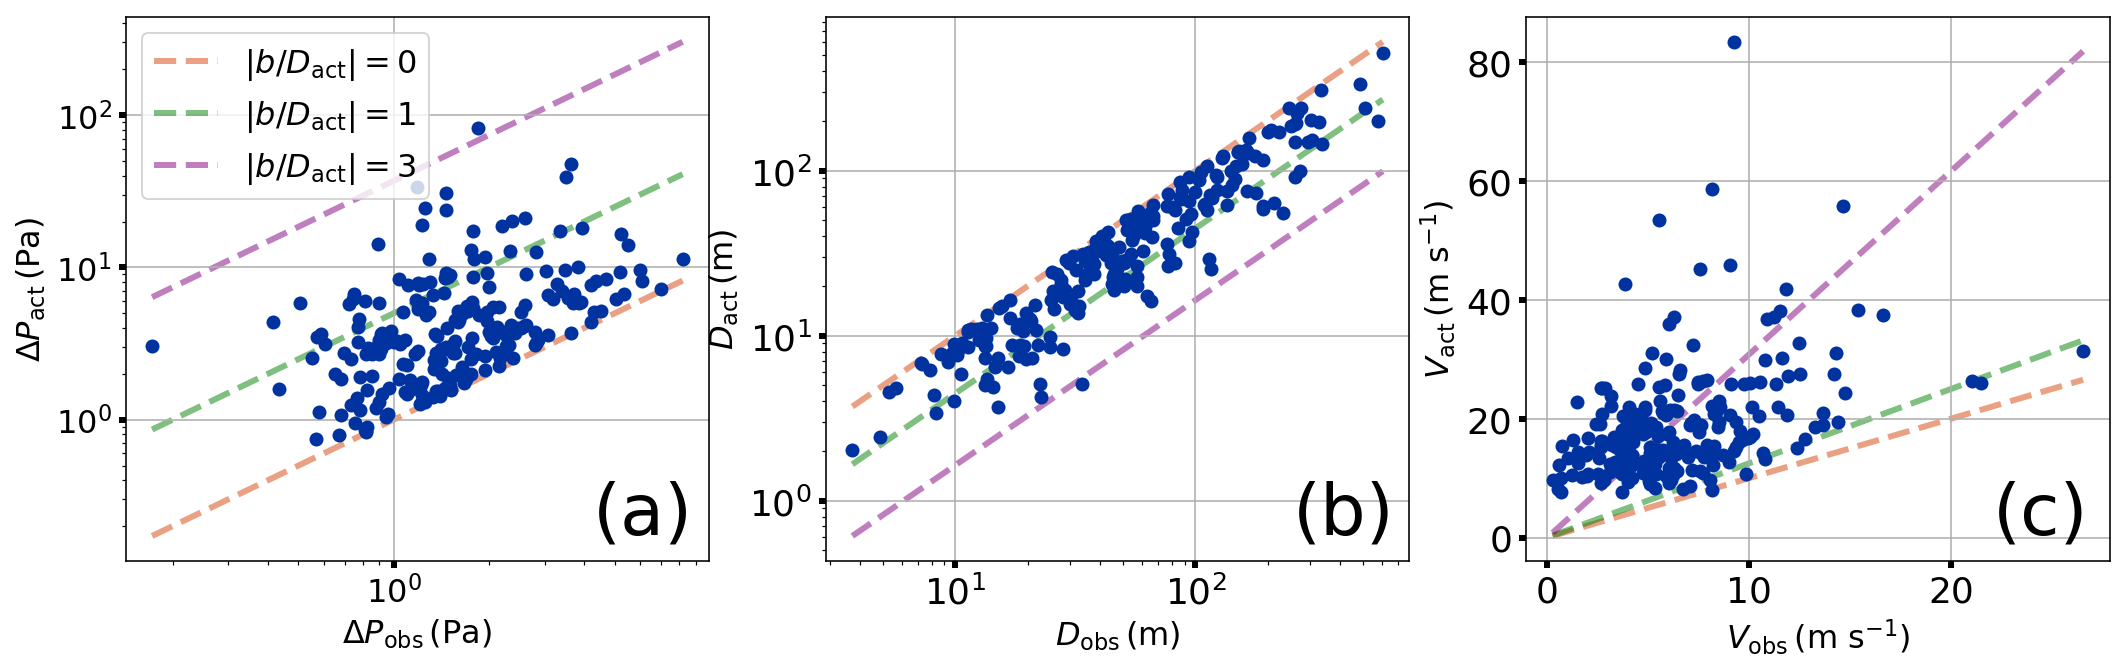

In [120]:
# 2020 Oct 1 - I'm going to use the actual fit values for b to determine the actual parameters
def calc_Dact(Dobs, b):
    return np.sqrt(Dobs**2 - (2.*b)**2)

def calc_Pact(Pobs, Dact, b):
    return Pobs*(1. + (2.*b/Dact)**2)

def calc_Vact(Vobs, Dact, b):
    return 0.5*Vobs*(1 + (2.*b/Dact)**2)/(2.*b/Dact)

filename = "all_vortices_with_diameters_and_actual_values.csv"
# ('srt_ind', 'vortex_number', 'sols', 'DeltaP', 'Diameter', 'U1', 'U2', 'Vobs', 'simple_Pact', 'simple_Vact', 
# 'simple_Dact', 'simple_bact', 'simple_BIC', 'simple_Vobs_sigma', 'full_Vobs', 'full_b', 'full_Pact', 'full_Vact', 
# 'full_Dact', 'full_bact', 'full_BIC', 'full_Vobs_sigma')
data = np.genfromtxt(filename, delimiter=',', names=True, dtype=None)
# ind = (2.*(data['simple_Pact'] - data['full_Pact'])/(data['simple_Pact'] + data['full_Pact']) < 0.25) &\
#     (2.*(data['simple_Dact'] - data['full_Dact'])/(data['simple_Dact'] + data['full_Dact']) < 0.25) &\
# (2.*(data['Vobs'] - data['full_Vact'])/(data['Vobs'] + data['full_Vact']) < 0.25) &\
#     (data['full_Vobs_sigma'] >= 3.) & (np.abs(data['full_b']/data['full_Dact']) < 10.)

ind = (data['full_Vobs_sigma'] >= 3.) &\
    (np.abs(data['full_b']/data['full_Dact']) < max_b_over_Dact) &\
    (np.abs(data['full_b']/data['full_Dact']) > min_b_over_Dact)

b_over_Dact = np.array([0, 1, 3])
colors=[BoiseState_orange, 'green', 'purple']

fig = plt.figure(figsize=(10*aspect_ratio, 5))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

# Dact = calc_Dact(data['Diameter'], data['full_b'])
# Pact = calc_Pact(data['DeltaP'], Dact, data['full_b'])
# Vact = calc_Vact(data['full_Vobs'], Dact, data['full_b'])

x = data['DeltaP'][ind]
# y = Pact[ind]
y = data['full_Pact'][ind]
print(np.quantile(y, 0.5))
ax1.loglog(x, y, marker='o', ls='', color=BoiseState_blue)
# Show the effects of off-center encounters
plot_x = np.linspace(np.min(x), np.max(x), 100)
for i in range(len(b_over_Dact)):
    cur_b_over_Dact = b_over_Dact[i]
    cur_color = colors[i]
    plot_y = plot_x*(1. + (2.*cur_b_over_Dact)**2)
    ax1.loglog(plot_x, plot_y, lw=3, ls='--', color=cur_color, zorder=-1, alpha=0.5,
               label=r'$|b/D_{\rm act}| = %i$' % cur_b_over_Dact)
# ax1.set_xlim([np.min([np.min(x), np.min(y)]), np.max([np.max(x), np.max(y)])])

ax1.legend(loc='upper left', fontsize=16)

x = data['Diameter'][ind]
# y = Dact[ind]
y = data['full_Dact'][ind]
print(np.quantile(y, 0.5))
ax2.loglog(x, y, marker='o', ls='', color=BoiseState_blue)
plot_x = np.linspace(np.min(x), np.max(x), 100)
for i in range(len(b_over_Dact)):
    cur_b_over_Dact = b_over_Dact[i]
    cur_color = colors[i]
    plot_y = plot_x/np.sqrt(1. + (2.*cur_b_over_Dact)**2)
    ax2.loglog(plot_x, plot_y, lw=3, ls='--', color=cur_color, zorder=-1, alpha=0.5)
# ax2.set_xlim([np.min([np.min(x), np.min(y)]), np.max([np.max(x), np.max(y)])])
    
# x = np.abs(data['full_b'][ind]/data['full_Dact'][ind])
x = np.abs(data['Vobs'][ind])
# y = Vact[ind]
y = np.abs(data['full_Vact'][ind])
ax3.plot(x, y, marker='o', ls='', color=BoiseState_blue)
plot_x = np.linspace(np.min(x), np.max(x), 100)

# plot_y = np.sqrt(plot_x/0.02)
# ax3.plot(plot_x, plot_y, lw=3, ls='--', color=BoiseState_orange)
for i in range(len(b_over_Dact)):
    cur_b_over_Dact = b_over_Dact[i]
    cur_color = colors[i]

    plot_y = 0.5*plot_x*(1 + (2.*cur_b_over_Dact)**2)/(2.*cur_b_over_Dact)
    if(cur_b_over_Dact == 0):
        plot_y = plot_x
    ax3.plot(plot_x, plot_y, lw=3, ls='--', color=cur_color, zorder=-1, alpha=0.5)
    
ax1.grid(True)
ax1.tick_params(labelsize=16)
ax1.set_xlabel(r'$\Delta P_{\rm obs}\, \left( {\rm Pa} \right)$', fontsize=16)
ax1.set_ylabel(r'$\Delta P_{\rm act}\, \left( {\rm Pa} \right)$', fontsize=16)
ax1.text(0.8, 0.05, '(a)', fontsize=36, transform=ax1.transAxes)

ax2.grid(True)
ax2.tick_params(labelsize=18)
ax2.set_xlabel(r'$D_{\rm obs}\, \left( {\rm m} \right)$', fontsize=16)
ax2.set_ylabel(r'$D_{\rm act}\, \left( {\rm m} \right)$', fontsize=16)
ax2.text(0.8, 0.05, '(b)', fontsize=36, transform=ax2.transAxes)

ax3.grid(True)
ax3.tick_params(labelsize=18)
ax3.set_xlabel(r'$V_{\rm obs}\, \left( {\rm m\ s^{-1}} \right)$', fontsize=16)
# ax3.set_xlabel(r'$\Delta P_{\rm act}\, \left( {\rm Pa} \right)$', fontsize=16)
# ax3.set_xlabel(r'$|b/D_{\rm act}|$', fontsize=16)
ax3.set_ylabel(r'$V_{\rm act}\, \left( {\rm m\ s^{-1}} \right)$', fontsize=16)
# ax3.yaxis.set_label_position("right")
# ax3.yaxis.tick_right()
# ax3.set_xlim([-10, 20])
# ax3.set_ylim([-10, 50])
ax3.text(0.8, 0.05, '(c)', fontsize=36, transform=ax3.transAxes)

# ax2.grid(True)
# ax2.tick_params(labelbottom=False, labelsize=24)
# ax2.set_ylabel(r'$N(x > P_{\rm act})$', fontsize=24)

# ax3.grid(True)
# ax3.yaxis.set_label_position("right")
# ax3.yaxis.tick_right()
# ax3.tick_params(labelsize=24)
# ax3.set_ylabel(r'$D_{\rm act}\, \left( {\rm m} \right)$', fontsize=36)
# ax3.set_xlabel(r'$N(x > D_{\rm act})$', fontsize=24)

# fig.savefig("../figures/Actual_vs_Observed_Values.png", dpi=500, bbox_inches='tight')

0.09777777777777778


Text(0, 0.5, '$V_{\\rm act}\\, \\left( {\\rm m\\ s^{-1}} \\right)$')

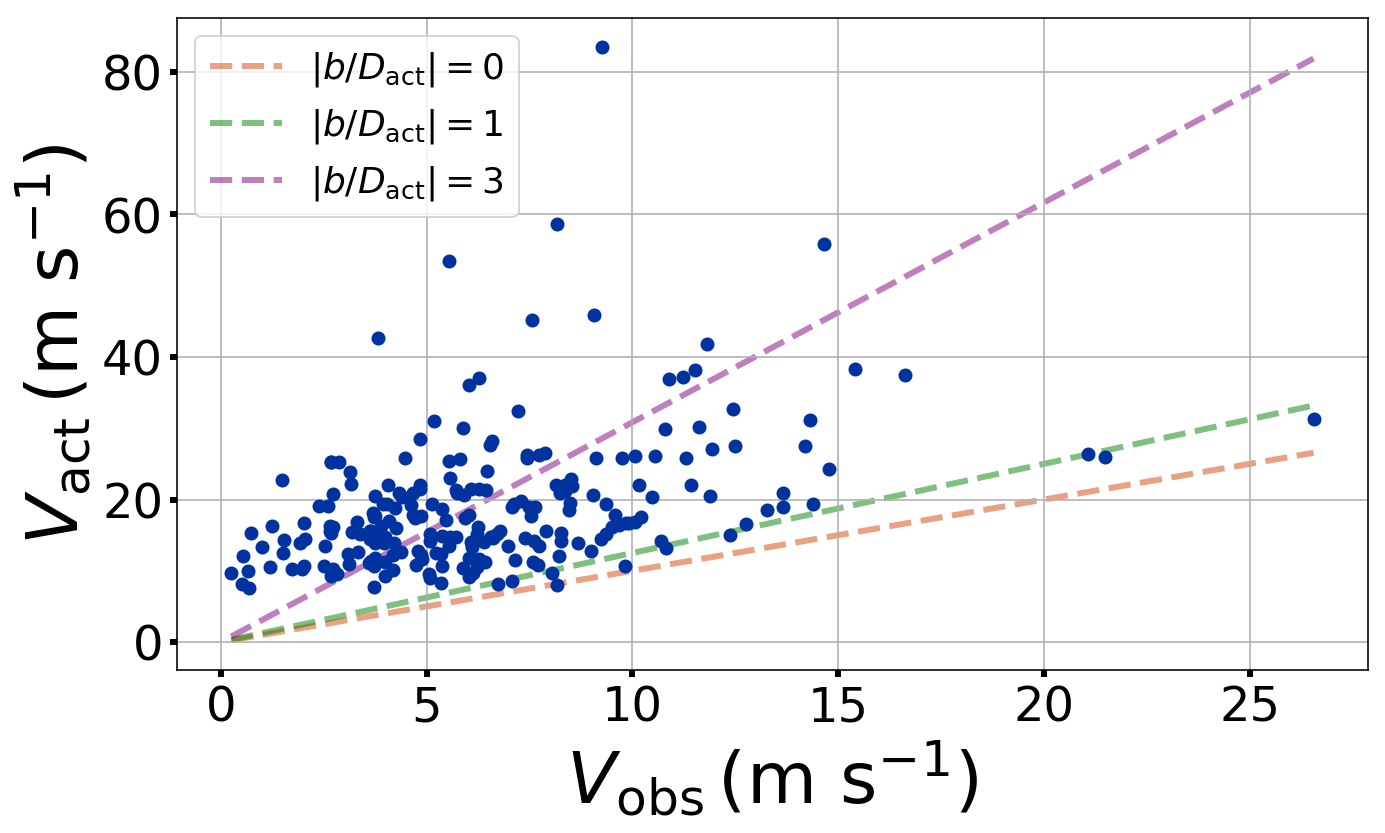

In [127]:
# 2020 Oct 1 - I'm going to use the actual fit values for b to determine the actual parameters

filename = "all_vortices_with_diameters_and_actual_values.csv"
# ('srt_ind', 'vortex_number', 'sols', 'DeltaP', 'Diameter', 'U1', 'U2', 'Vobs', 'simple_Pact', 'simple_Vact', 
# 'simple_Dact', 'simple_bact', 'simple_BIC', 'simple_Vobs_sigma', 'full_Vobs', 'full_b', 'full_Pact', 'full_Vact', 
# 'full_Dact', 'full_bact', 'full_BIC', 'full_Vobs_sigma')
data = np.genfromtxt(filename, delimiter=',', names=True, dtype=None)
# ind = (2.*(data['simple_Pact'] - data['full_Pact'])/(data['simple_Pact'] + data['full_Pact']) < 0.25) &\
#     (2.*(data['simple_Dact'] - data['full_Dact'])/(data['simple_Dact'] + data['full_Dact']) < 0.25) &\
# (2.*(data['Vobs'] - data['full_Vact'])/(data['Vobs'] + data['full_Vact']) < 0.25) &\
#     (data['full_Vobs_sigma'] >= 3.) & (np.abs(data['full_b']/data['full_Dact']) < 10.)

ind = (data['full_Vobs_sigma'] >= 3.) &\
    (np.abs(data['full_b']/data['full_Dact']) < max_b_over_Dact) &\
    (np.abs(data['full_b']/data['full_Dact']) > min_b_over_Dact)

b_over_Dact = np.array([0, 1, 3])
colors=[BoiseState_orange, 'green', 'purple']

fig = plt.figure(figsize=(6*aspect_ratio, 6))

ax3 = fig.add_subplot(111)

# Dact = calc_Dact(data['Diameter'], data['full_b'])
# Pact = calc_Pact(data['DeltaP'], Dact, data['full_b'])
# Vact = calc_Vact(data['full_Vobs'], Dact, data['full_b'])

# x = np.abs(data['full_b'][ind]/data['full_Dact'][ind])
x = np.abs(data['Vobs'][ind])
# y = Vact[ind]
y = np.abs(data['full_Vact'][ind])

Vmin = 30. # minimum velocity required to loft dust? 
# https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2006JE002700
# https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2011GL049806
# https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2002JE001987
print(float(len(y[y > Vmin]))/float(len(y)))

ax3.plot(x, y, marker='o', ls='', color=BoiseState_blue)
plot_x = np.linspace(np.min(x), np.max(x), 100)

# plot_y = np.sqrt(plot_x/0.02)
# ax3.plot(plot_x, plot_y, lw=3, ls='--', color=BoiseState_orange)
for i in range(len(b_over_Dact)):
    cur_b_over_Dact = b_over_Dact[i]
    cur_color = colors[i]

    plot_y = 0.5*plot_x*(1 + (2.*cur_b_over_Dact)**2)/(2.*cur_b_over_Dact)
    if(cur_b_over_Dact == 0):
        plot_y = plot_x
    ax3.plot(plot_x, plot_y, lw=3, ls='--', color=cur_color, zorder=-1, alpha=0.5,
               label=r'$|b/D_{\rm act}| = %i$' % cur_b_over_Dact)
    
ax3.legend(loc='upper left', fontsize=18)    
ax3.grid(True)
ax3.tick_params(labelsize=24)
ax3.set_xlabel(r'$V_{\rm obs}\, \left( {\rm m\ s^{-1}} \right)$', fontsize=36)
ax3.set_ylabel(r'$V_{\rm act}\, \left( {\rm m\ s^{-1}} \right)$', fontsize=36)

# fig.savefig("../figures/Actual_vs_Observed_Velocities.png", dpi=500, bbox_inches='tight')

139
min, med, max Pact:  0.746783 3.0185 16.6116
min, med, max Dact:  3.42067 41.8916 516.906
[-0.33558035  1.77128485]
BIC for line fit:  1756.4484014605682
BIC for median fit:  1651.2583368890137
[-1.27635854  2.32896232]
[-0.74883605  2.93324857]


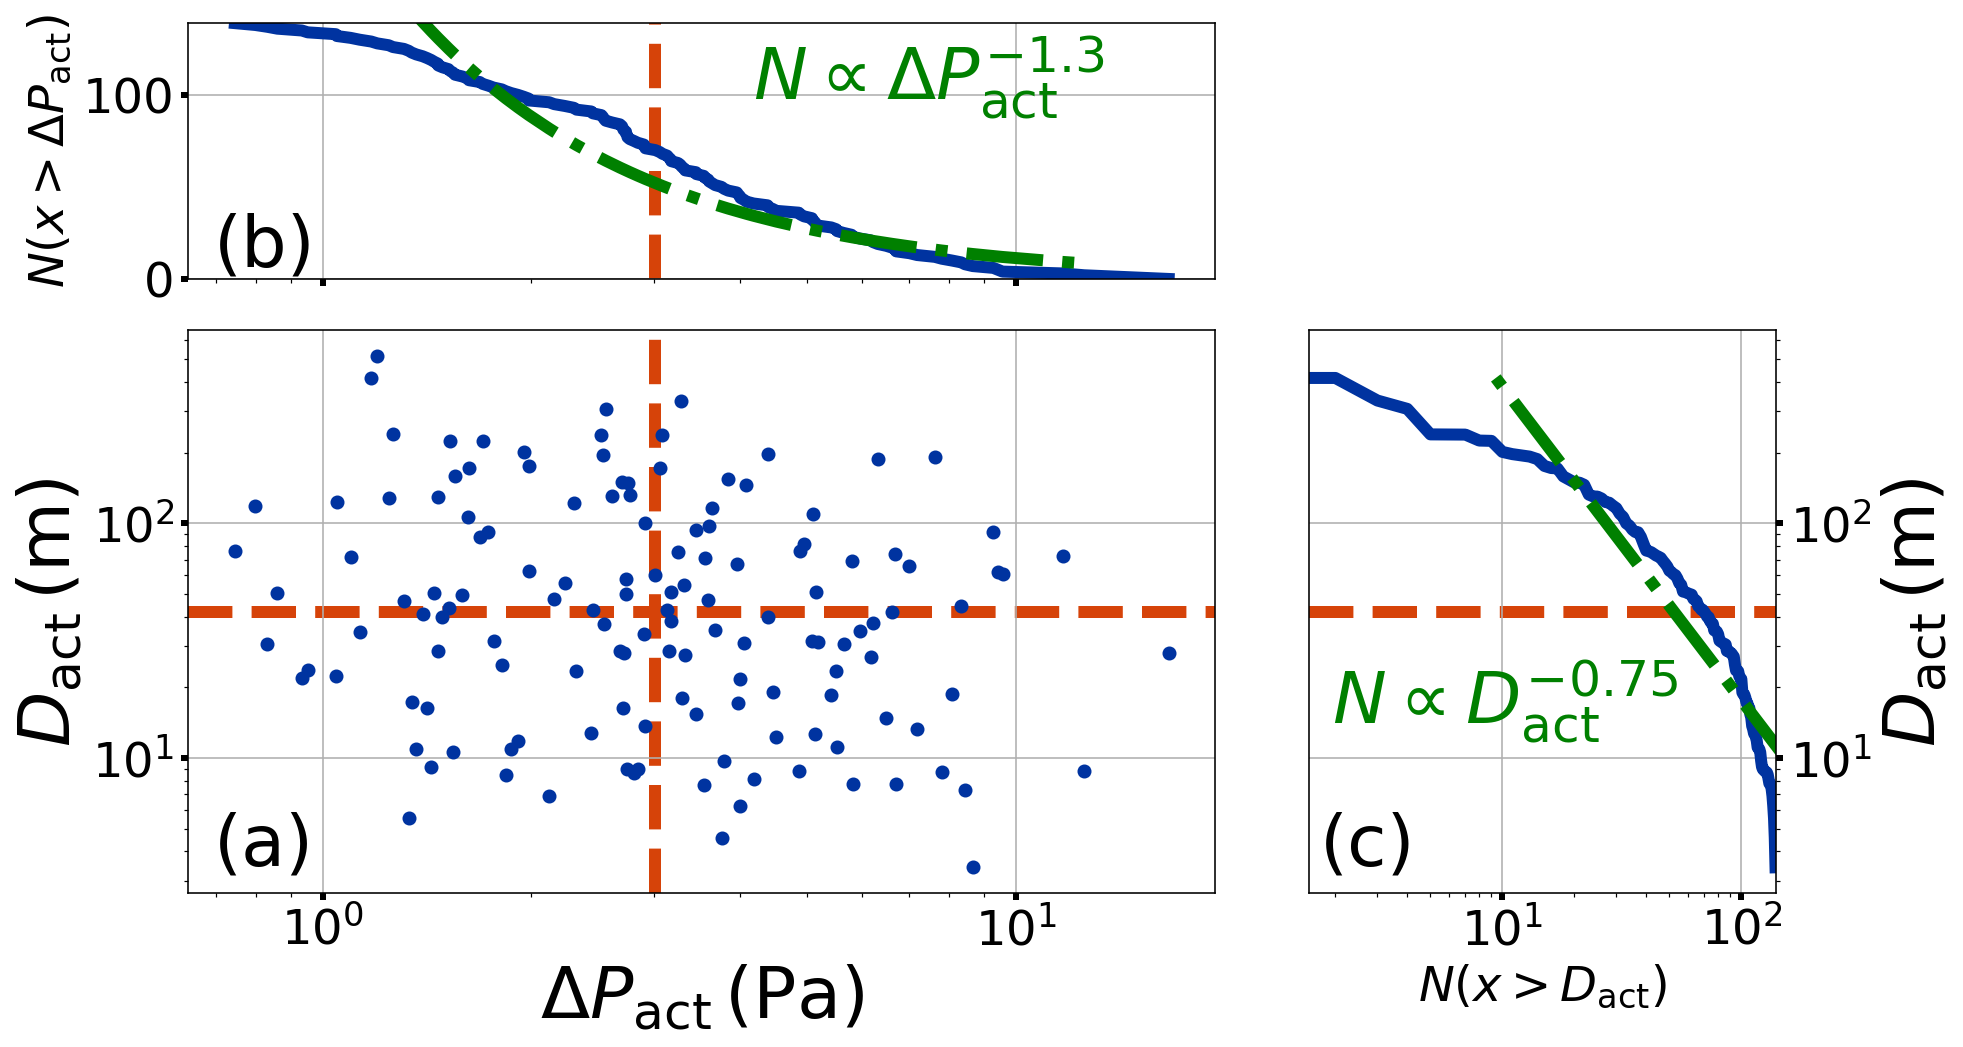

In [8]:
filename = "all_vortices_with_diameters_and_actual_values.csv"
data = np.genfromtxt(filename, delimiter=',', names=True, dtype=None)
# ind = (2.*(data['simple_Pact'] - data['full_Pact'])/(data['simple_Pact'] + data['full_Pact']) < 0.25) &\
#     (2.*(data['simple_Dact'] - data['full_Dact'])/(data['simple_Dact'] + data['full_Dact']) < 0.25) &\
#     (data['full_Vobs_sigma'] >= 3.)

# ind = (data['full_Vobs_sigma'] >= 3.) &\
#     (np.abs(data['full_b']/data['full_Dact']) < max_b_over_Dact)

ind = (np.abs(data['full_b']/data['full_Dact']) <= max_b_over_Dact) & (data['full_Vobs_sigma'] >= min_full_Vobs_sigma)

x = data['full_Pact'][ind]
y = data['full_Dact'][ind]
print(len(y))

fig = plt.figure(figsize=(8*aspect_ratio, 8))

ax1 = plt.subplot2grid((3,3), (1,0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=1, sharex=ax1)
ax3 = plt.subplot2grid((3,3), (1,2), colspan=1, rowspan=2, sharey=ax1)

ax1.loglog(x, y, marker='o', ls='', color=BoiseState_blue)
# ax1.errorbar(x, y, xerr=xerr, yerr=yerr, marker='o', ls='', color=BoiseState_blue)
ax1.set_xscale('log')
ax1.set_yscale('log')

x_quantile = np.median(x)
print("min, med, max Pact: ", np.min(x), x_quantile, np.max(x))
ax1.axvline(x_quantile, lw=6, ls='--', color=BoiseState_orange, zorder=-1)
y_quantile = np.median(y)
print("min, med, max Dact: ", np.min(y), y_quantile, np.max(y))
ax1.axhline(y_quantile, lw=6, ls='--', color=BoiseState_orange, zorder=-1)

coeffs = np.polyfit(np.log10(x), np.log10(y), 1)
srt = np.argsort(x)
# ax1.loglog(x[srt], 10.**(np.polyval(coeffs, np.log10(x)[srt])), lw=6, color='green', ls='-.')
# ax1.text(0.53, 0.85, r'$D_{\rm act} \propto \Delta P_{\rm act}^{%.2g}$' % coeffs[0], 
#          color='green', fontsize=36, transform=ax1.transAxes)
ax1.text(0.025, 0.05, '(a)', fontsize=36, transform=ax1.transAxes)

# 2021 Jan 27 - Check whether a line is a better fit than a median
print(coeffs)
print("BIC for line fit: ", BIC(np.log10(y[srt]), 10.**(np.polyval(coeffs, np.log10(x)[srt])), deg=2))
print("BIC for median fit: ", BIC(np.log10(y), np.ones_like(y)*y_quantile, deg=1))

### P_act cum hist ###
srt = np.argsort(x)
hst, _ = np.histogram(x[srt], bins=[0, *x[srt]])
cum_hst = len(x[srt]) - np.cumsum(hst)
ax2.semilogx(x[srt], cum_hst, lw=6, color=BoiseState_blue)
ax2.axvline(x_quantile, lw=6, ls='--', color=BoiseState_orange, zorder=-1)

cum_hst_ind = np.isfinite(np.log10(cum_hst))
coeffs = np.polyfit(np.log10(x[srt])[cum_hst_ind], np.log10(cum_hst)[cum_hst_ind], 1)
print(coeffs)
ax2.semilogx(x[srt][cum_hst_ind], 10.**(np.polyval(coeffs, np.log10(x[srt])[cum_hst_ind])), 
             color='green', lw=6, ls='-.')
ax2.set_ylim([0, np.max(cum_hst)])
ax2.text(0.55, 0.7, r'$N \propto \Delta P_{\rm act}^{%.2g}$' % coeffs[0], 
         color='green', fontsize=36, transform=ax2.transAxes)
ax2.text(0.025, 0.05, '(b)', fontsize=36, transform=ax2.transAxes)

### D_act cum hist ###
srt = np.argsort(y)
hst, _ = np.histogram(y[srt], bins=[0, *y[srt]])
cum_hst = len(y[srt]) - np.cumsum(hst)
ax3.semilogy(cum_hst, y[srt], lw=6, color=BoiseState_blue)
ax3.axhline(y_quantile, lw=6, ls='--', color=BoiseState_orange, zorder=-1)

cum_hst_ind = np.isfinite(np.log10(cum_hst))
coeffs = np.polyfit(np.log10(y[srt])[cum_hst_ind], np.log10(cum_hst)[cum_hst_ind], 1)
print(coeffs)
ax3.semilogx(10.**(np.polyval(coeffs, np.log10(y[srt])[cum_hst_ind])), y[srt][cum_hst_ind], 
             color='green', lw=6, ls='-.')
ax3.set_xlim([0, np.max(cum_hst)])
ax3.text(0.05, 0.3, r'$N \propto D_{\rm act}^{%.2g}$' % coeffs[0], 
         color='green', fontsize=36, transform=ax3.transAxes)
ax3.text(0.025, 0.05, '(c)', fontsize=36, transform=ax3.transAxes)

ax1.grid(True)
ax1.tick_params(labelsize=24)
ax1.set_xlabel(r'$\Delta P_{\rm act}\, \left( {\rm Pa} \right)$', fontsize=36)
ax1.set_ylabel(r'$D_{\rm act}\, \left( {\rm m} \right)$', fontsize=36)

ax2.grid(True)
ax2.tick_params(labelbottom=False, labelsize=24)
ax2.set_ylabel(r'$N(x > \Delta P_{\rm act})$', fontsize=24)

ax3.grid(True)
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()
ax3.tick_params(labelsize=24)
ax3.set_ylabel(r'$D_{\rm act}\, \left( {\rm m} \right)$', fontsize=36)
ax3.set_xlabel(r'$N(x > D_{\rm act})$', fontsize=24)

fig.savefig("../figures/Dact_vs_Pact.png", dpi=500, bbox_inches='tight')

3 0.02158273381294964


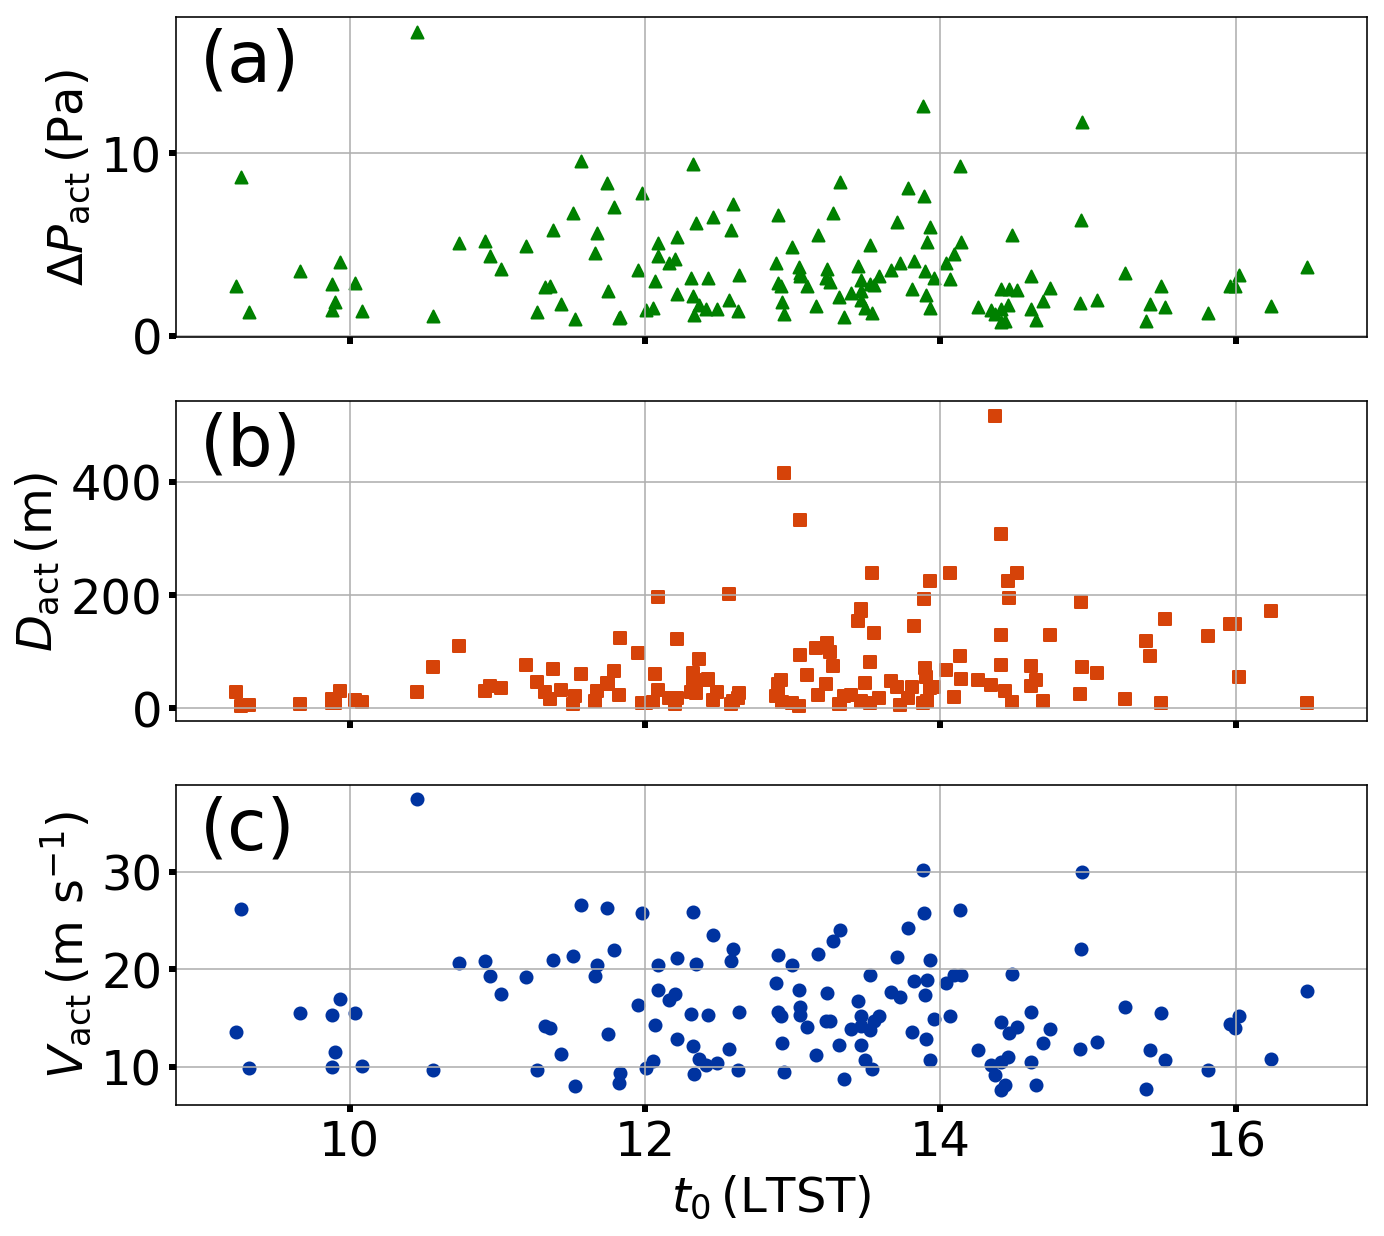

In [73]:
# 30 m/s threshold comes from:
# https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2006JE002700
# https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2011GL049806
# https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2002JE001987

threshold_velocity = 30.

fig = plt.figure(figsize=(6*aspect_ratio, 10))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312, sharex=ax1)
ax3 = fig.add_subplot(313, sharex=ax1)

filename = "all_vortices_with_diameters_and_actual_values.csv"
act_data = np.genfromtxt(filename, delimiter=',', names=True, dtype=None)
ind = (np.abs(act_data['full_b']/act_data['full_Dact']) <= max_b_over_Dact) &\
    (act_data['full_Vobs_sigma'] >= min_full_Vobs_sigma)
vortex_number = act_data['vortex_number'][ind]
sols = act_data['sols'][ind]
x = act_data['full_Pact'][ind]
y = act_data['full_Dact'][ind]
z = act_data['full_Vact'][ind]

# 2021 Jan 28 - Unfortunately, I kept the t0-values in a different file.
filename = "all_vortices_with_diameters.csv"
other_data = np.genfromtxt(filename, delimiter=',', names=True, dtype=None)

# Collate two datasets
t0 = np.array([])
mx_ind = np.argsort(x)[-2]
for i in range(len(vortex_number)):
    cur_vort_num = vortex_number[i]
    cur_sol = sols[i]
    ind = (other_data['vortex_number'] == cur_vort_num) & (other_data['sol'] == cur_sol)
    t0 = np.append(t0, other_data['t0'][ind][0])
    
#     if(i == mx_ind):
#         print(other_data['vortex_number'][ind], other_data['sol'][ind])
    
ax1.scatter(t0, x, color='green', marker='^')
ax2.scatter(t0, y, color=BoiseState_orange, marker='s')
ax3.scatter(t0, z, color=BoiseState_blue)
# ax3.axhline(threshold_velocity, color='lightgrey', lw=6, ls='--', zorder=-1)

print(len(z[z >= threshold_velocity]), z[z >= threshold_velocity].shape[0]/z.shape[0])

ax1.grid(True)
ax2.grid(True)
ax3.grid(True)

ax1.tick_params(labelbottom=False, labelsize=24)
ax2.tick_params(labelbottom=False, labelsize=24)
ax3.tick_params(labelsize=24)

ax1.text(0.02, 0.8, "(a)", fontsize=36, transform=ax1.transAxes)
ax2.text(0.02, 0.8, "(b)", fontsize=36, transform=ax2.transAxes)
ax3.text(0.02, 0.8, "(c)", fontsize=36, transform=ax3.transAxes)

ax1.set_ylabel(r'$\Delta P_{\rm act}\,\left( {\rm Pa} \right)$', fontsize=24)
ax2.set_ylabel(r'$D_{\rm act}\,\left( {\rm m} \right)$', fontsize=24)
ax3.set_ylabel(r'$V_{\rm act}\,\left( {\rm m\ s^{-1}} \right)$', fontsize=24)
ax3.set_xlabel(r'$t_0\,\left( {\rm LTST} \right)$', fontsize=24)

fig.savefig("../figures/all_actual_values_vs_t0.png", dpi=500, bbox_inches="tight")

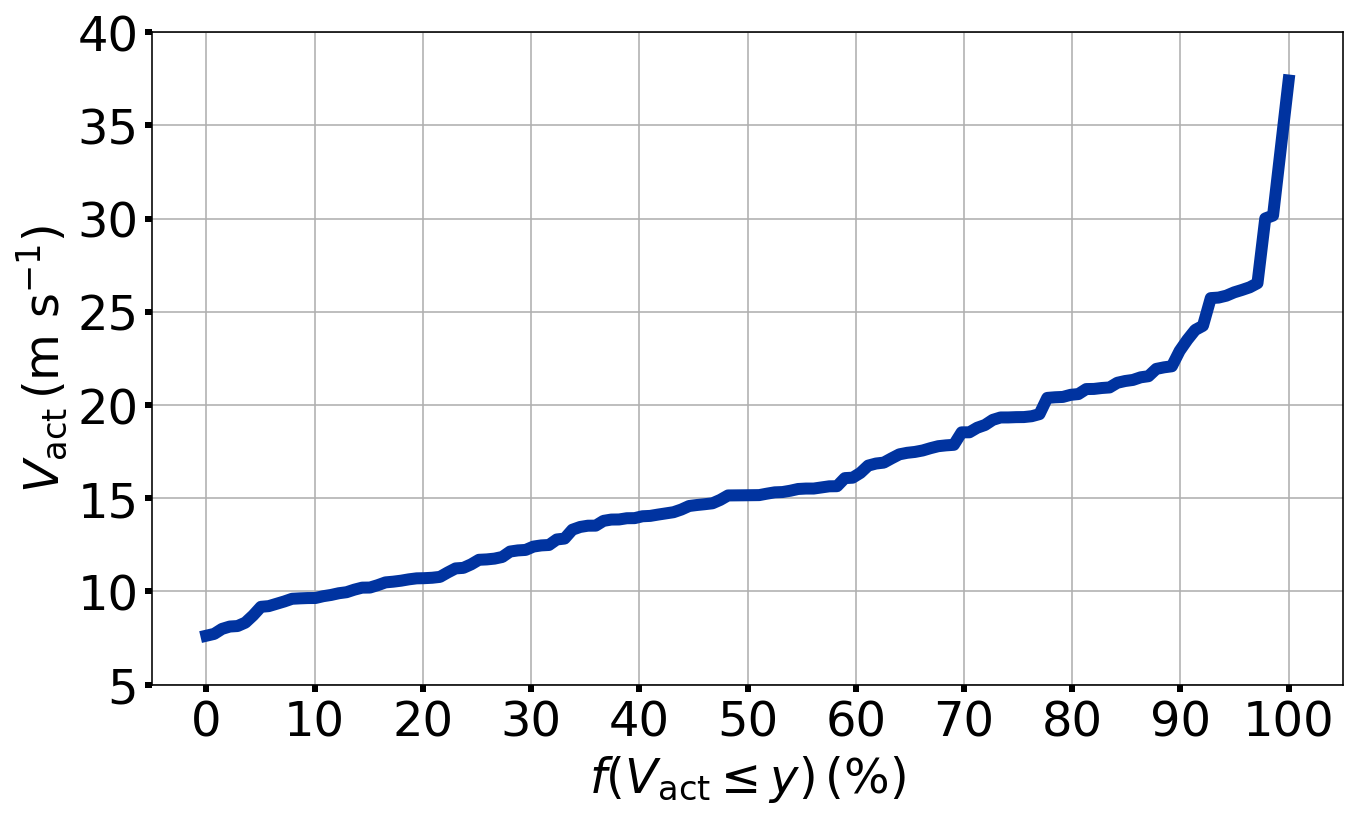

In [107]:
fig = plt.figure(figsize=(6*aspect_ratio, 6))
ax = fig.add_subplot(111)

filename = "all_vortices_with_diameters_and_actual_values.csv"
act_data = np.genfromtxt(filename, delimiter=',', names=True, dtype=None)
ind = (np.abs(act_data['full_b']/act_data['full_Dact']) <= max_b_over_Dact) &\
    (act_data['full_Vobs_sigma'] >= min_full_Vobs_sigma)

z = act_data['full_Vact'][ind]
bin_edges = np.array([-np.inf, *np.sort(z)])

hst, bin_edges = np.histogram(z, bins=bin_edges)
frac_cumsum = np.cumsum(hst)
frac_cumsum = frac_cumsum/len(z)

ax.plot(frac_cumsum*100., bin_edges[1:], lw=6, color=BoiseState_blue)

ax.grid(True)
ax.tick_params(labelsize=24)
ax.set_xticks(np.arange(0, 110, 10))
ax.set_yticks(np.arange(5, 45, 5))

ax.set_ylabel(r'$V_{\rm act}\,\left( {\rm m\ s^{-1}} \right)$', fontsize=24)
ax.set_xlabel(r'$f(V_{\rm act} \leq y) \,\left( {\rm \%} \right)$', fontsize=24)

fig.savefig("../figures/cum_hist_Vact.png", dpi=500, bbox_inches="tight")

In [9]:
# 2020 Sep 26 - Explore how often Vobs is the same as U1/U2
filename = "all_vortices_with_diameters_and_actual_values.csv"
# ('srt_ind', 'vortex_number', 'sols', 'DeltaP', 'Diameter', 'U1', 'U2', 'Vobs', 'simple_Pact', 'simple_Vact', 
# 'simple_Dact', 'simple_bact', 'simple_BIC', 'simple_Vobs_sigma', 'full_Vobs', 'full_b', 'full_Pact', 'full_Vact', 
# 'full_Dact', 'full_bact', 'full_BIC', 'full_Vobs_sigma')
data = np.genfromtxt(filename, delimiter=',', names=True, dtype=None)
ind = (2.*(data['simple_Pact'] - data['full_Pact'])/(data['simple_Pact'] + data['full_Pact']) < 0.25) &\
    (2.*(data['simple_Dact'] - data['full_Dact'])/(data['simple_Dact'] + data['full_Dact']) < 0.25)
num_vortices_wo_wind = len(data['simple_Dact'][ind])
print("Number of vortex encounters with meaningful model fits: ", num_vortices_wo_wind)

ind = (2.*(data['simple_Pact'] - data['full_Pact'])/(data['simple_Pact'] + data['full_Pact']) < 0.25) &\
    (2.*(data['simple_Dact'] - data['full_Dact'])/(data['simple_Dact'] + data['full_Dact']) < 0.25) &\
    (data['full_Vobs_sigma'] >= 3.)
num_agreeable_vortices = len(data['simple_Dact'][ind])
print("Number of vortex encounters with meaningful model fits that also differ from background: ",
            num_agreeable_vortices)

print(num_vortices_wo_wind - num_agreeable_vortices, 
      (num_vortices_wo_wind - num_agreeable_vortices)/num_agreeable_vortices)

Number of vortex encounters with meaningful model fits:  183
Number of vortex encounters with meaningful model fits that also differ from background:  127
56 0.4409448818897638


min, med, max Vact:  7.62372 15.1572 37.4119
[-0.64477943  2.37067405]
[-2.49836594  4.66250199]
[-0.74883605  2.93324857]


Text(0.5, 0, '$N(x > D_{\\rm act})$')

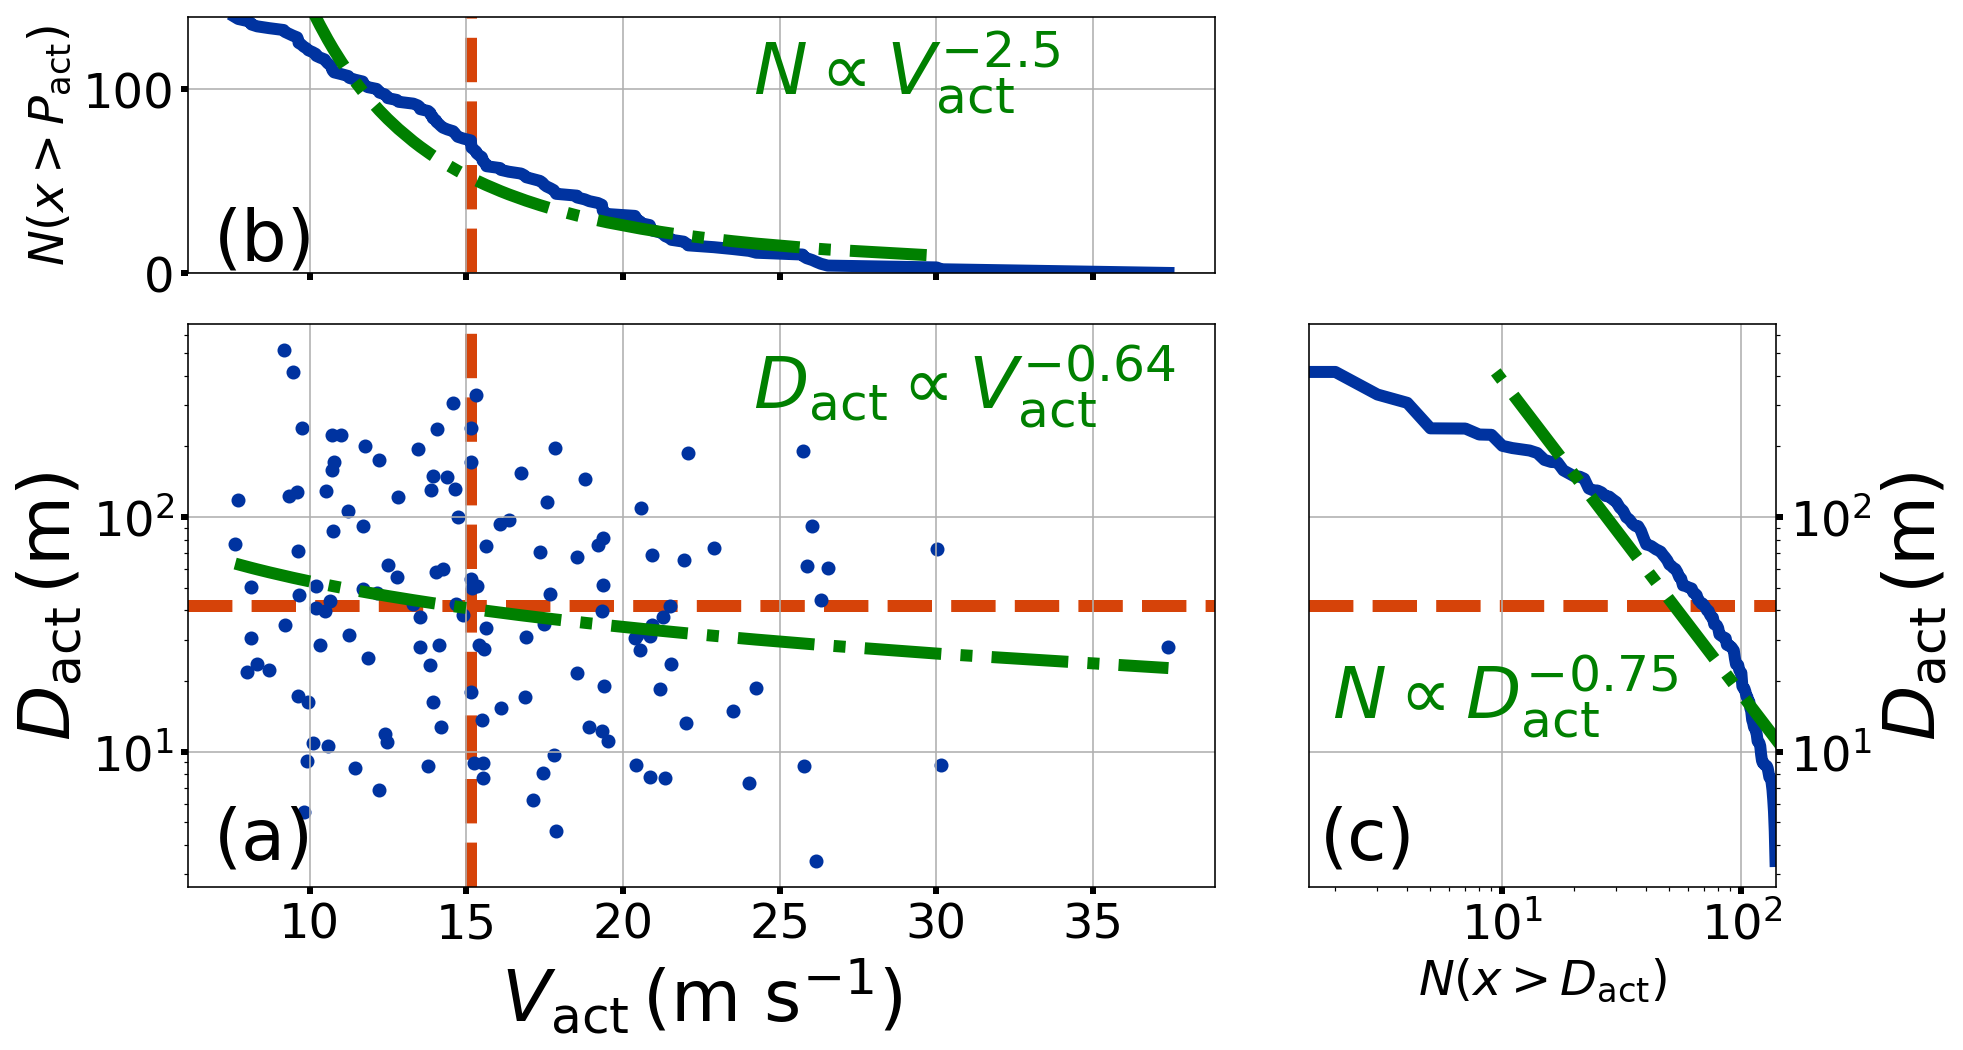

In [71]:
filename = "all_vortices_with_diameters_and_actual_values.csv"
# ('srt_ind', 'vortex_number', 'sols', 'DeltaP', 'Diameter', 'U1', 'U2', 'Vobs', 'simple_Pact', 'simple_Vact', 
# 'simple_Dact', 'simple_bact', 'simple_BIC', 'simple_Vobs_sigma', 'full_Vobs', 'full_b', 'full_Pact', 'full_Vact', 
# 'full_Dact', 'full_bact', 'full_BIC', 'full_Vobs_sigma')
data = np.genfromtxt(filename, delimiter=',', names=True, dtype=None)
ind = (np.abs(act_data['full_b']/act_data['full_Dact']) <= max_b_over_Dact) &\
    (act_data['full_Vobs_sigma'] >= min_full_Vobs_sigma)

x = data['full_Vact'][ind]
y = data['full_Dact'][ind]

fig = plt.figure(figsize=(8*aspect_ratio, 8))

ax1 = plt.subplot2grid((3,3), (1,0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=1, sharex=ax1)
ax3 = plt.subplot2grid((3,3), (1,2), colspan=1, rowspan=2, sharey=ax1)

# ax1.loglog(x, y, marker='o', ls='', color=BoiseState_blue)
ax1.scatter(x, y, marker='o', color=BoiseState_blue)
ax1.set_yscale('log')

x_quantile = np.median(x)
print("min, med, max Vact: ", np.min(x), np.median(x), np.max(x))
ax1.axvline(x_quantile, lw=6, ls='--', color=BoiseState_orange, zorder=-1)
y_quantile = np.median(y)
ax1.axhline(y_quantile, lw=6, ls='--', color=BoiseState_orange, zorder=-1)

coeffs = np.polyfit(np.log10(x), np.log10(y), 1)
print(coeffs)
srt = np.argsort(x)
ax1.semilogy(x[srt], 10.**(np.polyval(coeffs, np.log10(x)[srt])), lw=6, color='green', ls='-.')
ax1.text(0.55, 0.85, r'$D_{\rm act} \propto V_{\rm act}^{%.2g}$' % coeffs[0], 
         color='green', fontsize=36, transform=ax1.transAxes)
ax1.text(0.025, 0.05, '(a)', fontsize=36, transform=ax1.transAxes)

### P_act cum hist ###
srt = np.argsort(x)
hst, _ = np.histogram(x[srt], bins=[0, *x[srt]])
cum_hst = len(x[srt]) - np.cumsum(hst)
ax2.plot(x[srt], cum_hst, lw=6, color=BoiseState_blue)
ax2.axvline(x_quantile, lw=6, ls='--', color=BoiseState_orange, zorder=-1)

cum_hst_ind = np.isfinite(np.log10(cum_hst))
coeffs = np.polyfit(np.log10(x[srt])[cum_hst_ind], np.log10(cum_hst)[cum_hst_ind], 1)
print(coeffs)
ax2.plot(x[srt][cum_hst_ind], 10.**(np.polyval(coeffs, np.log10(x[srt])[cum_hst_ind])), 
             color='green', lw=6, ls='-.')
ax2.set_ylim([0, np.max(cum_hst)])
ax2.text(0.55, 0.7, r'$N \propto V_{\rm act}^{%.2g}$' % coeffs[0], 
         color='green', fontsize=36, transform=ax2.transAxes)
ax2.text(0.025, 0.05, '(b)', fontsize=36, transform=ax2.transAxes)

### D_act cum hist ###
srt = np.argsort(y)
hst, _ = np.histogram(y[srt], bins=[0, *y[srt]])
cum_hst = len(y[srt]) - np.cumsum(hst)
ax3.semilogy(cum_hst, y[srt], lw=6, color=BoiseState_blue)
ax3.axhline(y_quantile, lw=6, ls='--', color=BoiseState_orange, zorder=-1)

cum_hst_ind = np.isfinite(np.log10(cum_hst))
coeffs = np.polyfit(np.log10(y[srt])[cum_hst_ind], np.log10(cum_hst)[cum_hst_ind], 1)
print(coeffs)
ax3.semilogx(10.**(np.polyval(coeffs, np.log10(y[srt])[cum_hst_ind])), y[srt][cum_hst_ind], 
             color='green', lw=6, ls='-.')
ax3.set_xlim([0, np.max(cum_hst)])
ax3.text(0.05, 0.3, r'$N \propto D_{\rm act}^{%.2g}$' % coeffs[0], 
         color='green', fontsize=36, transform=ax3.transAxes)
ax3.text(0.025, 0.05, '(c)', fontsize=36, transform=ax3.transAxes)

ax1.grid(True)
ax1.tick_params(labelsize=24)
ax1.set_xlabel(r'$V_{\rm act}\, \left( {\rm m\ s^{-1}} \right)$', fontsize=36)
ax1.set_ylabel(r'$D_{\rm act}\, \left( {\rm m} \right)$', fontsize=36)

ax2.grid(True)
ax2.tick_params(labelbottom=False, labelsize=24)
ax2.set_ylabel(r'$N(x > P_{\rm act})$', fontsize=24)

ax3.grid(True)
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()
ax3.tick_params(labelsize=24)
ax3.set_ylabel(r'$D_{\rm act}\, \left( {\rm m} \right)$', fontsize=36)
ax3.set_xlabel(r'$N(x > D_{\rm act})$', fontsize=24)

# fig.savefig("../figures/Dact_vs_Pact.png", dpi=500, bbox_inches='tight')

In [26]:
# 2020 Sep 9 - Commented everything out

filename = "all_vortices_2020Aug9.csv"
data = np.genfromtxt(filename, delimiter=',', names=True)

# Toss the ones at either end
ind = (data['Gamma'] > Gamma_min) & (data['Gamma'] < Gamma_max) & (data['DeltaP'] > P_min)
sols = data['sol'][ind]
t0 = data['t0'][ind]
vortex_number = data['vortex_number'][ind]
Gamma = data['Gamma'][ind]
DeltaP = data['DeltaP'][ind]
slope = data['slope'][ind]
intercept = data['intercept'][ind]

new_filename = "anticipating_encounters.csv"
f = open(new_filename, "w")
f.write("# srt_ind, vortex_number, sols, DeltaP, Gamma, pressure_scatter, dpdt_scatter,"+\
        " pressure_outlier_time, dpdt_outlier_time\n")

# Fit the vortices in order from deepest to least deep until we can't fit 'em no more
srt = np.argsort(DeltaP)[::-1]

last_sol = 0
# for srt_ind in range(len(sols)):
# for srt_ind in [srt[200]]:
for srt_ind in srt[0:201]:
    
    if(sols[srt_ind] != last_sol):
        LTST, LTST_and_sol, sol_data = retrieve_data(sols[srt_ind], dr=dr)
        LTST_and_sol -= 24.*sols[srt_ind]
        
        wind_LTST, wind_LTST_and_sol, wind_data = find_wind(sols[srt_ind], dr_wind=dr_wind)
        wind_LTST_and_sol -= 24.*sols[srt_ind]

        last_sol = sols[srt_ind]
        
#     try:
    wind_x, wind_y, wind_sigma, pressure_x, pressure_y, pressure_sigma, density =\
        abbrev_retrieve_wind_and_pressure(wind_LTST, wind_LTST_and_sol, wind_data, LTST, LTST_and_sol, sol_data, 
                                      t0[srt_ind], np.max([100., Gamma[srt_ind]]))

    detrended_pressure_y = pressure_y - np.polyval([slope[srt_ind], intercept[srt_ind]], pressure_x)

    pressure_outlier_time = np.nan
    ind = (detrended_pressure_y - np.median(detrended_pressure_y)) < -num_sig*mad(detrended_pressure_y)
    if(len(pressure_x[ind]) >= 1):
        sorted_ind = np.argsort(pressure_x[ind])[0]
        pressure_outlier_time = pressure_x[ind][sorted_ind]*3600

    dpdt_outlier_time = np.nan
    dp_dt = np.gradient(detrended_pressure_y, pressure_x*3600.)
    ind = (dp_dt - np.median(dp_dt)) < -num_sig*mad(dp_dt)
    if(len(pressure_x[ind])):
        sorted_ind = np.argsort(pressure_x[ind])[0]
        dpdt_outlier_time = pressure_x[ind][sorted_ind]*3600

#         plt.scatter(pressure_x*3600., dp_dt)
#         plt.axhline(np.median(dp_dt), color='grey', lw=3, zorder=-1)
#         plt.axhline(np.median(dp_dt) - mad(dp_dt), color='grey', lw=3, zorder=-1, ls='--')
#         plt.axhline(np.median(dp_dt) + mad(dp_dt), color='grey', lw=3, zorder=-1, ls='--')

#     plt.axvline(dpdt_outlier_time)
#         plt.plot(pressure_x[ind][sorted_ind]*3600., dp_dt[ind][sorted_ind], color='grey', 
#                  ls='', marker='o', markersize=30, fillstyle='none')

#         plt.xlim([-10*Gamma[srt_ind], 10*Gamma[srt_ind]])
#         print(dpdt_outlier_time/(Gamma[srt_ind]/3600.))

    print("%i, %i, %i, %g, %g, %g, %g, %g, %g" %\
          (srt_ind, vortex_number[srt_ind], sols[srt_ind], DeltaP[srt_ind], Gamma[srt_ind],
           mad(detrended_pressure_y), mad(dp_dt), pressure_outlier_time, dpdt_outlier_time))
    f.write("%i, %i, %i, %g, %g, %g, %g, %g, %g\n" %\
            (srt_ind, vortex_number[srt_ind], sols[srt_ind], DeltaP[srt_ind], Gamma[srt_ind],
           mad(detrended_pressure_y), mad(dp_dt), pressure_outlier_time, dpdt_outlier_time))

#     except:
#         print("sol %i, vortex_number %i didn't work!" % (sols[srt_ind], vortex_number[srt_ind]))
    
f.close()

178, 6, 65, 8.88687, 3.27531, 0.140749, 0.00670878, -6.2, -16.2
1312, 3, 459, 8.18645, 3.16881, 0.157805, 0.00926626, -4.68, -15.68
587, 5, 231, 6.97169, 2.14371, 0.706485, 0.018236, -0.28, -273.28
1294, 5, 453, 6.0968, 5.96736, 0.153585, 0.0143812, -9.68, -442.68
865, 9, 323, 6.02135, 7.59835, 0.676874, 0.0252413, -2.8, -11.8
1305, 3, 456, 5.93449, 1.44456, 0.992324, 0.0128245, nan, -13.52
653, 7, 254, 5.49744, 4.82422, 0.189388, 0.0120832, -6.2, -12.2
598, 10, 233, 5.35481, 1.05993, 0.12314, 0.0212383, -113.84, -120.84
1272, 1, 442, 5.22974, 4.2559, 0.52176, 0.023351, -1.48, -5.48
36, 11, 19, 5.17548, 14.8905, 0.14949, 0.0232027, -19.44, -20.44
1102, 5, 385, 5.15373, 1.43416, 0.357002, 0.0151596, -0.92, -464.92
34, 9, 19, 5.07984, 14.407, 1.01608, 0.0232027, -2.8, -20.8
35, 10, 19, 5.04068, 4.07097, 1.06914, 0.0207564, nan, -6.72
108, 5, 39, 4.88062, 16.9568, 0.175975, 0.00889561, -16.24, -21.24
105, 2, 39, 4.73273, 15.2577, 1.01927, 0.00889561, nan, -21.24
107, 4, 39, 4.73033, 15.28

1274, 1, 443, 2.62074, 1.69711, 0.74308, 0.0274652, nan, -2.608
1184, 1, 410, 2.61974, 1.42639, 0.464035, 0.0152708, nan, -129.64
1359, 0, 472, 2.61809, 6.5871, 0.846567, 0.0164569, nan, -6.24
1380, 1, 105, 2.60896, 9.92135, 0.110493, 0.00737595, -10.88, -15.88
1442, 0, 105, 2.60572, 10.2614, 0.100355, 0.00737595, -11.88, -15.88
1360, 1, 472, 2.60348, 6.30367, 0.0930298, 0.0164569, -8.24, -6.24
1342, 14, 467, 2.60298, 4.4574, 0.154332, 0.0163086, -2.44, -215.44
1379, 0, 105, 2.58419, 9.12913, 0.439266, 0.00737595, -1.88, -15.88
195, 2, 76, 2.57756, 15.3093, 1.58058, 0.00833964, nan, -18.4
350, 0, 158, 2.57688, 4.85623, 0.474542, 0.0132693, -0.64, -362.64
196, 3, 76, 2.57403, 14.28, 0.106384, 0.00833964, -10.4, -18.4
572, 2, 228, 2.55781, 6.46084, 0.137279, 0.014789, -6.44, -177.44
391, 1, 173, 2.55655, 1.15648, 0.373303, 0.0194962, 0.32, -3.68
194, 1, 76, 2.55426, 14.5429, 1.25135, 0.00833964, nan, -18.4
1430, 2, 390, 2.54623, 1.13319, 0.15551, 0.0214236, -0.72, -138.72
421, 1, 188, 2.

1.0890441495188572


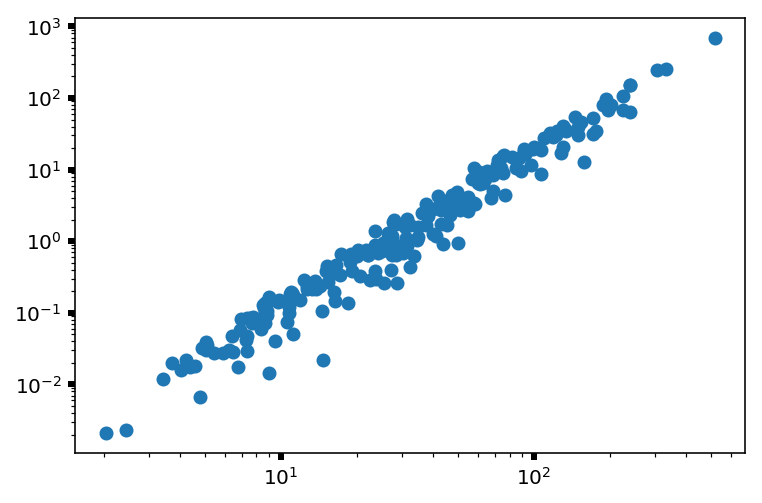

In [108]:
# 2020 Oct 9 - Trying to calculate population-weighted survey area

def calc_lifetime(Dact, D0=1., tau0=40., bet=2./3):
    return tau0*(Dact/D0)**bet

def calc_Asurvey(Dact, Delta_Pact, U, lifetime, Delta_Pmin=P_min):
    return Dact*np.sqrt(Delta_Pact/Delta_Pmin -1.)*U*lifetime

filename = "all_vortices_with_diameters_and_actual_values.csv"
# ('srt_ind', 'vortex_number', 'sols', 'DeltaP', 'Diameter', 'U1', 'U2', 'Vobs', 'simple_Pact', 'simple_Vact', 
# 'simple_Dact', 'simple_bact', 'simple_BIC', 'simple_Vobs_sigma', 'full_Vobs', 'full_b', 'full_Pact', 'full_Vact', 
# 'full_Dact', 'full_bact', 'full_BIC', 'full_Vobs_sigma')
data = np.genfromtxt(filename, delimiter=',', names=True, dtype=None)
ind = (data['full_Vobs_sigma'] >= 3.) &\
    (np.abs(data['full_b']/data['full_Dact']) < max_b_over_Dact) &\
    (np.abs(data['full_b']/data['full_Dact']) > min_b_over_Dact)

Dact = data['full_Dact'][ind]
Pact = data['full_Dact'][ind]
U = data['U1'][ind]
lifetime = calc_lifetime(Dact)

Asurvey = calc_Asurvey(Dact, Pact, U, lifetime)
plt.loglog(Dact, Asurvey/1e6, ls='', marker='o')
print(np.quantile(Asurvey/1e6, 0.5))